# Coverage Experiment

### Compute coverage empirically

  0%|          | 0/7 [00:00<?, ?it/s]

--- δ:  0.5  ---
True chgpts = [175]
Constructed credible set with aimed coverage:  0.9612769956469586
Estimated coverage:  0.9284459035203777


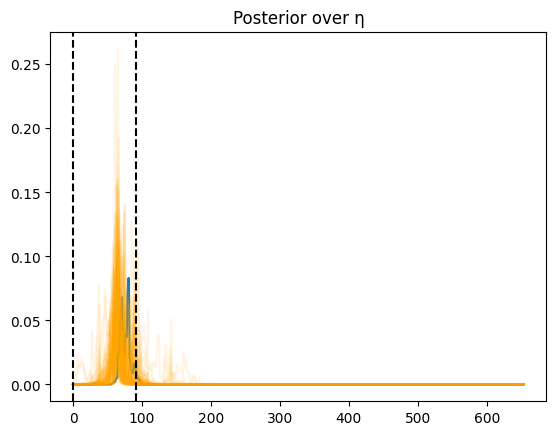

 14%|█▍        | 1/7 [00:26<02:39, 26.66s/it]

--- δ:  0.5  ---
True chgpts = [262]
Constructed credible set with aimed coverage:  0.9524420778054048
Estimated coverage:  0.9699356671450559


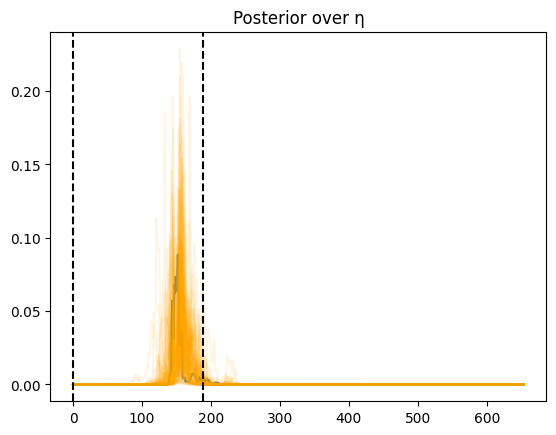

 29%|██▊       | 2/7 [00:50<02:04, 24.83s/it]

--- δ:  0.5  ---
True chgpts = [350]
Constructed credible set with aimed coverage:  0.9721270663152758
Estimated coverage:  0.959342942780836


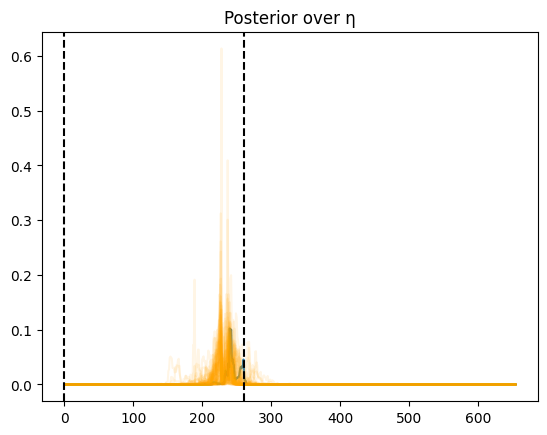

 43%|████▎     | 3/7 [01:13<01:36, 24.21s/it]

--- δ:  0.5  ---
True chgpts = [437]
Constructed credible set with aimed coverage:  0.9505729870580154
Estimated coverage:  0.8017707603153227


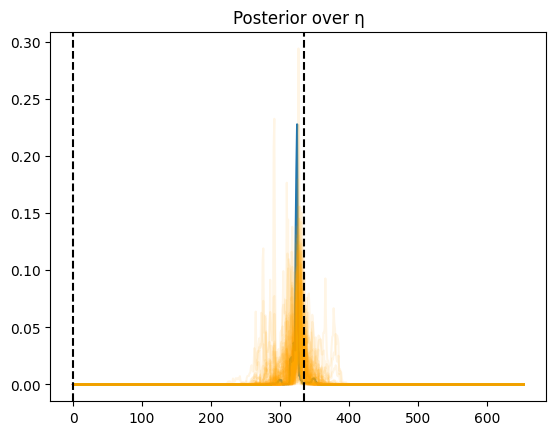

 57%|█████▋    | 4/7 [01:36<01:11, 23.81s/it]

--- δ:  0.5  ---
True chgpts = [525]
Constructed credible set with aimed coverage:  0.9566624650709449
Estimated coverage:  0.8059079798100294


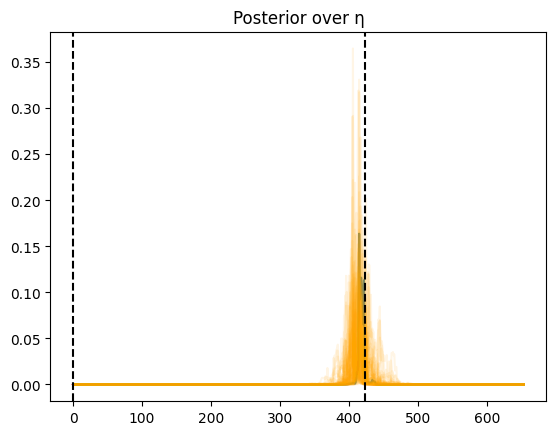

 71%|███████▏  | 5/7 [02:00<00:47, 23.64s/it]

--- δ:  0.5  ---
True chgpts = [612]
Constructed credible set with aimed coverage:  0.9529414161663691
Estimated coverage:  0.7264729100922477


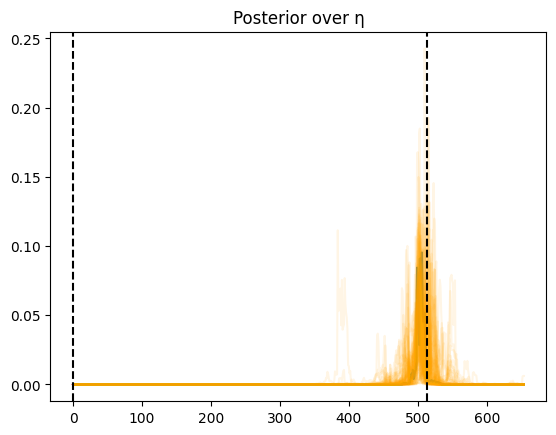

 86%|████████▌ | 6/7 [02:23<00:23, 23.68s/it]

--- δ:  0.5  ---
True chgpts = [700]
Constructed credible set with aimed coverage:  0.958560517121306
Estimated coverage:  0.6721707115602678


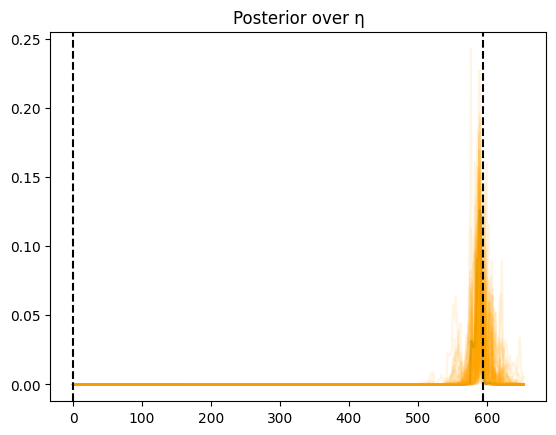

100%|██████████| 7/7 [02:48<00:00, 24.08s/it]


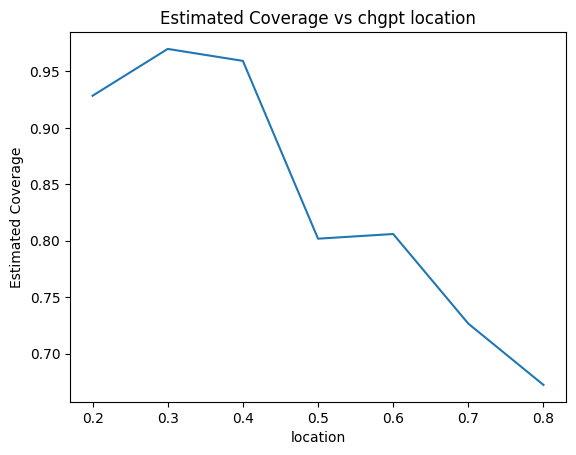

In [1]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 1750
σ = 0.05 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0]

# seed = 29
# nprandom.seed(2*seed)

norm_sq_corr_1_lists = [[] for i in range(len(δ_list))]
norm_sq_corr_2_lists = [[] for i in range(len(δ_list))]

norm_sq_corr_1_avg_list = []
norm_sq_corr_2_avg_list = []
norm_sq_corr_1_std_list = []
norm_sq_corr_2_std_list = []

norm_sq_corr_1_SE_list = []
norm_sq_corr_2_SE_list = []

norm_sq_corr_1_SE_fixed_lists = [[] for i in range(len(δ_list))]
norm_sq_corr_2_SE_fixed_lists = [[] for i in range(len(δ_list))]

norm_sq_corr_1_SE_fixed_avg_list = []
norm_sq_corr_2_SE_fixed_avg_list = []
norm_sq_corr_1_SE_fixed_std_list = []
norm_sq_corr_2_SE_fixed_std_list = []

mse_1_list = []
mse_2_list = []
mse_1_SE_list = []
mse_2_SE_list = []
post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

chgpt_location_idx = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

coverage_list = [[] for i in range(len(chgpt_location_idx))]

δ = 0.5
n = int(δ * p)
B̃_cov = np.eye(L)

# Gaussian Prior
signal_prior = GaussianSignal(B̃_cov)
B̃ = signal_prior.sample(p)
B̂_0 = signal_prior.sample(p)

for i in tqdm(range(len(chgpt_location_idx))):
    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 
    print("--- δ: ", δ, " ---")


    # Changepoint locations
    Δ = lambda n: int(n/8)

    Lmin = L
    Lmax = L # TODO: ground truth is L=4 cell stages (3 chgpts).
    num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
    assert η_arr.shape == (num_valid_configs, Lmax-1) and \
        len(p_η_arr) == num_valid_configs
    assert ϕ.shape == (Lmax, n)

    print(f"True chgpts = {true_chgpt_locations(n)}")
    C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

    # Generate the observation vector Y
    X = np.random.normal(0, np.sqrt(1/n), (n, p))
    Θ = X @ B̃
    Y = q(Θ, C_true, σ) 

    # true_chgpt_locations = lambda n: [int(n/3)]
    # ϕ = amp.signal_configuration.C_to_marginal(C_s) 

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
    κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν

    # Compute the credible set S(Θ_t, Y)
    post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
    α_CI = 0.05
    # plt.plot(post_Θ_Y)
    # plt.show()
    try:
        # S_lower, S_upper = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) # Have to adapt for eta. 
        S_upper = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_Θ_Y)
        S_lower = 0
        # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
    except Exception as e:
        print("Credible Set Error: ", e)
        # S_lower, S_upper = None, None
        continue
    # S_lower_upper_list[i].append((S_lower, S_upper))
    print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower:S_upper].sum())
    # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])

    ### --- Estimate Expected coverage, with ensemble variables --- ###
    ## Sample Z, V̄_Θ, ε̄. 
    num_samples = 100
    # Sample Z
    Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
    # Sample V̄_Θ
    V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
        jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
    # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
    ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
    # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

    for j in range(num_samples):
        Ȳ = q(Z[j].reshape((n, L)), C_true, σ)
        post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
        plt.plot(post_V_Z, color='orange', alpha=0.1)
        # plt.show()
        # if S_lower is not None:
        #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
        coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
        # else:
        #     coverage_list[i].append(None)
    print("Estimated coverage: ", np.mean(coverage_list[i]))
    # Add x-ticks where S_lower and S_upper are
    plt.axvline(x=S_lower, color='black', linestyle='--')
    plt.axvline(x=S_upper, color='black', linestyle='--')
    plt.title("Posterior over η")
    plt.show()

### Plot the mean estimated coverage over δ
plt.figure()
plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1))
plt.xlabel("location")
plt.axvline(x=true_chgpt_locations(n)[0], color='red', linestyle='--', alpha=0.3)
plt.ylabel("Estimated Coverage")
plt.title("Estimated Coverage vs chgpt location")
plt.show()




### State Evolution Coverage to match

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9504271408017131


  2%|▏         | 1/50 [00:09<08:00,  9.81s/it]

Estimated coverage:  0.18836284973001305
Constructed credible set with aimed coverage:  0.9583149581952901


  4%|▍         | 2/50 [00:19<07:51,  9.83s/it]

Estimated coverage:  0.5941814247848713
Constructed credible set with aimed coverage:  0.964819713756381


  6%|▌         | 3/50 [00:29<07:48,  9.97s/it]

Estimated coverage:  0.7294542831899142
Constructed credible set with aimed coverage:  0.9538010268816978


  8%|▊         | 4/50 [00:39<07:40, 10.00s/it]

Estimated coverage:  0.7970907123924357
Constructed credible set with aimed coverage:  0.9652819681160176


 10%|█         | 5/50 [00:49<07:30, 10.01s/it]

Estimated coverage:  0.8376725699139486
Constructed credible set with aimed coverage:  0.9661977502887777


 12%|█▏        | 6/50 [00:59<07:20, 10.01s/it]

Estimated coverage:  0.8647271415949571
Constructed credible set with aimed coverage:  0.9519981355277309


 14%|█▍        | 7/50 [01:09<07:10, 10.02s/it]

Estimated coverage:  0.8840518356528204
Constructed credible set with aimed coverage:  0.9517842604944592


 16%|█▌        | 8/50 [01:19<07:01, 10.03s/it]

Estimated coverage:  0.8985453561962179
Constructed credible set with aimed coverage:  0.9563682190841583


 18%|█▊        | 9/50 [01:29<06:51, 10.03s/it]

Estimated coverage:  0.9098180943966381
Constructed credible set with aimed coverage:  0.9500092253265329


 20%|██        | 10/50 [01:40<06:41, 10.04s/it]

Estimated coverage:  0.9188362849569743
Constructed credible set with aimed coverage:  1.0


 22%|██▏       | 11/50 [01:50<06:31, 10.03s/it]

Estimated coverage:  0.9262148045063403
Constructed credible set with aimed coverage:  0.9698128593818938


 24%|██▍       | 12/50 [02:00<06:20, 10.02s/it]

Estimated coverage:  0.9323635707974787
Constructed credible set with aimed coverage:  0.9596563654005726


 26%|██▌       | 13/50 [02:10<06:09, 10.00s/it]

Estimated coverage:  0.9375663730438251
Constructed credible set with aimed coverage:  0.9524761627274795


 28%|██▊       | 14/50 [02:19<05:59,  9.99s/it]

Estimated coverage:  0.942025917826409
Constructed credible set with aimed coverage:  0.9522342698139672


 30%|███       | 15/50 [02:29<05:49,  9.99s/it]

Estimated coverage:  0.9458908566379817
Constructed credible set with aimed coverage:  0.9999999999999999


 32%|███▏      | 16/50 [02:39<05:39,  9.98s/it]

Estimated coverage:  0.9492726780981079
Constructed credible set with aimed coverage:  0.969734386591319


 34%|███▍      | 17/50 [02:49<05:29,  9.99s/it]

Estimated coverage:  0.9522566382099839
Constructed credible set with aimed coverage:  0.9520560305517183


 36%|███▌      | 18/50 [02:59<05:19, 10.00s/it]

Estimated coverage:  0.9549090471983182
Constructed credible set with aimed coverage:  0.9533588423967131


 38%|███▊      | 19/50 [03:09<05:09,  9.99s/it]

Estimated coverage:  0.9572822552405119
Constructed credible set with aimed coverage:  0.9514973687479726


 40%|████      | 20/50 [03:19<04:59, 10.00s/it]

Estimated coverage:  0.9594181424784863
Constructed credible set with aimed coverage:  0.9777889926952223


 42%|████▏     | 21/50 [03:29<04:49, 10.00s/it]

Estimated coverage:  0.9613506118842726
Constructed credible set with aimed coverage:  0.9540982674770953


 44%|████▍     | 22/50 [03:39<04:39,  9.99s/it]

Estimated coverage:  0.9631074022531694
Constructed credible set with aimed coverage:  1.0000000000000004


 46%|████▌     | 23/50 [03:49<04:29,  9.99s/it]

Estimated coverage:  0.9647114282421622
Constructed credible set with aimed coverage:  1.0000000000000004


 48%|████▊     | 24/50 [03:59<04:19,  9.98s/it]

Estimated coverage:  0.9661817853987388
Constructed credible set with aimed coverage:  0.9999999999999996


 50%|█████     | 25/50 [04:09<04:09,  9.97s/it]

Estimated coverage:  0.9675345139827892
Constructed credible set with aimed coverage:  0.9515266066984889


 52%|█████▏    | 26/50 [04:19<03:59,  9.97s/it]

Estimated coverage:  0.9687831865219125
Constructed credible set with aimed coverage:  0.9999999999999994


 54%|█████▍    | 27/50 [04:29<03:49,  9.97s/it]

Estimated coverage:  0.9699393647988788
Constructed credible set with aimed coverage:  1.0


 56%|█████▌    | 28/50 [04:39<03:39,  9.97s/it]

Estimated coverage:  0.9710129589132045
Constructed credible set with aimed coverage:  0.9512744312078794


 58%|█████▊    | 29/50 [04:49<03:29,  9.97s/it]

Estimated coverage:  0.9720125120541285
Constructed credible set with aimed coverage:  0.9561081541253152


 60%|██████    | 30/50 [04:59<03:19,  9.99s/it]

Estimated coverage:  0.9729454283189909
Constructed credible set with aimed coverage:  0.9509112828429966


 62%|██████▏   | 31/50 [05:09<03:09, 10.00s/it]

Estimated coverage:  0.9738181564377331
Constructed credible set with aimed coverage:  0.9598404233685427


 64%|██████▍   | 32/50 [05:19<03:00, 10.01s/it]

Estimated coverage:  0.9746363390490539
Constructed credible set with aimed coverage:  0.9979641616480441


 66%|██████▌   | 33/50 [05:29<02:50, 10.00s/it]

Estimated coverage:  0.9754049348354462
Constructed credible set with aimed coverage:  0.987830506084836


 68%|██████▊   | 34/50 [05:39<02:39, 10.00s/it]

Estimated coverage:  0.976128319104992
Constructed credible set with aimed coverage:  1.0000000000000004


 70%|███████   | 35/50 [05:49<02:29,  9.99s/it]

Estimated coverage:  0.9768103671305636
Constructed credible set with aimed coverage:  0.9761865919441244


 72%|███████▏  | 36/50 [05:59<02:19,  9.99s/it]

Estimated coverage:  0.9774545235991591
Constructed credible set with aimed coverage:  0.9514598409269055


 74%|███████▍  | 37/50 [06:09<02:09,  9.97s/it]

Estimated coverage:  0.9780638607922472
Constructed credible set with aimed coverage:  0.9732982622386659


 76%|███████▌  | 38/50 [06:19<01:59,  9.98s/it]

Estimated coverage:  0.9786411276135037
Constructed credible set with aimed coverage:  0.9602110682433039


 78%|███████▊  | 39/50 [06:29<01:49,  9.98s/it]

Estimated coverage:  0.9791887910080294
Constructed credible set with aimed coverage:  0.957798358578982


 80%|████████  | 40/50 [06:39<01:39,  9.97s/it]

Estimated coverage:  0.9797090712328286
Constructed credible set with aimed coverage:  0.9606246577296784


 82%|████████▏ | 41/50 [06:49<01:29,  9.97s/it]

Estimated coverage:  0.9802039719344671
Constructed credible set with aimed coverage:  0.9523974003778568


 84%|████████▍ | 42/50 [06:59<01:19,  9.94s/it]

Estimated coverage:  0.9806713065615995
Constructed credible set with aimed coverage:  0.9999999999999998


 86%|████████▌ | 43/50 [07:09<01:09,  9.96s/it]

Estimated coverage:  0.9811208110601669
Constructed credible set with aimed coverage:  0.9537074334065944


 88%|████████▊ | 44/50 [07:19<00:59,  9.95s/it]

Estimated coverage:  0.9815498835360722
Constructed credible set with aimed coverage:  0.953507015958099


 90%|█████████ | 45/50 [07:29<00:49,  9.97s/it]

Estimated coverage:  0.9819598861241597
Constructed credible set with aimed coverage:  0.9578935789894012


 92%|█████████▏| 46/50 [07:39<00:39,  9.97s/it]

Estimated coverage:  0.982352062512765
Constructed credible set with aimed coverage:  0.9520246174736102


 94%|█████████▍| 47/50 [07:49<00:29,  9.97s/it]

Estimated coverage:  0.9827275505444082
Constructed credible set with aimed coverage:  0.9512243556041327


 96%|█████████▌| 48/50 [07:59<00:19,  9.96s/it]

Estimated coverage:  0.9830873932413997
Constructed credible set with aimed coverage:  0.9521007893576778


 98%|█████████▊| 49/50 [08:09<00:09,  9.94s/it]

Estimated coverage:  0.983432548450026
Constructed credible set with aimed coverage:  0.953817886668254


100%|██████████| 50/50 [08:19<00:00,  9.98s/it]

Estimated coverage:  0.9837638974810256


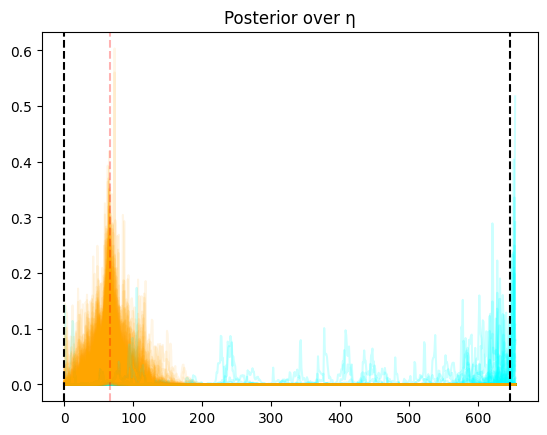

 14%|█▍        | 1/7 [08:44<52:24, 524.12s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9552152893782927


  2%|▏         | 1/50 [00:09<08:08,  9.96s/it]

Estimated coverage:  0.7605725814677748
Constructed credible set with aimed coverage:  0.9652840826877418


  4%|▍         | 2/50 [00:20<08:14, 10.29s/it]

Estimated coverage:  0.8802862906736044
Constructed credible set with aimed coverage:  0.9635213840577328


  6%|▌         | 3/50 [00:30<07:57, 10.17s/it]

Estimated coverage:  0.9201908604490696
Constructed credible set with aimed coverage:  1.0000000000000004


  8%|▊         | 4/50 [00:40<07:50, 10.22s/it]

Estimated coverage:  0.9401431453368022
Constructed credible set with aimed coverage:  0.9531410453153042


 10%|█         | 5/50 [00:50<07:38, 10.18s/it]

Estimated coverage:  0.9521145162694418
Constructed credible set with aimed coverage:  0.9638981077458304


 12%|█▏        | 6/50 [01:01<07:26, 10.15s/it]

Estimated coverage:  0.9600954302244847
Constructed credible set with aimed coverage:  0.9728974427306094


 14%|█▍        | 7/50 [01:11<07:14, 10.11s/it]

Estimated coverage:  0.9657960830495583
Constructed credible set with aimed coverage:  0.9503803810898451


 16%|█▌        | 8/50 [01:20<07:01, 10.04s/it]

Estimated coverage:  0.9700715726683636
Constructed credible set with aimed coverage:  0.9999999999999999


 18%|█▊        | 9/50 [01:30<06:50, 10.02s/it]

Estimated coverage:  0.9733969534829898
Constructed credible set with aimed coverage:  0.972723974639482


 20%|██        | 10/50 [05:08<49:25, 74.15s/it]

Estimated coverage:  0.9760572581346909
Constructed credible set with aimed coverage:  0.9604278034204685


 22%|██▏       | 11/50 [05:50<41:51, 64.40s/it]

Estimated coverage:  0.9782338710315372
Constructed credible set with aimed coverage:  0.96153077114067


 24%|██▍       | 12/50 [06:00<30:16, 47.79s/it]

Estimated coverage:  0.9800477151122418
Constructed credible set with aimed coverage:  0.9607280227591017


 26%|██▌       | 13/50 [06:41<28:05, 45.56s/it]

Estimated coverage:  0.9815825062574539
Constructed credible set with aimed coverage:  0.9519756302494751


 28%|██▊       | 14/50 [06:50<20:50, 34.74s/it]

Estimated coverage:  0.9828980415247787
Constructed credible set with aimed coverage:  0.9540793252785067


 30%|███       | 15/50 [07:14<18:22, 31.51s/it]

Estimated coverage:  0.9840381720897934
Constructed credible set with aimed coverage:  0.9550387567248834


 32%|███▏      | 16/50 [07:24<14:10, 25.00s/it]

Estimated coverage:  0.9850357863341813
Constructed credible set with aimed coverage:  0.9545800356778119


 34%|███▍      | 17/50 [18:37<2:00:49, 219.68s/it]

Estimated coverage:  0.9859160341968766
Constructed credible set with aimed coverage:  0.9583758083496002


 36%|███▌      | 18/50 [18:47<1:23:33, 156.68s/it]

Estimated coverage:  0.9866984767414945
Constructed credible set with aimed coverage:  0.9999999999999999


 38%|███▊      | 19/50 [18:57<58:11, 112.62s/it]  

Estimated coverage:  0.9873985569129948
Constructed credible set with aimed coverage:  1.0000000000000002


 40%|████      | 20/50 [19:07<40:53, 81.77s/it] 

Estimated coverage:  0.988028629067345
Constructed credible set with aimed coverage:  0.9538707924197212


 42%|████▏     | 21/50 [19:16<29:05, 60.18s/it]

Estimated coverage:  0.9885986943498524
Constructed credible set with aimed coverage:  0.9747783148243251


 44%|████▍     | 22/50 [19:26<21:01, 45.07s/it]

Estimated coverage:  0.9891169355157682
Constructed credible set with aimed coverage:  0.9733633224249685


 46%|████▌     | 23/50 [19:36<15:31, 34.49s/it]

Estimated coverage:  0.9895901122324737
Constructed credible set with aimed coverage:  0.95115348895776


 48%|████▊     | 24/50 [19:46<11:43, 27.07s/it]

Estimated coverage:  0.9900238575561207
Constructed credible set with aimed coverage:  0.9613192622039618


 50%|█████     | 25/50 [19:56<09:07, 21.88s/it]

Estimated coverage:  0.9904229032538758
Constructed credible set with aimed coverage:  0.9552126058855761


 52%|█████▏    | 26/50 [20:05<07:17, 18.24s/it]

Estimated coverage:  0.9907912531287267
Constructed credible set with aimed coverage:  0.9695115605278217


 54%|█████▍    | 27/50 [20:15<06:00, 15.69s/it]

Estimated coverage:  0.9911323178276629
Constructed credible set with aimed coverage:  0.9568912131955793


 56%|█████▌    | 28/50 [20:25<05:06, 13.91s/it]

Estimated coverage:  0.9914490207623892
Constructed credible set with aimed coverage:  0.9618494041581866


 58%|█████▊    | 29/50 [20:35<04:25, 12.66s/it]

Estimated coverage:  0.9917438821154104
Constructed credible set with aimed coverage:  0.9642909424648506


 60%|██████    | 30/50 [20:44<03:55, 11.77s/it]

Estimated coverage:  0.9920190860448965
Constructed credible set with aimed coverage:  0.9999999999999999


 62%|██████▏   | 31/50 [20:54<03:32, 11.16s/it]

Estimated coverage:  0.992276534882158
Constructed credible set with aimed coverage:  0.9999999999999996


 64%|██████▍   | 32/50 [21:04<03:13, 10.75s/it]

Estimated coverage:  0.9925178931670905
Constructed credible set with aimed coverage:  0.9999999999999999


 66%|██████▌   | 33/50 [21:14<02:58, 10.49s/it]

Estimated coverage:  0.9927446236771786
Constructed credible set with aimed coverage:  0.960284948461882


 68%|██████▊   | 34/50 [21:24<02:44, 10.29s/it]

Estimated coverage:  0.9929580170984381
Constructed credible set with aimed coverage:  0.9731712151191775


 70%|███████   | 35/50 [21:33<02:32, 10.15s/it]

Estimated coverage:  0.9931592166099114
Constructed credible set with aimed coverage:  0.9624223878222995


 72%|███████▏  | 36/50 [21:43<02:20, 10.06s/it]

Estimated coverage:  0.9933492383707471
Constructed credible set with aimed coverage:  0.9598847483625091


 74%|███████▍  | 37/50 [21:53<02:09,  9.99s/it]

Estimated coverage:  0.9935289886850512
Constructed credible set with aimed coverage:  0.9500154100700139


 76%|███████▌  | 38/50 [22:03<01:59,  9.94s/it]

Estimated coverage:  0.9936992784564973
Constructed credible set with aimed coverage:  0.9500644541512213


 78%|███████▊  | 39/50 [22:13<01:49,  9.91s/it]

Estimated coverage:  0.9938608354191512
Constructed credible set with aimed coverage:  0.959754930358527


 80%|████████  | 40/50 [22:23<01:39,  9.90s/it]

Estimated coverage:  0.9940143145336724
Constructed credible set with aimed coverage:  0.9634192167537321


 82%|████████▏ | 41/50 [22:32<01:28,  9.88s/it]

Estimated coverage:  0.9941603068621193
Constructed credible set with aimed coverage:  0.9523493376636569


 84%|████████▍ | 42/50 [22:42<01:19,  9.88s/it]

Estimated coverage:  0.9942993471749261
Constructed credible set with aimed coverage:  0.9758845549791235


 86%|████████▌ | 43/50 [22:52<01:09,  9.87s/it]

Estimated coverage:  0.9944319204964395
Constructed credible set with aimed coverage:  0.9561558401129041


 88%|████████▊ | 44/50 [23:02<00:59,  9.87s/it]

Estimated coverage:  0.994558467757884
Constructed credible set with aimed coverage:  0.9999999999999998


 90%|█████████ | 45/50 [23:12<00:49,  9.86s/it]

Estimated coverage:  0.9946793906965975
Constructed credible set with aimed coverage:  0.9631606774409136


 92%|█████████▏| 46/50 [23:22<00:39,  9.86s/it]

Estimated coverage:  0.9947950561162366
Constructed credible set with aimed coverage:  0.9519273611365069


 94%|█████████▍| 47/50 [23:32<00:29,  9.86s/it]

Estimated coverage:  0.9949057996031253
Constructed credible set with aimed coverage:  0.959909282091697


 96%|█████████▌| 48/50 [23:41<00:19,  9.87s/it]

Estimated coverage:  0.9950119287780601
Constructed credible set with aimed coverage:  0.9532321182971453


 98%|█████████▊| 49/50 [23:51<00:09,  9.87s/it]

Estimated coverage:  0.9951137261499364
Constructed credible set with aimed coverage:  0.956342256265663


100%|██████████| 50/50 [24:01<00:00, 28.83s/it]

Estimated coverage:  0.9952114516269377


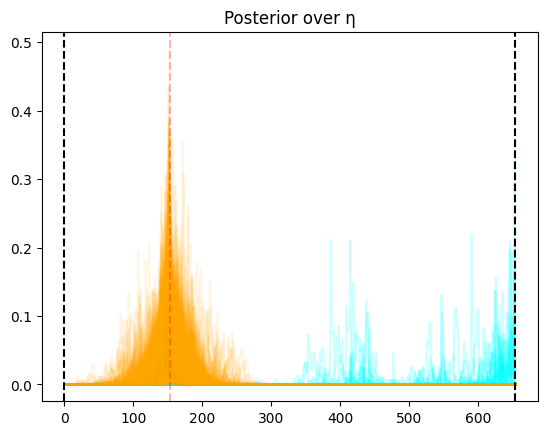

 29%|██▊       | 2/7 [33:13<1:29:59, 1079.92s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9555349484500785


  2%|▏         | 1/50 [00:09<08:06,  9.93s/it]

Estimated coverage:  0.6299173250630948
Constructed credible set with aimed coverage:  0.9649353804394019


  4%|▍         | 2/50 [00:19<07:56,  9.93s/it]

Estimated coverage:  0.8077107351829046
Constructed credible set with aimed coverage:  0.9613482380069392


  6%|▌         | 3/50 [00:29<07:46,  9.93s/it]

Estimated coverage:  0.8718071567886014
Constructed credible set with aimed coverage:  0.9819227626622604


  8%|▊         | 4/50 [00:39<07:36,  9.92s/it]

Estimated coverage:  0.8912430001843485
Constructed credible set with aimed coverage:  0.9630868920555917


 10%|█         | 5/50 [00:49<07:25,  9.91s/it]

Estimated coverage:  0.9115971086019843
Constructed credible set with aimed coverage:  0.9546867940535391


 12%|█▏        | 6/50 [00:59<07:17,  9.93s/it]

Estimated coverage:  0.9263309238349868
Constructed credible set with aimed coverage:  0.9501560577335038


 14%|█▍        | 7/50 [01:09<07:07,  9.94s/it]

Estimated coverage:  0.936855077572846
Constructed credible set with aimed coverage:  0.9548728733512788


 16%|█▌        | 8/50 [01:19<06:57,  9.94s/it]

Estimated coverage:  0.9447481928762391
Constructed credible set with aimed coverage:  0.9598392157463436


 18%|█▊        | 9/50 [01:29<06:47,  9.94s/it]

Estimated coverage:  0.9508872825566571
Constructed credible set with aimed coverage:  0.9588751828116022


 20%|██        | 10/50 [01:39<06:37,  9.95s/it]

Estimated coverage:  0.9557985543009915
Constructed credible set with aimed coverage:  0.9590259197625775


 22%|██▏       | 11/50 [01:49<06:28,  9.96s/it]

Estimated coverage:  0.9598168675463558
Constructed credible set with aimed coverage:  0.9500372756289945


 24%|██▍       | 12/50 [01:59<06:17,  9.93s/it]

Estimated coverage:  0.963134934107534
Constructed credible set with aimed coverage:  0.9517522643433566


 26%|██▌       | 13/50 [02:09<06:07,  9.92s/it]

Estimated coverage:  0.9659706985337522
Constructed credible set with aimed coverage:  0.9575632059279515


 28%|██▊       | 14/50 [02:19<05:57,  9.94s/it]

Estimated coverage:  0.9684013629241985
Constructed credible set with aimed coverage:  0.9500094700168182


 30%|███       | 15/50 [02:29<05:47,  9.94s/it]

Estimated coverage:  0.9705079387292517
Constructed credible set with aimed coverage:  0.9631756980071186


 32%|███▏      | 16/50 [02:38<05:37,  9.93s/it]

Estimated coverage:  0.9723509505382151
Constructed credible set with aimed coverage:  0.9503185653921904


 34%|███▍      | 17/50 [02:48<05:27,  9.92s/it]

Estimated coverage:  0.9739280565664844
Constructed credible set with aimed coverage:  0.9534450567680541


 36%|███▌      | 18/50 [02:58<05:17,  9.91s/it]

Estimated coverage:  0.9753753508578198
Constructed credible set with aimed coverage:  0.9506124823903392


 38%|███▊      | 19/50 [03:08<05:07,  9.92s/it]

Estimated coverage:  0.9766713850231977
Constructed credible set with aimed coverage:  0.9563813988758018


 40%|████      | 20/50 [03:18<04:58,  9.93s/it]

Estimated coverage:  0.9778378157720377
Constructed credible set with aimed coverage:  0.9517017699029162


 42%|████▏     | 21/50 [03:28<04:48,  9.94s/it]

Estimated coverage:  0.978893157878131
Constructed credible set with aimed coverage:  0.9503968845645318


 44%|████▍     | 22/50 [03:38<04:40, 10.01s/it]

Estimated coverage:  0.9798525597927615
Constructed credible set with aimed coverage:  0.9514075212169125


 46%|████▌     | 23/50 [03:48<04:28,  9.95s/it]

Estimated coverage:  0.9770520262827588
Constructed credible set with aimed coverage:  0.9506823412636134


 48%|████▊     | 24/50 [03:58<04:18,  9.93s/it]

Estimated coverage:  0.9780081918543104
Constructed credible set with aimed coverage:  0.9754745848089603


 50%|█████     | 25/50 [04:08<04:07,  9.90s/it]

Estimated coverage:  0.9635620086487091
Constructed credible set with aimed coverage:  0.9544581682823365


 52%|█████▏    | 26/50 [04:18<03:57,  9.89s/it]

Estimated coverage:  0.9649634698545281
Constructed credible set with aimed coverage:  0.9510332867550046


 54%|█████▍    | 27/50 [04:28<03:47,  9.90s/it]

Estimated coverage:  0.9662611191191753
Constructed credible set with aimed coverage:  0.9530432636321169


 56%|█████▌    | 28/50 [04:38<03:38,  9.91s/it]

Estimated coverage:  0.9674660791506325
Constructed credible set with aimed coverage:  0.9510359552663571


 58%|█████▊    | 29/50 [04:47<03:28,  9.92s/it]

Estimated coverage:  0.9685879384902368
Constructed credible set with aimed coverage:  0.9609814099098243


 60%|██████    | 30/50 [04:57<03:18,  9.91s/it]

Estimated coverage:  0.9696349852832914
Constructed credible set with aimed coverage:  0.9613251338551738


 62%|██████▏   | 31/50 [05:07<03:08,  9.93s/it]

Estimated coverage:  0.9706145018870563
Constructed credible set with aimed coverage:  0.9567152267034671


 64%|██████▍   | 32/50 [05:17<02:58,  9.92s/it]

Estimated coverage:  0.9714538980279085
Constructed credible set with aimed coverage:  0.956784505477343


 66%|██████▌   | 33/50 [05:27<02:49,  9.94s/it]

Estimated coverage:  0.9723189314210021
Constructed credible set with aimed coverage:  0.964659488512013


 68%|██████▊   | 34/50 [05:37<02:38,  9.91s/it]

Estimated coverage:  0.9444489194417027
Constructed credible set with aimed coverage:  0.9540286172305108


 70%|███████   | 35/50 [05:47<02:28,  9.91s/it]

Estimated coverage:  0.9457709389610653
Constructed credible set with aimed coverage:  0.9543971744353474


 72%|███████▏  | 36/50 [05:57<02:18,  9.90s/it]

Estimated coverage:  0.9468756144404468
Constructed credible set with aimed coverage:  0.9797531800764345


 74%|███████▍  | 37/50 [06:07<02:09,  9.93s/it]

Estimated coverage:  0.9483114086447592
Constructed credible set with aimed coverage:  0.9502626548707385


 76%|███████▌  | 38/50 [06:17<01:59,  9.93s/it]

Estimated coverage:  0.9495542478221058
Constructed credible set with aimed coverage:  0.9787025532663162


 78%|███████▊  | 39/50 [06:27<01:49,  9.95s/it]

Estimated coverage:  0.9508477286471799
Constructed credible set with aimed coverage:  0.9522147750760175


 80%|████████  | 40/50 [06:37<01:39,  9.97s/it]

Estimated coverage:  0.9520765354310005
Constructed credible set with aimed coverage:  0.9527692642088825


 82%|████████▏ | 41/50 [06:47<01:29,  9.97s/it]

Estimated coverage:  0.953245399753278
Constructed credible set with aimed coverage:  0.9579380614616991


 84%|████████▍ | 42/50 [06:57<01:19,  9.95s/it]

Estimated coverage:  0.9540770774425993
Constructed credible set with aimed coverage:  0.9636290250449826


 86%|████████▌ | 43/50 [07:07<01:09,  9.96s/it]

Estimated coverage:  0.9551450523857947
Constructed credible set with aimed coverage:  0.9577785733438337


 88%|████████▊ | 44/50 [07:17<00:59,  9.96s/it]

Estimated coverage:  0.9561644830133903
Constructed credible set with aimed coverage:  0.9505620072176939


 90%|█████████ | 45/50 [07:27<00:49,  9.96s/it]

Estimated coverage:  0.9571386056130925
Constructed credible set with aimed coverage:  0.9501696926881571


 92%|█████████▏| 46/50 [07:37<00:39,  9.96s/it]

Estimated coverage:  0.9580703750562863
Constructed credible set with aimed coverage:  0.9519675271893693


 94%|█████████▍| 47/50 [07:46<00:29,  9.97s/it]

Estimated coverage:  0.9589624947359399
Constructed credible set with aimed coverage:  0.9525908394732947


 96%|█████████▌| 48/50 [07:56<00:19,  9.94s/it]

Estimated coverage:  0.9575479389998628
Constructed credible set with aimed coverage:  0.9531809175824917


 98%|█████████▊| 49/50 [08:06<00:09,  9.92s/it]

Estimated coverage:  0.9584143074212718
Constructed credible set with aimed coverage:  0.9525394857505481


100%|██████████| 50/50 [08:16<00:00,  9.93s/it]

Estimated coverage:  0.9592460212728445


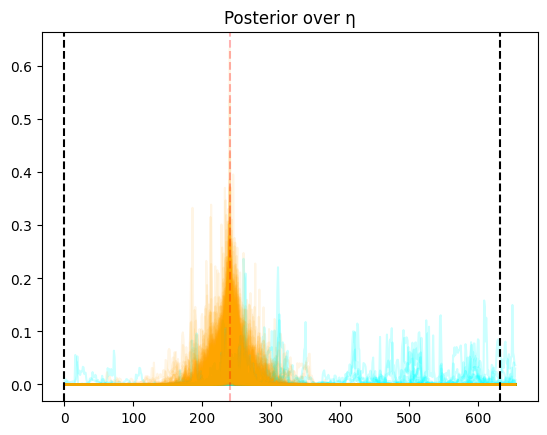

 43%|████▎     | 3/7 [41:51<54:53, 823.30s/it]   

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9504440891545649


  2%|▏         | 1/50 [00:09<08:07,  9.94s/it]

Estimated coverage:  0.982526774292491
Constructed credible set with aimed coverage:  0.9500812733258766


  4%|▍         | 2/50 [00:19<07:57,  9.95s/it]

Estimated coverage:  0.9912633871462444
Constructed credible set with aimed coverage:  0.9564329306942644


  6%|▌         | 3/50 [00:29<07:46,  9.93s/it]

Estimated coverage:  0.6653661993983501
Constructed credible set with aimed coverage:  0.9569227641839432


  8%|▊         | 4/50 [00:39<07:35,  9.90s/it]

Estimated coverage:  0.525687444237519
Constructed credible set with aimed coverage:  0.9574466318322179


 10%|█         | 5/50 [00:49<07:23,  9.87s/it]

Estimated coverage:  0.4205499553900152
Constructed credible set with aimed coverage:  0.9504392448317863


 12%|█▏        | 6/50 [00:59<07:15,  9.89s/it]

Estimated coverage:  0.5171249628250126
Constructed credible set with aimed coverage:  0.9949748844034081


 14%|█▍        | 7/50 [01:09<07:04,  9.87s/it]

Estimated coverage:  0.44324996813744194
Constructed credible set with aimed coverage:  0.9525763593891463


 16%|█▌        | 8/50 [01:19<06:55,  9.89s/it]

Estimated coverage:  0.5128437221202614
Constructed credible set with aimed coverage:  0.9505832409380438


 18%|█▊        | 9/50 [01:28<06:44,  9.86s/it]

Estimated coverage:  0.4558610863291292
Constructed credible set with aimed coverage:  0.9556044250608738


 20%|██        | 10/50 [01:38<06:33,  9.84s/it]

Estimated coverage:  0.4102749776962562
Constructed credible set with aimed coverage:  0.9559607158178539


 22%|██▏       | 11/50 [01:48<06:23,  9.83s/it]

Estimated coverage:  0.37297725245235636
Constructed credible set with aimed coverage:  0.9585353138288921


 24%|██▍       | 12/50 [01:58<06:14,  9.86s/it]

Estimated coverage:  0.4252291480813266
Constructed credible set with aimed coverage:  0.9524062172062709


 26%|██▌       | 13/50 [02:08<06:05,  9.87s/it]

Estimated coverage:  0.3925192136135761
Constructed credible set with aimed coverage:  0.9999999999999997


 28%|██▊       | 14/50 [02:18<05:56,  9.91s/it]

Estimated coverage:  0.43591069835546353
Constructed credible set with aimed coverage:  0.9605072932303005


 30%|███       | 15/50 [02:28<05:48,  9.95s/it]

Estimated coverage:  0.473516651796704
Constructed credible set with aimed coverage:  0.9607950204632896


 32%|███▏      | 16/50 [02:38<05:37,  9.92s/it]

Estimated coverage:  0.44392186105941006
Constructed credible set with aimed coverage:  0.9506672970788721


 34%|███▍      | 17/50 [02:48<05:28,  9.94s/it]

Estimated coverage:  0.47663233982062125
Constructed credible set with aimed coverage:  0.9586689271595777


 36%|███▌      | 18/50 [02:58<05:18,  9.96s/it]

Estimated coverage:  0.5057083209416978
Constructed credible set with aimed coverage:  0.9745597628423599


 38%|███▊      | 19/50 [03:08<05:08,  9.94s/it]

Estimated coverage:  0.5315734841211376
Constructed credible set with aimed coverage:  0.9560444660375987


 40%|████      | 20/50 [03:18<04:58,  9.96s/it]

Estimated coverage:  0.5549948099129289
Constructed credible set with aimed coverage:  0.970072659383415


 42%|████▏     | 21/50 [03:28<04:49,  9.97s/it]

Estimated coverage:  0.5761855332504087
Constructed credible set with aimed coverage:  0.9512695412804191


 44%|████▍     | 22/50 [03:38<04:38,  9.96s/it]

Estimated coverage:  0.593530072321978
Constructed credible set with aimed coverage:  0.9530073423039043


 46%|████▌     | 23/50 [03:48<04:29,  9.98s/it]

Estimated coverage:  0.6112026778731963
Constructed credible set with aimed coverage:  0.9509112697681708


 48%|████▊     | 24/50 [03:57<04:18,  9.94s/it]

Estimated coverage:  0.5857358996284815
Constructed credible set with aimed coverage:  0.9503854653539202


 50%|█████     | 25/50 [04:07<04:08,  9.93s/it]

Estimated coverage:  0.5636047489290288
Constructed credible set with aimed coverage:  0.9521246309664428


 52%|█████▏    | 26/50 [04:17<03:58,  9.92s/it]

Estimated coverage:  0.5419283364588492
Constructed credible set with aimed coverage:  0.9631232542656047


 54%|█████▍    | 27/50 [04:27<03:48,  9.94s/it]

Estimated coverage:  0.55889395362704
Constructed credible set with aimed coverage:  0.962988280556657


 56%|█████▌    | 28/50 [04:37<03:38,  9.92s/it]

Estimated coverage:  0.5656768887598544
Constructed credible set with aimed coverage:  1.0000000000000004


 58%|█████▊    | 29/50 [04:47<03:28,  9.94s/it]

Estimated coverage:  0.5806535477681354
Constructed credible set with aimed coverage:  0.9558680653704269


 60%|██████    | 30/50 [04:57<03:18,  9.91s/it]

Estimated coverage:  0.5613071325697309
Constructed credible set with aimed coverage:  0.950469601621782


 62%|██████▏   | 31/50 [05:07<03:08,  9.94s/it]

Estimated coverage:  0.5754585153900621
Constructed credible set with aimed coverage:  0.9565069596146483


 64%|██████▍   | 32/50 [05:17<02:58,  9.91s/it]

Estimated coverage:  0.5574754367841226
Constructed credible set with aimed coverage:  0.9507765125346626


 66%|██████▌   | 33/50 [05:27<02:48,  9.90s/it]

Estimated coverage:  0.5410183247135111
Constructed credible set with aimed coverage:  0.950246218405501


 68%|██████▊   | 34/50 [05:37<02:38,  9.88s/it]

Estimated coverage:  0.5251060210454676
Constructed credible set with aimed coverage:  0.95386666927661


 70%|███████   | 35/50 [05:46<02:28,  9.88s/it]

Estimated coverage:  0.5101031551130284
Constructed credible set with aimed coverage:  0.957975950693176


 72%|███████▏  | 36/50 [05:56<02:18,  9.90s/it]

Estimated coverage:  0.5237114006125668
Constructed credible set with aimed coverage:  0.9557194406882794


 74%|███████▍  | 37/50 [06:06<02:08,  9.91s/it]

Estimated coverage:  0.5365840654400431
Constructed credible set with aimed coverage:  0.9561962688726509


 76%|███████▌  | 38/50 [06:16<01:58,  9.89s/it]

Estimated coverage:  0.5224634321389898
Constructed credible set with aimed coverage:  0.9622593375733073


 78%|███████▊  | 39/50 [06:26<01:48,  9.90s/it]

Estimated coverage:  0.5347079529625189
Constructed credible set with aimed coverage:  0.9509335074842347


 80%|████████  | 40/50 [06:36<01:39,  9.90s/it]

Estimated coverage:  0.5213424922641894
Constructed credible set with aimed coverage:  0.9747706094176823


 82%|████████▏ | 41/50 [06:46<01:29,  9.92s/it]

Estimated coverage:  0.533017065614084
Constructed credible set with aimed coverage:  0.9623492561167304


 84%|████████▍ | 42/50 [06:56<01:19,  9.90s/it]

Estimated coverage:  0.5203310194881381
Constructed credible set with aimed coverage:  0.9530100191535009


 86%|████████▌ | 43/50 [07:06<01:09,  9.91s/it]

Estimated coverage:  0.5314861120581814
Constructed credible set with aimed coverage:  0.9513036281610074


 88%|████████▊ | 44/50 [07:15<00:59,  9.87s/it]

Estimated coverage:  0.5194068822386866
Constructed credible set with aimed coverage:  0.9549740992970825


 90%|█████████ | 45/50 [07:25<00:49,  9.88s/it]

Estimated coverage:  0.5297473363135629
Constructed credible set with aimed coverage:  0.9501344430251898


 92%|█████████▏| 46/50 [07:35<00:39,  9.86s/it]

Estimated coverage:  0.5182310898719636
Constructed credible set with aimed coverage:  0.9999999999999998


 94%|█████████▍| 47/50 [07:45<00:29,  9.88s/it]

Estimated coverage:  0.5284814922151133
Constructed credible set with aimed coverage:  0.9508997026674946


 96%|█████████▌| 48/50 [07:55<00:19,  9.96s/it]

Estimated coverage:  0.5383047944386037
Constructed credible set with aimed coverage:  0.9666850812249586


 98%|█████████▊| 49/50 [08:05<00:09,  9.93s/it]

Estimated coverage:  0.5276743781649655
Constructed credible set with aimed coverage:  0.9515203874440836


100%|██████████| 50/50 [08:15<00:00,  9.91s/it]

Estimated coverage:  0.534651307764827


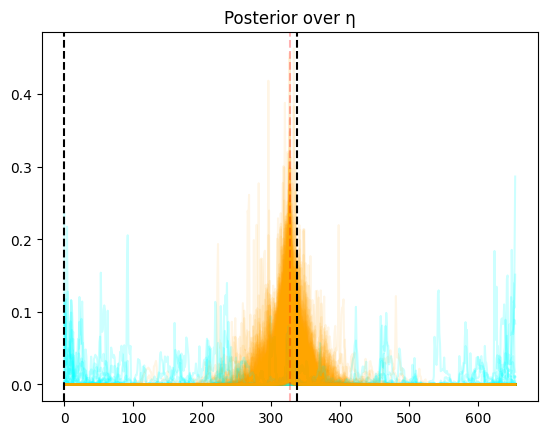

 57%|█████▋    | 4/7 [50:27<35:06, 702.29s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9532767078434936


  2%|▏         | 1/50 [00:09<08:04,  9.89s/it]

Estimated coverage:  0.9026649942851822
Constructed credible set with aimed coverage:  0.9547287514093952


  4%|▍         | 2/50 [00:19<07:55,  9.91s/it]

Estimated coverage:  0.9508745761407473
Constructed credible set with aimed coverage:  0.9548637518026719


  6%|▌         | 3/50 [00:29<07:45,  9.91s/it]

Estimated coverage:  0.9672496750594326
Constructed credible set with aimed coverage:  0.9504951509887243


  8%|▊         | 4/50 [00:39<07:35,  9.89s/it]

Estimated coverage:  0.7254373242759271
Constructed credible set with aimed coverage:  0.9511612399911794


 10%|█         | 5/50 [00:49<07:25,  9.90s/it]

Estimated coverage:  0.780349777080014
Constructed credible set with aimed coverage:  0.9530390832061137


 12%|█▏        | 6/50 [00:59<07:15,  9.90s/it]

Estimated coverage:  0.8169581443056496
Constructed credible set with aimed coverage:  0.9514915520239262


 14%|█▍        | 7/50 [01:09<07:06,  9.92s/it]

Estimated coverage:  0.8431017286782865
Constructed credible set with aimed coverage:  0.9526238349203753


 16%|█▌        | 8/50 [01:19<06:55,  9.88s/it]

Estimated coverage:  0.7377140125935009
Constructed credible set with aimed coverage:  0.9537902806758782


 18%|█▊        | 9/50 [01:29<06:46,  9.90s/it]

Estimated coverage:  0.7668568996641997
Constructed credible set with aimed coverage:  0.9585034909979537


 20%|██        | 10/50 [01:39<06:36,  9.91s/it]

Estimated coverage:  0.7807995220138774
Constructed credible set with aimed coverage:  0.9622278638502714


 22%|██▏       | 11/50 [01:48<06:26,  9.90s/it]

Estimated coverage:  0.7098177472853436
Constructed credible set with aimed coverage:  0.9511752787732077


 24%|██▍       | 12/50 [01:58<06:16,  9.91s/it]

Estimated coverage:  0.6506663196974015
Constructed credible set with aimed coverage:  0.9655869695407497


 26%|██▌       | 13/50 [02:08<06:07,  9.94s/it]

Estimated coverage:  0.6775381412591386
Constructed credible set with aimed coverage:  0.9514365545832797


 28%|██▊       | 14/50 [02:18<05:59,  9.98s/it]

Estimated coverage:  0.7005711311686155
Constructed credible set with aimed coverage:  0.9502267695812823


 30%|███       | 15/50 [02:28<05:49,  9.99s/it]

Estimated coverage:  0.720532535066056
Constructed credible set with aimed coverage:  0.9512383778496569


 32%|███▏      | 16/50 [02:38<05:38,  9.97s/it]

Estimated coverage:  0.7379937921570269
Constructed credible set with aimed coverage:  0.9516354976074459


 34%|███▍      | 17/50 [02:48<05:27,  9.91s/it]

Estimated coverage:  0.6945823926183784
Constructed credible set with aimed coverage:  0.9591246985441784


 36%|███▌      | 18/50 [02:58<05:15,  9.87s/it]

Estimated coverage:  0.6559944913228891
Constructed credible set with aimed coverage:  0.9521262322509968


 38%|███▊      | 19/50 [03:08<05:04,  9.83s/it]

Estimated coverage:  0.6214684654639615
Constructed credible set with aimed coverage:  0.9541627643007844


 40%|████      | 20/50 [03:17<04:53,  9.79s/it]

Estimated coverage:  0.5903950421907634
Constructed credible set with aimed coverage:  0.954818322389259


 42%|████▏     | 21/50 [03:27<04:42,  9.76s/it]

Estimated coverage:  0.5622809925626319
Constructed credible set with aimed coverage:  0.9507964992510711


 44%|████▍     | 22/50 [03:37<04:33,  9.76s/it]

Estimated coverage:  0.5820991634257778
Constructed credible set with aimed coverage:  0.9553223306738051


 46%|████▌     | 23/50 [03:46<04:22,  9.74s/it]

Estimated coverage:  0.5567905041463963
Constructed credible set with aimed coverage:  0.9509027004089163


 48%|████▊     | 24/50 [03:56<04:13,  9.74s/it]

Estimated coverage:  0.5335909041897614
Constructed credible set with aimed coverage:  0.9500108117570225


 50%|█████     | 25/50 [04:06<04:02,  9.72s/it]

Estimated coverage:  0.512247268022171
Constructed credible set with aimed coverage:  0.950382206777953


 52%|█████▏    | 26/50 [04:16<03:53,  9.74s/it]

Estimated coverage:  0.528109069502953
Constructed credible set with aimed coverage:  0.9790695011631827


 54%|█████▍    | 27/50 [04:25<03:43,  9.71s/it]

Estimated coverage:  0.5085494743361769
Constructed credible set with aimed coverage:  0.9665618706764424


 56%|█████▌    | 28/50 [04:35<03:33,  9.73s/it]

Estimated coverage:  0.5259623720410177
Constructed credible set with aimed coverage:  0.953929152561337


 58%|█████▊    | 29/50 [04:45<03:24,  9.72s/it]

Estimated coverage:  0.5422552268581934
Constructed credible set with aimed coverage:  0.9547025902472265


 60%|██████    | 30/50 [04:55<03:14,  9.71s/it]

Estimated coverage:  0.5241800526295874
Constructed credible set with aimed coverage:  0.9505710206264032


 62%|██████▏   | 31/50 [05:04<03:04,  9.74s/it]

Estimated coverage:  0.5072787564361624
Constructed credible set with aimed coverage:  0.9515442654478921


 64%|██████▍   | 32/50 [05:14<02:55,  9.75s/it]

Estimated coverage:  0.4914262952993913
Constructed credible set with aimed coverage:  0.950998330355439


 66%|██████▌   | 33/50 [05:24<02:45,  9.75s/it]

Estimated coverage:  0.476534635725448
Constructed credible set with aimed coverage:  0.9506055403028737


 68%|██████▊   | 34/50 [05:34<02:36,  9.77s/it]

Estimated coverage:  0.4625189111941599
Constructed credible set with aimed coverage:  0.9665729929970933


 70%|███████   | 35/50 [05:43<02:26,  9.77s/it]

Estimated coverage:  0.44930408516004094
Constructed credible set with aimed coverage:  0.9529645141672275


 72%|███████▏  | 36/50 [05:53<02:16,  9.77s/it]

Estimated coverage:  0.4368234161278177
Constructed credible set with aimed coverage:  0.9801843847790723


 74%|███████▍  | 37/50 [06:03<02:07,  9.83s/it]

Estimated coverage:  0.452044404881067
Constructed credible set with aimed coverage:  0.9584315893530256


 76%|███████▌  | 38/50 [06:13<01:58,  9.85s/it]

Estimated coverage:  0.4401485182312955
Constructed credible set with aimed coverage:  0.9546725248009702


 78%|███████▊  | 39/50 [06:23<01:48,  9.85s/it]

Estimated coverage:  0.42886265879046154
Constructed credible set with aimed coverage:  0.9533905307723131


 80%|████████  | 40/50 [06:33<01:38,  9.87s/it]

Estimated coverage:  0.418141094300958
Constructed credible set with aimed coverage:  0.9539233357204662


 82%|████████▏ | 41/50 [06:43<01:28,  9.86s/it]

Estimated coverage:  0.4079425310253249
Constructed credible set with aimed coverage:  0.9596019483683805


 84%|████████▍ | 42/50 [06:53<01:19,  9.89s/it]

Estimated coverage:  0.4220391371529895
Constructed credible set with aimed coverage:  0.9502847447863881


 86%|████████▌ | 43/50 [07:02<01:09,  9.86s/it]

Estimated coverage:  0.41222427349826885
Constructed credible set with aimed coverage:  0.9544240262136386


 88%|████████▊ | 44/50 [07:12<00:59,  9.89s/it]

Estimated coverage:  0.42558281250450697
Constructed credible set with aimed coverage:  0.9658644694832893


 90%|█████████ | 45/50 [07:22<00:49,  9.89s/it]

Estimated coverage:  0.4161273324341767
Constructed credible set with aimed coverage:  0.9507929898942925


 92%|█████████▏| 46/50 [07:32<00:39,  9.91s/it]

Estimated coverage:  0.42881576121782966
Constructed credible set with aimed coverage:  0.9755397710789635


 94%|█████████▍| 47/50 [07:42<00:29,  9.89s/it]

Estimated coverage:  0.41969202161840247
Constructed credible set with aimed coverage:  0.9640166156203278


 96%|█████████▌| 48/50 [07:52<00:19,  9.87s/it]

Estimated coverage:  0.41094843783468576
Constructed credible set with aimed coverage:  0.9744505694594897


 98%|█████████▊| 49/50 [08:02<00:09,  9.90s/it]

Estimated coverage:  0.4229698982112403
Constructed credible set with aimed coverage:  0.9612570115220791


100%|██████████| 50/50 [08:12<00:00,  9.84s/it]

Estimated coverage:  0.4145105013257557


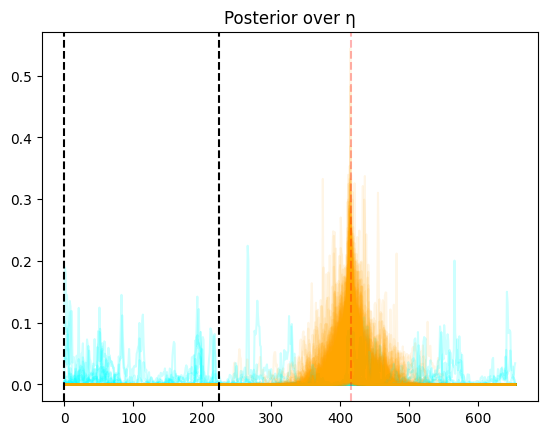

 71%|███████▏  | 5/7 [59:00<21:08, 634.09s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.962839172008818


  2%|▏         | 1/50 [00:09<08:09,  9.99s/it]

Estimated coverage:  0.7113721543456982
Constructed credible set with aimed coverage:  0.9530479170683839


  4%|▍         | 2/50 [00:19<07:57,  9.95s/it]

Estimated coverage:  0.40080753319654633
Constructed credible set with aimed coverage:  0.9512064285513725


  6%|▌         | 3/50 [00:29<07:44,  9.88s/it]

Estimated coverage:  0.26720502213103087
Constructed credible set with aimed coverage:  0.9626222569749124


  8%|▊         | 4/50 [00:39<07:36,  9.93s/it]

Estimated coverage:  0.45040376020717104
Constructed credible set with aimed coverage:  0.9508509625066639


 10%|█         | 5/50 [00:49<07:24,  9.87s/it]

Estimated coverage:  0.3603230081657368
Constructed credible set with aimed coverage:  0.9523828801887277


 12%|█▏        | 6/50 [00:59<07:13,  9.85s/it]

Estimated coverage:  0.3002691734714474
Constructed credible set with aimed coverage:  0.9551828375454119


 14%|█▍        | 7/50 [01:09<07:03,  9.85s/it]

Estimated coverage:  0.2573735772612406
Constructed credible set with aimed coverage:  0.9611942042799337


 16%|█▌        | 8/50 [01:19<06:55,  9.88s/it]

Estimated coverage:  0.3490244846572213
Constructed credible set with aimed coverage:  0.9555683372021082


 18%|█▊        | 9/50 [01:28<06:44,  9.86s/it]

Estimated coverage:  0.3102439863619745
Constructed credible set with aimed coverage:  0.9534824850434249


 20%|██        | 10/50 [01:38<06:34,  9.86s/it]

Estimated coverage:  0.27921958772577704
Constructed credible set with aimed coverage:  0.9555475801325809


 22%|██▏       | 11/50 [01:48<06:23,  9.84s/it]

Estimated coverage:  0.2538359888416155
Constructed credible set with aimed coverage:  0.9508680633433209


 24%|██▍       | 12/50 [01:58<06:14,  9.85s/it]

Estimated coverage:  0.2326829897714894
Constructed credible set with aimed coverage:  0.9684384253217156


 26%|██▌       | 13/50 [02:08<06:05,  9.89s/it]

Estimated coverage:  0.291707375120084
Constructed credible set with aimed coverage:  0.9508310939247171


 28%|██▊       | 14/50 [02:18<05:57,  9.92s/it]

Estimated coverage:  0.3422997032788773
Constructed credible set with aimed coverage:  0.9505971542358345


 30%|███       | 15/50 [02:28<05:46,  9.90s/it]

Estimated coverage:  0.3194800487052319
Constructed credible set with aimed coverage:  0.9593024431317785


 32%|███▏      | 16/50 [02:38<05:37,  9.91s/it]

Estimated coverage:  0.361998069767478
Constructed credible set with aimed coverage:  0.9500286782545116


 34%|███▍      | 17/50 [02:48<05:26,  9.91s/it]

Estimated coverage:  0.3407044885612448
Constructed credible set with aimed coverage:  0.9503245679446523


 36%|███▌      | 18/50 [02:57<05:16,  9.88s/it]

Estimated coverage:  0.32177646141895333
Constructed credible set with aimed coverage:  0.9562487815614166


 38%|███▊      | 19/50 [03:07<05:05,  9.87s/it]

Estimated coverage:  0.3048408581863769
Constructed credible set with aimed coverage:  0.9500968351463448


 40%|████      | 20/50 [03:17<04:56,  9.88s/it]

Estimated coverage:  0.28959888673377904
Constructed credible set with aimed coverage:  0.9572188349880696


 42%|████▏     | 21/50 [03:27<04:45,  9.85s/it]

Estimated coverage:  0.27580846355598
Constructed credible set with aimed coverage:  0.9763429333886531


 44%|████▍     | 22/50 [03:37<04:35,  9.84s/it]

Estimated coverage:  0.26327171521252635
Constructed credible set with aimed coverage:  0.9623547831173291


 46%|████▌     | 23/50 [03:47<04:25,  9.85s/it]

Estimated coverage:  0.25182511891973014
Constructed credible set with aimed coverage:  0.9524087985750469


 48%|████▊     | 24/50 [03:57<04:18,  9.92s/it]

Estimated coverage:  0.24133240563140806
Constructed credible set with aimed coverage:  0.9558717353253483


 50%|█████     | 25/50 [04:07<04:07,  9.92s/it]

Estimated coverage:  0.27157087677800434
Constructed credible set with aimed coverage:  0.9620017766827298


 52%|█████▏    | 26/50 [04:16<03:57,  9.90s/it]

Estimated coverage:  0.2611258430711459
Constructed credible set with aimed coverage:  0.9686314997979065


 54%|█████▍    | 27/50 [04:26<03:47,  9.87s/it]

Estimated coverage:  0.25145451554999243
Constructed credible set with aimed coverage:  0.9564836840995041


 56%|█████▌    | 28/50 [04:36<03:37,  9.88s/it]

Estimated coverage:  0.24521316170804694
Constructed credible set with aimed coverage:  0.9624066560019301


 58%|█████▊    | 29/50 [04:46<03:26,  9.86s/it]

Estimated coverage:  0.2367575354422522
Constructed credible set with aimed coverage:  0.9615092533994727


 60%|██████    | 30/50 [04:56<03:16,  9.84s/it]

Estimated coverage:  0.22886561759417715
Constructed credible set with aimed coverage:  0.9666230489233193


 62%|██████▏   | 31/50 [05:06<03:06,  9.82s/it]

Estimated coverage:  0.2214828557363005
Constructed credible set with aimed coverage:  0.9573137938912045


 64%|██████▍   | 32/50 [05:15<02:56,  9.81s/it]

Estimated coverage:  0.21456151649454105
Constructed credible set with aimed coverage:  0.9502937115033087


 66%|██████▌   | 33/50 [05:25<02:46,  9.81s/it]

Estimated coverage:  0.20805965235834284
Constructed credible set with aimed coverage:  0.952976786491735


 68%|██████▊   | 34/50 [05:35<02:37,  9.85s/it]

Estimated coverage:  0.20761499481572812
Constructed credible set with aimed coverage:  0.9580553337645914


 70%|███████   | 35/50 [05:45<02:27,  9.85s/it]

Estimated coverage:  0.20168313782099304
Constructed credible set with aimed coverage:  0.9517586022752366


 72%|███████▏  | 36/50 [05:55<02:18,  9.89s/it]

Estimated coverage:  0.22382298314637525
Constructed credible set with aimed coverage:  0.9718353216999984


 74%|███████▍  | 37/50 [06:05<02:08,  9.89s/it]

Estimated coverage:  0.21777371333160833
Constructed credible set with aimed coverage:  0.9513588243460552


 76%|███████▌  | 38/50 [06:15<01:58,  9.88s/it]

Estimated coverage:  0.21204282613867131
Constructed credible set with aimed coverage:  0.951069291496452


 78%|███████▊  | 39/50 [06:24<01:48,  9.85s/it]

Estimated coverage:  0.20660583059665408
Constructed credible set with aimed coverage:  0.9510188155311146


 80%|████████  | 40/50 [06:34<01:38,  9.84s/it]

Estimated coverage:  0.20144068483173772
Constructed credible set with aimed coverage:  0.951633876206738


 82%|████████▏ | 41/50 [06:44<01:28,  9.87s/it]

Estimated coverage:  0.22058923320276008
Constructed credible set with aimed coverage:  0.955046031127215


 84%|████████▍ | 42/50 [06:54<01:18,  9.86s/it]

Estimated coverage:  0.21533710860269437
Constructed credible set with aimed coverage:  0.953832665374555


 86%|████████▌ | 43/50 [07:04<01:08,  9.84s/it]

Estimated coverage:  0.21032926886774794
Constructed credible set with aimed coverage:  0.9718397481815244


 88%|████████▊ | 44/50 [07:14<00:59,  9.84s/it]

Estimated coverage:  0.2055490582116628
Constructed credible set with aimed coverage:  0.9999999999999996


 90%|█████████ | 45/50 [07:24<00:49,  9.86s/it]

Estimated coverage:  0.22320352358473694
Constructed credible set with aimed coverage:  0.9500902437659817


 92%|█████████▏| 46/50 [07:33<00:39,  9.85s/it]

Estimated coverage:  0.2183512730720253
Constructed credible set with aimed coverage:  0.9527175162367996


 94%|█████████▍| 47/50 [07:43<00:29,  9.84s/it]

Estimated coverage:  0.2137055013045354
Constructed credible set with aimed coverage:  0.9731785801485366


 96%|█████████▌| 48/50 [07:53<00:19,  9.83s/it]

Estimated coverage:  0.2092533033606909
Constructed credible set with aimed coverage:  0.9557702683414735


 98%|█████████▊| 49/50 [08:03<00:09,  9.84s/it]

Estimated coverage:  0.2049828277819013
Constructed credible set with aimed coverage:  0.9602586871794991


100%|██████████| 50/50 [08:13<00:00,  9.87s/it]

Estimated coverage:  0.20088317122626326


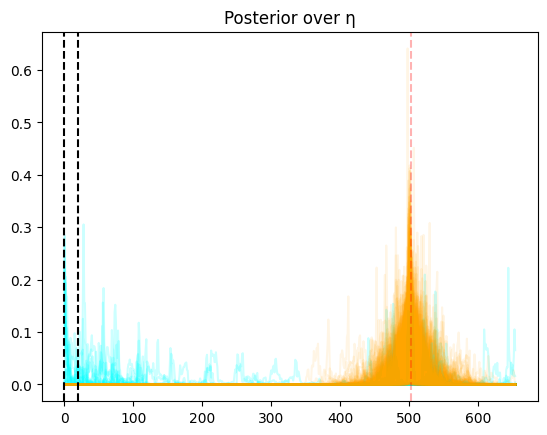

 86%|████████▌ | 6/7 [1:07:35<09:53, 593.52s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9543990041805266


  2%|▏         | 1/50 [00:09<08:08,  9.97s/it]

Estimated coverage:  0.9998873003639487
Constructed credible set with aimed coverage:  0.9587431155994961


  4%|▍         | 2/50 [00:19<07:52,  9.85s/it]

Estimated coverage:  0.4999436501819744
Constructed credible set with aimed coverage:  0.9571738937600873


  6%|▌         | 3/50 [00:29<07:42,  9.83s/it]

Estimated coverage:  0.33329576678798295
Constructed credible set with aimed coverage:  0.9527344242571424


  8%|▊         | 4/50 [00:39<07:32,  9.83s/it]

Estimated coverage:  0.2499718250909872
Constructed credible set with aimed coverage:  0.952831062525755


 10%|█         | 5/50 [00:49<07:21,  9.82s/it]

Estimated coverage:  0.19997746007278977
Constructed credible set with aimed coverage:  1.0


 12%|█▏        | 6/50 [00:59<07:14,  9.87s/it]

Estimated coverage:  0.33331455006065813
Constructed credible set with aimed coverage:  0.9561142323308576


 14%|█▍        | 7/50 [01:08<07:04,  9.86s/it]

Estimated coverage:  0.2856981857662784
Constructed credible set with aimed coverage:  0.9626577518637299


 16%|█▌        | 8/50 [01:18<06:53,  9.85s/it]

Estimated coverage:  0.2499859125454936
Constructed credible set with aimed coverage:  0.9533016116606108


 18%|█▊        | 9/50 [01:28<06:43,  9.84s/it]

Estimated coverage:  0.22220970004043877
Constructed credible set with aimed coverage:  0.9558959372702107


 20%|██        | 10/50 [01:38<06:34,  9.85s/it]

Estimated coverage:  0.1999887300363949
Constructed credible set with aimed coverage:  0.9661451101842001


 22%|██▏       | 11/50 [01:48<06:23,  9.84s/it]

Estimated coverage:  0.18180793639672263
Constructed credible set with aimed coverage:  0.9532753791672133


 24%|██▍       | 12/50 [01:58<06:13,  9.83s/it]

Estimated coverage:  0.16665727503032907
Constructed credible set with aimed coverage:  0.9501911632111261


 26%|██▌       | 13/50 [02:07<06:03,  9.82s/it]

Estimated coverage:  0.15383748464338068
Constructed credible set with aimed coverage:  0.9681097043435252


 28%|██▊       | 14/50 [02:17<05:52,  9.79s/it]

Estimated coverage:  0.1428490928831392
Constructed credible set with aimed coverage:  0.9537221489091225


 30%|███       | 15/50 [02:27<05:41,  9.75s/it]

Estimated coverage:  0.13332582002426327
Constructed credible set with aimed coverage:  0.9529455579673289


 32%|███▏      | 16/50 [02:37<05:31,  9.75s/it]

Estimated coverage:  0.1249929562727468
Constructed credible set with aimed coverage:  0.9640086962941428


 34%|███▍      | 17/50 [02:46<05:20,  9.73s/it]

Estimated coverage:  0.11764042943317346
Constructed credible set with aimed coverage:  0.9510855189162324


 36%|███▌      | 18/50 [02:56<05:12,  9.76s/it]

Estimated coverage:  0.11110701585604707
Constructed credible set with aimed coverage:  0.9501770201236232


 38%|███▊      | 19/50 [03:06<05:01,  9.72s/it]

Estimated coverage:  0.10525927817941302
Constructed credible set with aimed coverage:  0.959609573986379


 40%|████      | 20/50 [03:15<04:51,  9.70s/it]

Estimated coverage:  0.09999631427044237
Constructed credible set with aimed coverage:  0.9545448759335733


 42%|████▏     | 21/50 [03:25<04:40,  9.68s/it]

Estimated coverage:  0.09523458501946892
Constructed credible set with aimed coverage:  0.958796418999112


 44%|████▍     | 22/50 [03:35<04:31,  9.68s/it]

Estimated coverage:  0.0909057402458567
Constructed credible set with aimed coverage:  0.9612214003803965


 46%|████▌     | 23/50 [03:44<04:20,  9.66s/it]

Estimated coverage:  0.0869533167569064
Constructed credible set with aimed coverage:  0.9508033954869494


 48%|████▊     | 24/50 [03:54<04:10,  9.64s/it]

Estimated coverage:  0.08333026189203531
Constructed credible set with aimed coverage:  0.9605611343515543


 50%|█████     | 25/50 [04:03<04:00,  9.63s/it]

Estimated coverage:  0.0799970514163539
Constructed credible set with aimed coverage:  0.9505089405810855


 52%|█████▏    | 26/50 [04:13<03:52,  9.67s/it]

Estimated coverage:  0.07692024174649413
Constructed credible set with aimed coverage:  0.9841417220820925


 54%|█████▍    | 27/50 [04:23<03:42,  9.66s/it]

Estimated coverage:  0.07407134390403139
Constructed credible set with aimed coverage:  0.9706892623329482


 56%|█████▌    | 28/50 [04:33<03:32,  9.65s/it]

Estimated coverage:  0.0714259387646017
Constructed credible set with aimed coverage:  0.954080345397708


 58%|█████▊    | 29/50 [04:42<03:23,  9.70s/it]

Estimated coverage:  0.06896297535931027
Constructed credible set with aimed coverage:  0.9798274990872031


 60%|██████    | 30/50 [04:52<03:14,  9.71s/it]

Estimated coverage:  0.06666420951399993
Constructed credible set with aimed coverage:  0.9735263001490582


 62%|██████▏   | 31/50 [05:02<03:05,  9.74s/it]

Estimated coverage:  0.06451375114258058
Constructed credible set with aimed coverage:  0.9524581804644606


 64%|██████▍   | 32/50 [05:12<02:55,  9.75s/it]

Estimated coverage:  0.06249769641937493
Constructed credible set with aimed coverage:  0.9609771727753308


 66%|██████▌   | 33/50 [05:21<02:45,  9.75s/it]

Estimated coverage:  0.06060382683090902
Constructed credible set with aimed coverage:  0.9582284811050948


 68%|██████▊   | 34/50 [05:31<02:36,  9.76s/it]

Estimated coverage:  0.05882136133588229
Constructed credible set with aimed coverage:  0.9609131437885108


 70%|███████   | 35/50 [05:41<02:26,  9.76s/it]

Estimated coverage:  0.05714075101199994
Constructed credible set with aimed coverage:  0.9506913002653381


 72%|███████▏  | 36/50 [05:51<02:16,  9.78s/it]

Estimated coverage:  0.05555350792833328
Constructed credible set with aimed coverage:  0.9522947347065376


 74%|███████▍  | 37/50 [06:01<02:07,  9.78s/it]

Estimated coverage:  0.05405206176810805
Constructed credible set with aimed coverage:  0.9658759988808773


 76%|███████▌  | 38/50 [06:11<01:58,  9.84s/it]

Estimated coverage:  0.05809647441213739
Constructed credible set with aimed coverage:  0.9527566729527498


 78%|███████▊  | 39/50 [06:20<01:48,  9.84s/it]

Estimated coverage:  0.05660682122208258
Constructed credible set with aimed coverage:  0.9520859610894286


 80%|████████  | 40/50 [06:30<01:38,  9.85s/it]

Estimated coverage:  0.05519165069153052
Constructed credible set with aimed coverage:  0.9641800901004416


 82%|████████▏ | 41/50 [06:40<01:28,  9.86s/it]

Estimated coverage:  0.0538455137968531
Constructed credible set with aimed coverage:  0.9502166487629649


 84%|████████▍ | 42/50 [06:50<01:19,  9.88s/it]

Estimated coverage:  0.055161974346460904
Constructed credible set with aimed coverage:  0.9522505425786282


 86%|████████▌ | 43/50 [07:00<01:08,  9.85s/it]

Estimated coverage:  0.05387913773375251
Constructed credible set with aimed coverage:  0.9522813906636036


 88%|████████▊ | 44/50 [07:10<00:59,  9.84s/it]

Estimated coverage:  0.05265461187616723
Constructed credible set with aimed coverage:  0.9534425358236187


 90%|█████████ | 45/50 [07:19<00:49,  9.82s/it]

Estimated coverage:  0.05148450939003018
Constructed credible set with aimed coverage:  0.9504616504402981


 92%|█████████▏| 46/50 [07:29<00:39,  9.82s/it]

Estimated coverage:  0.050365280925029524
Constructed credible set with aimed coverage:  0.9542091382889152


 94%|█████████▍| 47/50 [07:39<00:29,  9.88s/it]

Estimated coverage:  0.049293679203220385
Constructed credible set with aimed coverage:  0.9619504174116813


 96%|█████████▌| 48/50 [07:49<00:19,  9.86s/it]

Estimated coverage:  0.048266727553154
Constructed credible set with aimed coverage:  0.955212767970755


 98%|█████████▊| 49/50 [07:59<00:09,  9.83s/it]

Estimated coverage:  0.04728169229696718
Constructed credible set with aimed coverage:  0.9576954195218181


100%|██████████| 50/50 [08:09<00:00,  9.78s/it]

Estimated coverage:  0.04633605845102784


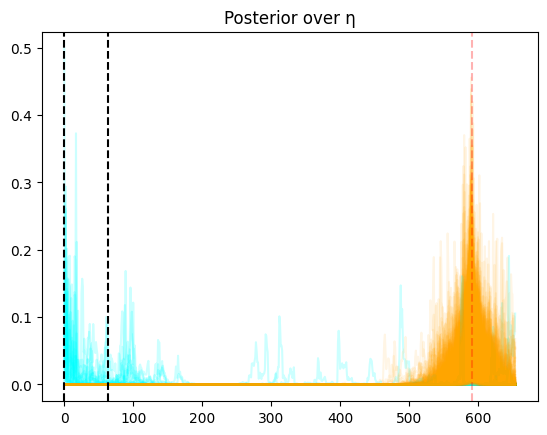

100%|██████████| 7/7 [1:16:06<00:00, 652.36s/it]


In [39]:
theoretical_coverage_list = [[] for i in range(len(chgpt_location_idx))]

for i in tqdm(range(len(chgpt_location_idx))):
    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 
    C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

    # Compute the fixed-C SE for given chgpt location
    signal_prior = GaussianSignal(B̃_cov)
    ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

    # Sample Z, V_\Theta
    num_outer_samples = 50
    # Sample Z
    Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_outer_samples)))).reshape(num_outer_samples, n, L)
    # Sample V̄_Θ
    V_Θ = (Z @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
        jnp.zeros(L), κ_T_fixed, size=n))).reshape(num_outer_samples, n, L)
    # ε = np.array(nprandom.normal(0, σ, size=(num_outer_samples, n)))


    for k in tqdm(range(num_outer_samples)):

        # Compute the credible set S(Θ_t, Y)
        post_Θ_Y = posterior_over_η(η_arr, p_η_arr, V_Θ[k], q(Z[k], C_true, σ), jnp.array(ρ), σ, ν, κ_T)
        α_CI = 0.05
        plt.plot(post_Θ_Y, color='cyan', alpha=0.2)
    #         # plt.show()
        try:
            # S_lower, S_upper = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) # Have to adapt for eta. 
            S_upper = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_Θ_Y)
            S_lower = 0
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        # S_lower_upper_list[i].append((S_lower, S_upper))
        print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower:S_upper].sum())
        # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])

        ### --- Estimate Expected coverage, with ensemble variables --- ###
        ## Sample Z, V̄_Θ, ε̄. 
        num_samples = 50
        # Sample Z
        Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # Sample V̄_Θ
        V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

        for j in range(num_samples):
            Ȳ = q(Z[j].reshape((n, L)), C_true, σ)
            post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
            plt.plot(post_V_Z, color='orange', alpha=0.1)
            # plt.show()
            # if S_lower is not None:
            #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
            theoretical_coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
            # else:
            #     coverage_list[i].append(None)
        print("Estimated coverage: ", np.mean(theoretical_coverage_list[i]))

    # Add x-ticks where S_lower and S_upper are
    plt.axvline(x=S_lower, color='black', linestyle='--')
    plt.axvline(x=S_upper, color='black', linestyle='--')
    # Vertical line at the true changepoint location
    plt.axvline(x=true_chgpt_locations(n)[0] - Δ(n), color='red', linestyle='--', alpha=0.3)
    plt.title("Posterior over η")
    plt.show()

# ### Plot the mean estimated coverage over δ
# plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1))
# plt.xlabel("location")
# plt.ylabel("Theoretical Coverage")
# plt.title("Theoretical Coverage vs chgpt location")
# plt.show()


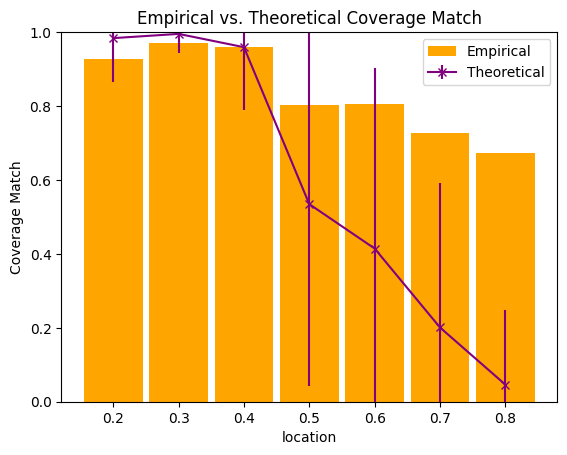

In [41]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), width = 0.09, color='orange', label='Empirical')
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x')
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))
plt.show()

### Compute Empirical Coverage + Theoretical Coverage jointly

  0%|          | 0/3 [00:00<?, ?it/s]

True chgpts = [300]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878]
norm_sq_corr_2_list:  [0.5226790869258671]
norm_sq_corr_1_SE_list:  [0.3590419575714433]
norm_sq_corr_2_SE_list:  [0.5315019504003763]


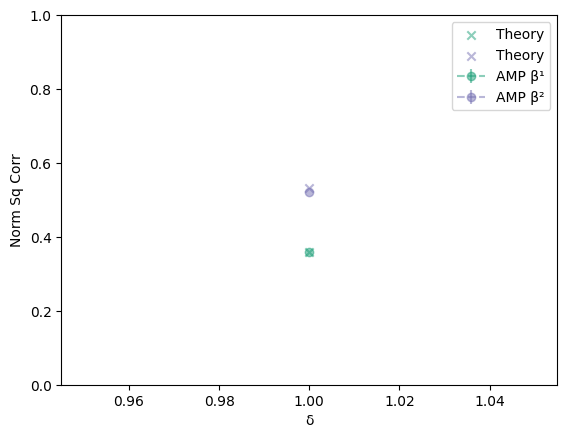

Constructed credible set with aimed coverage:  0.9564817808575429
Empirical coverage:  0.956224939646112
Theoretical coverage:  0.7081747341318803


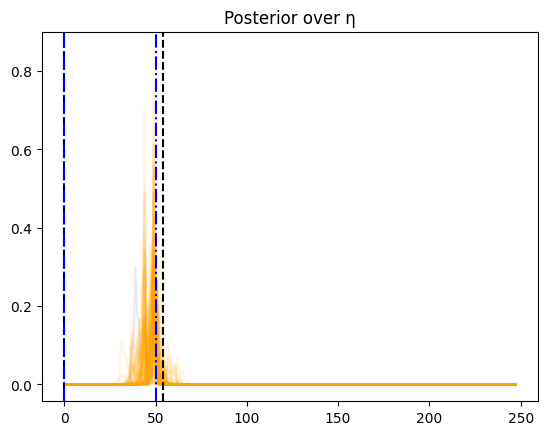

 10%|█         | 1/10 [00:22<03:26, 22.99s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435]


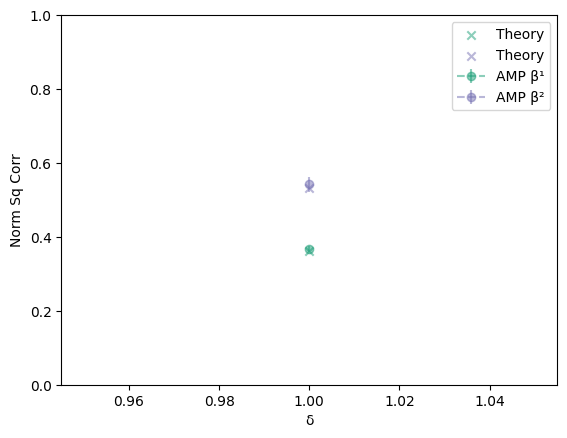

Constructed credible set with aimed coverage:  0.9886018205229933
Empirical coverage:  0.8357305334424943
Theoretical coverage:  0.7965408104689036


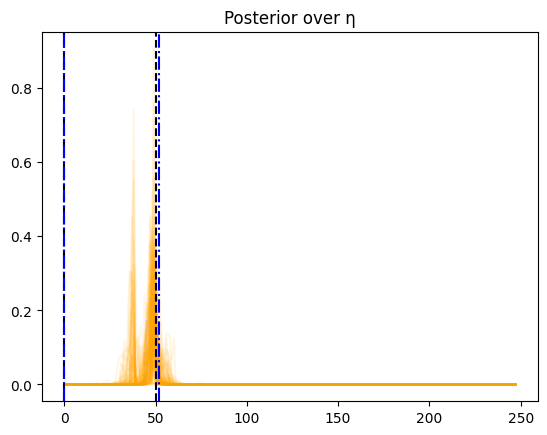

 20%|██        | 2/10 [00:46<03:04, 23.03s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232]


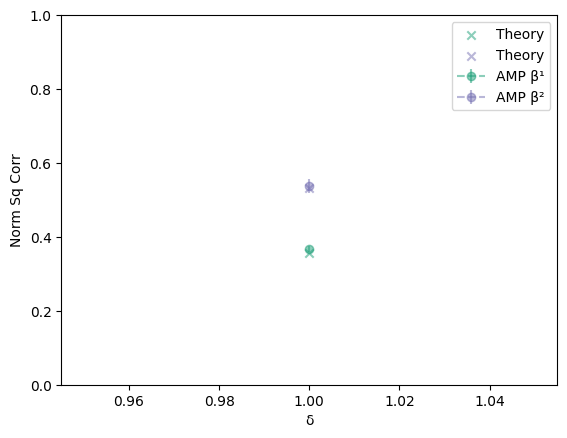

Constructed credible set with aimed coverage:  0.9599153558168662
Empirical coverage:  0.8101240874085825
Theoretical coverage:  0.7573827161181759


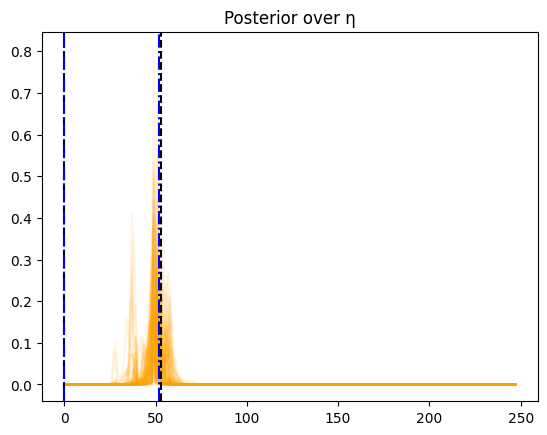

 30%|███       | 3/10 [01:09<02:41, 23.01s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514]


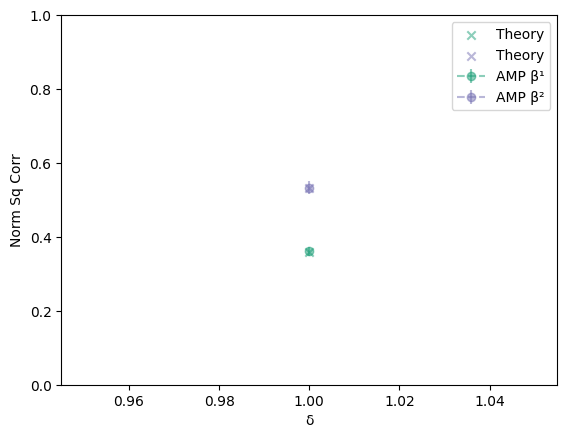

Constructed credible set with aimed coverage:  0.9777725057323962
Empirical coverage:  0.8411397435241761
Theoretical coverage:  0.7845343833757158


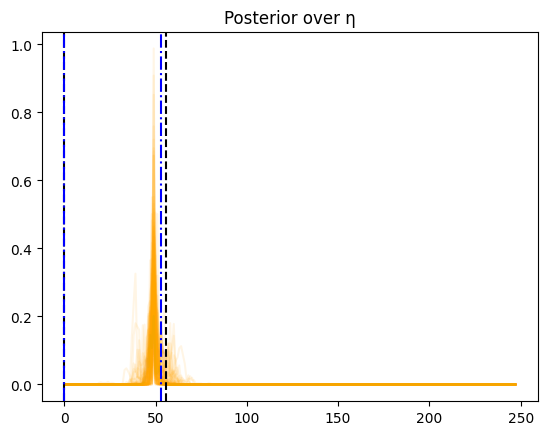

 40%|████      | 4/10 [01:32<02:17, 23.00s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137, 0.3611863010710129]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507, 0.4966801728471954]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474, 0.3576047728525544]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514, 0.5287122545956295]


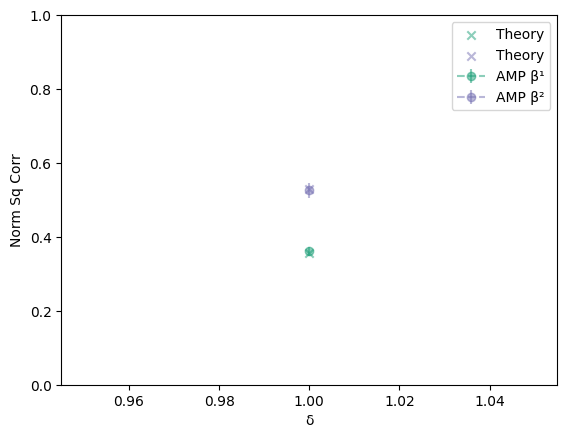

Constructed credible set with aimed coverage:  0.9521163408975146
Empirical coverage:  0.8155195066992121
Theoretical coverage:  0.7794718226922539


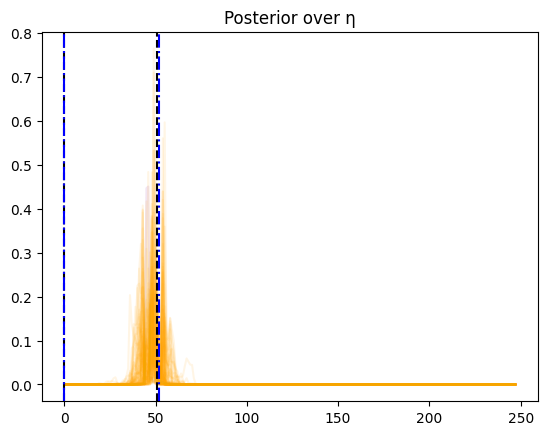

 50%|█████     | 5/10 [01:55<01:55, 23.04s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137, 0.3611863010710129, 0.3543433035362753]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507, 0.4966801728471954, 0.5581811546549887]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474, 0.3576047728525544, 0.3598252293701967]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514, 0.5287122545956295, 0.5317962273785404]


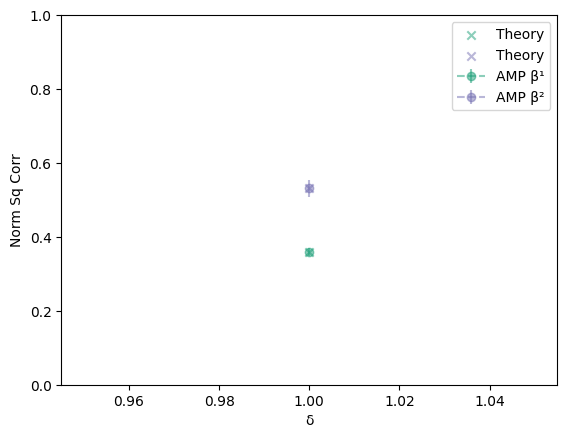

Constructed credible set with aimed coverage:  0.9560810247344742
Empirical coverage:  0.8427722581604968
Theoretical coverage:  0.7891367279465802


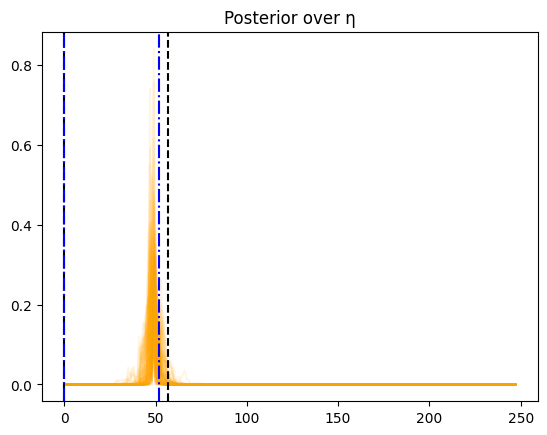

 60%|██████    | 6/10 [02:17<01:31, 22.91s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137, 0.3611863010710129, 0.3543433035362753, 0.34765246585797455]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507, 0.4966801728471954, 0.5581811546549887, 0.5447491019356724]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474, 0.3576047728525544, 0.3598252293701967, 0.35886840047081564]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514, 0.5287122545956295, 0.5317962273785404, 0.5298044200464819]


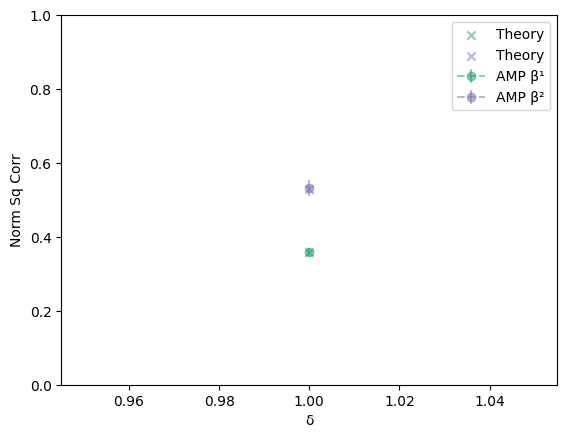

Constructed credible set with aimed coverage:  0.9550916866480536
Empirical coverage:  0.854873740485465
Theoretical coverage:  0.7920694386179632


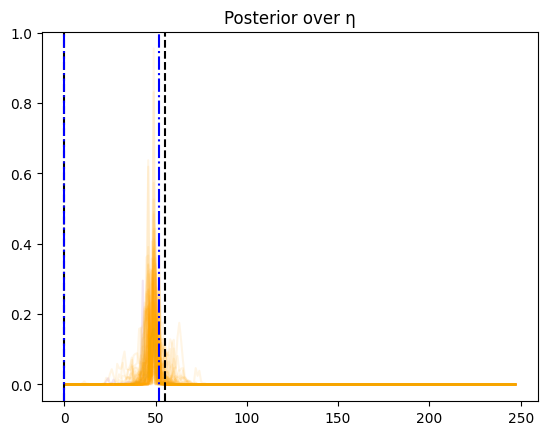

 70%|███████   | 7/10 [02:40<01:08, 22.99s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137, 0.3611863010710129, 0.3543433035362753, 0.34765246585797455, 0.3472079160967668]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507, 0.4966801728471954, 0.5581811546549887, 0.5447491019356724, 0.5231860743179045]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474, 0.3576047728525544, 0.3598252293701967, 0.35886840047081564, 0.3584765221484959]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514, 0.5287122545956295, 0.5317962273785404, 0.5298044200464819, 0.5298647958646296]


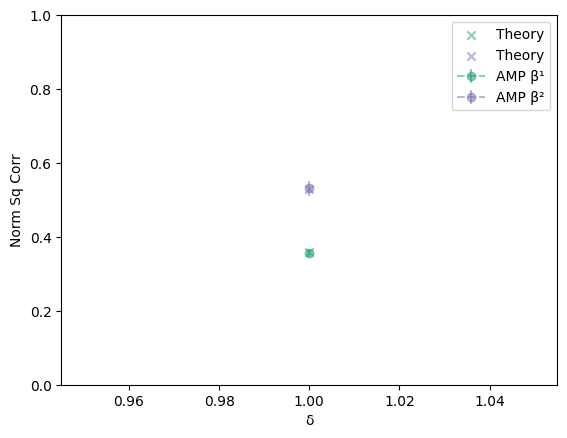

Constructed credible set with aimed coverage:  0.9518787237022552
Empirical coverage:  0.8716233699546624
Theoretical coverage:  0.8087616105643239


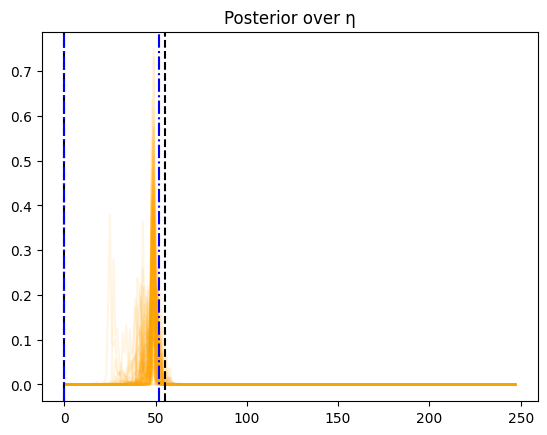

 80%|████████  | 8/10 [03:03<00:45, 22.98s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137, 0.3611863010710129, 0.3543433035362753, 0.34765246585797455, 0.3472079160967668, 0.38028045907401]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507, 0.4966801728471954, 0.5581811546549887, 0.5447491019356724, 0.5231860743179045, 0.540682184628502]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474, 0.3576047728525544, 0.3598252293701967, 0.35886840047081564, 0.3584765221484959, 0.35741857301647306]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514, 0.5287122545956295, 0.5317962273785404, 0.5298044200464819, 0.5298647958646296, 0.5330790331917]


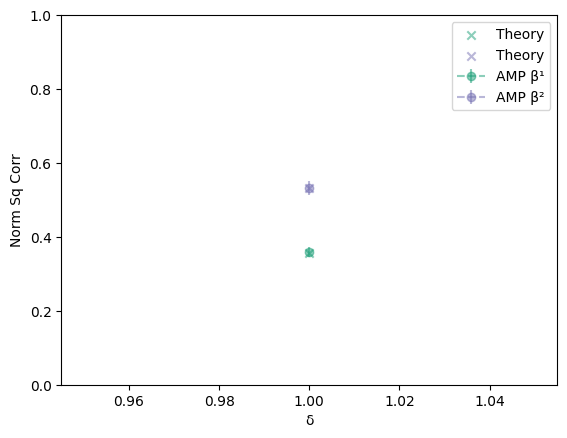

Constructed credible set with aimed coverage:  0.9721919098870353
Empirical coverage:  0.8498439965855981
Theoretical coverage:  0.7190344046710326


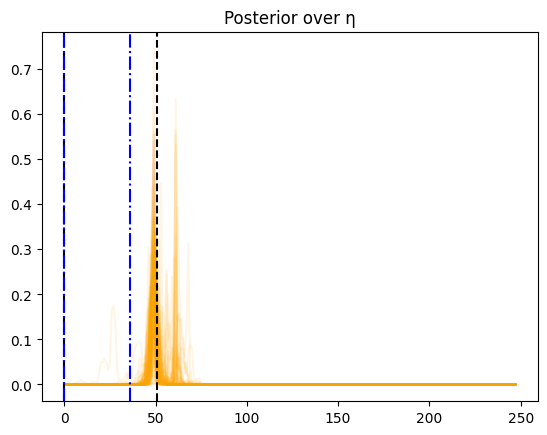

 90%|█████████ | 9/10 [03:27<00:23, 23.05s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.3580048361664878, 0.3750553656471129, 0.36879696780270793, 0.3414483984882137, 0.3611863010710129, 0.3543433035362753, 0.34765246585797455, 0.3472079160967668, 0.38028045907401, 0.38675219804600025]
norm_sq_corr_2_list:  [0.5226790869258671, 0.5631151407698995, 0.5235684189622241, 0.52162489356507, 0.4966801728471954, 0.5581811546549887, 0.5447491019356724, 0.5231860743179045, 0.540682184628502, 0.5117719755096982]
norm_sq_corr_1_SE_list:  [0.3590419575714433, 0.36065200996768426, 0.3572523965162526, 0.35775068156991474, 0.3576047728525544, 0.3598252293701967, 0.35886840047081564, 0.3584765221484959, 0.35741857301647306, 0.36111446497472866]
norm_sq_corr_2_SE_list:  [0.5315019504003763, 0.5326953549044435, 0.5322876364724232, 0.5314443782193514, 0.5287122545956295, 0.5317962273785404, 0.5298044200464819, 0.5298647958646296, 0.5330790331917, 0.5311734570979479]


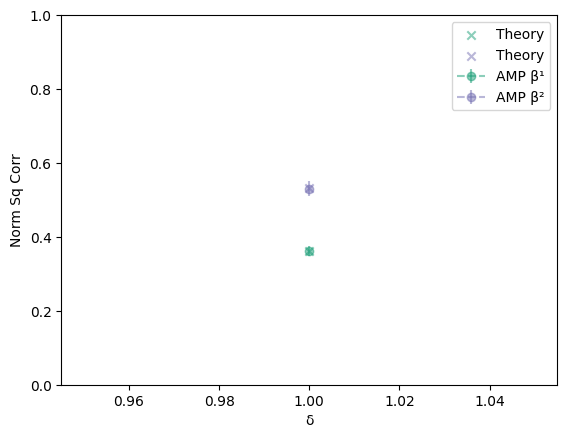

Constructed credible set with aimed coverage:  0.987976209316019
Empirical coverage:  0.8136968663647377
Theoretical coverage:  0.6959682336416289


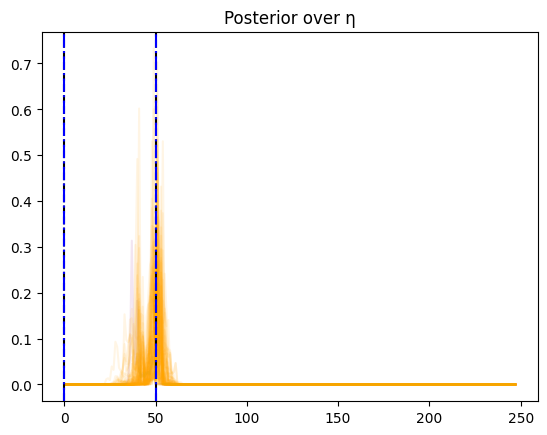

 33%|███▎      | 1/3 [03:50<07:40, 230.19s/it]

True chgpts = [337]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872]
norm_sq_corr_2_list:  [0.49781052160825695]
norm_sq_corr_1_SE_list:  [0.41261946132359406]
norm_sq_corr_2_SE_list:  [0.5034651370587484]


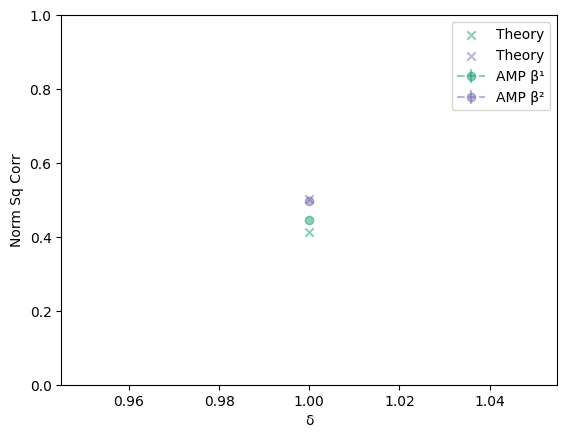

Constructed credible set with aimed coverage:  0.9523297731251176
Empirical coverage:  0.8861347795659509
Theoretical coverage:  0.41797444953008683


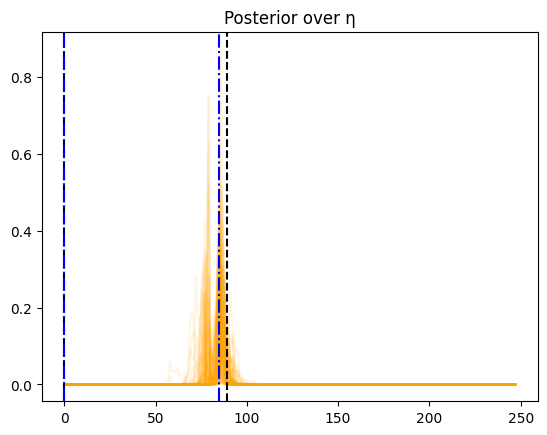

 10%|█         | 1/10 [00:23<03:27, 23.03s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811]


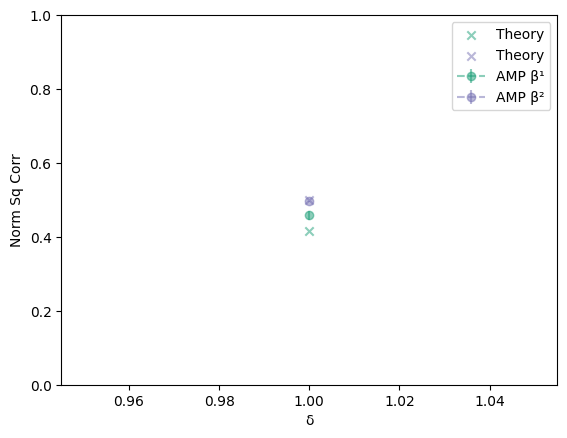

Constructed credible set with aimed coverage:  0.989105035926154
Empirical coverage:  0.9117443870486496
Theoretical coverage:  0.65944903970095


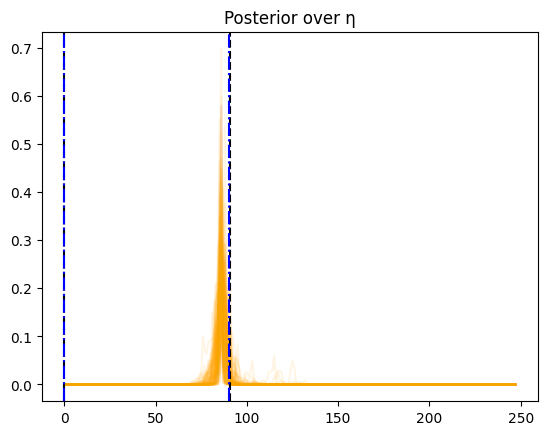

 20%|██        | 2/10 [00:46<03:04, 23.11s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178]


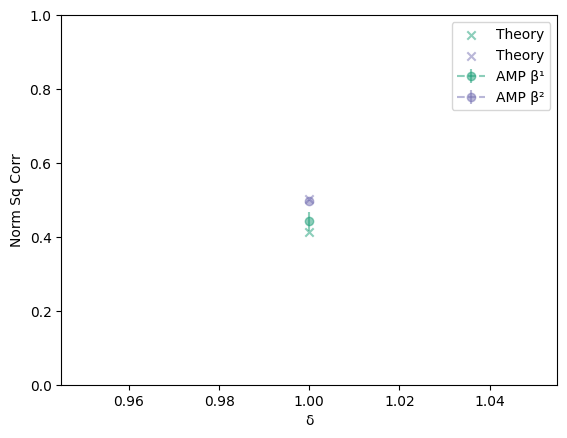

Constructed credible set with aimed coverage:  0.956717939401355
Empirical coverage:  0.9386486806676161
Theoretical coverage:  0.7291902876721774


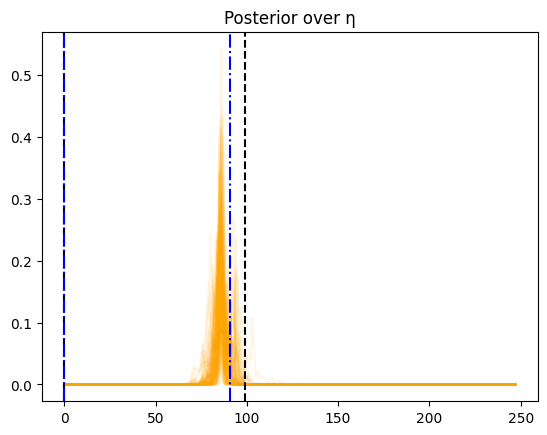

 30%|███       | 3/10 [01:09<02:43, 23.33s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716]


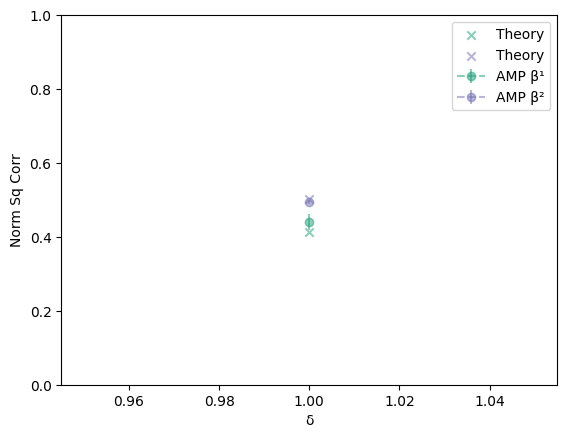

Constructed credible set with aimed coverage:  0.9558167995165744
Empirical coverage:  0.8254276816418255
Theoretical coverage:  0.7962334095882246


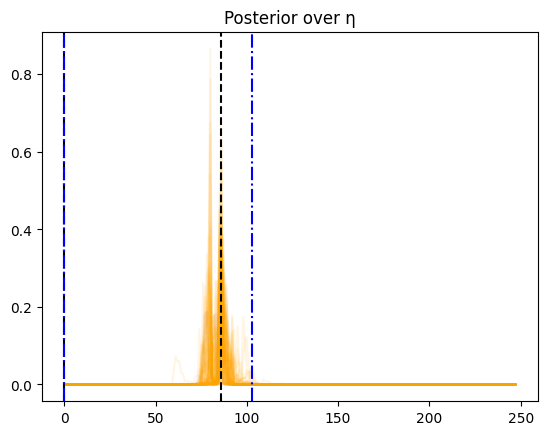

 40%|████      | 4/10 [01:33<02:20, 23.45s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659, 0.43061637401044617]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115, 0.5098271660524417]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802, 0.41222372176177974]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716, 0.5008107732955323]


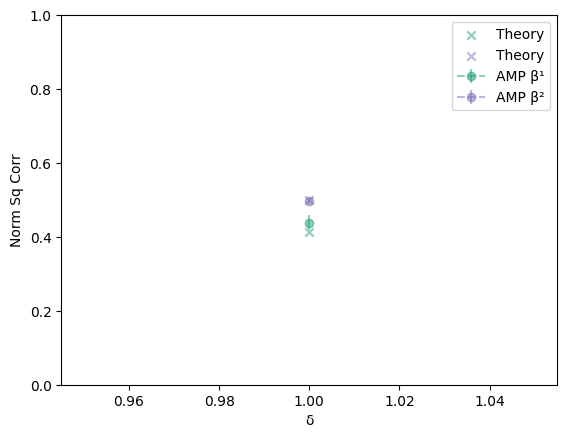

Constructed credible set with aimed coverage:  0.9820626280507814
Empirical coverage:  0.8518590909798893
Theoretical coverage:  0.8363577399812149


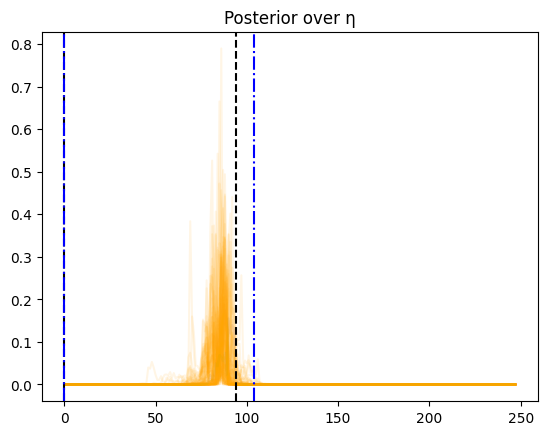

 50%|█████     | 5/10 [01:56<01:56, 23.27s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659, 0.43061637401044617, 0.43198032020150395]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115, 0.5098271660524417, 0.5263167019283401]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802, 0.41222372176177974, 0.41453574538529897]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716, 0.5008107732955323, 0.5022780741999491]


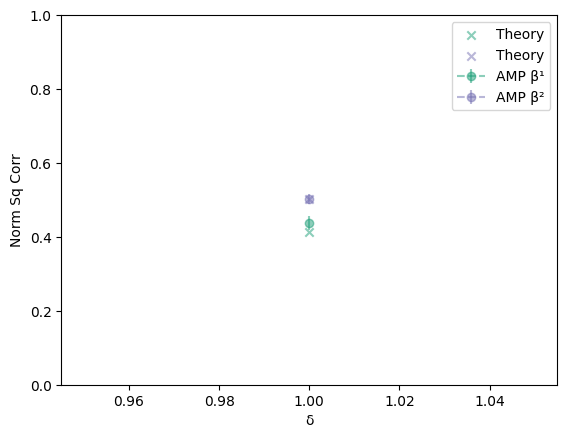

Constructed credible set with aimed coverage:  0.9831650044831016
Empirical coverage:  0.8329332852024147
Theoretical coverage:  0.8334756625736107


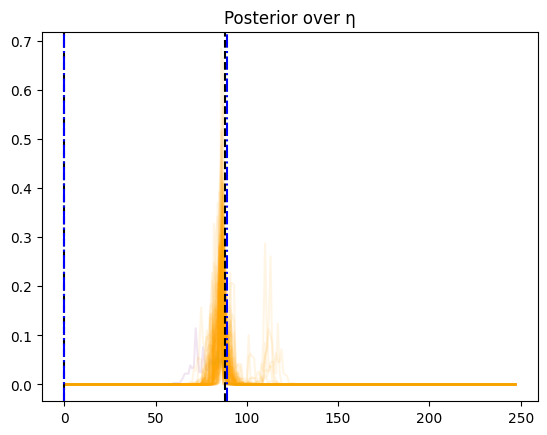

 60%|██████    | 6/10 [02:19<01:32, 23.16s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659, 0.43061637401044617, 0.43198032020150395, 0.3802300730596855]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115, 0.5098271660524417, 0.5263167019283401, 0.4736384931563356]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802, 0.41222372176177974, 0.41453574538529897, 0.41398822211119013]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716, 0.5008107732955323, 0.5022780741999491, 0.5010672802741281]


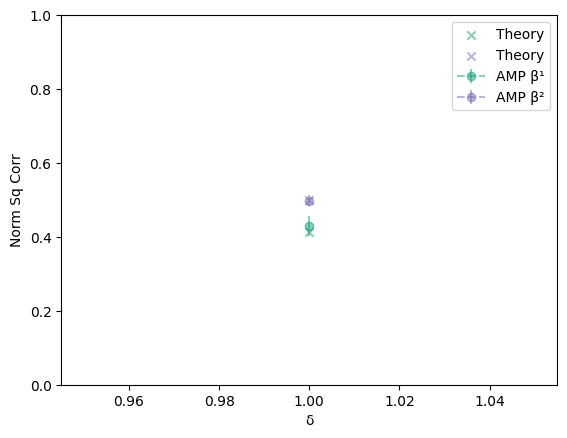

Constructed credible set with aimed coverage:  0.9774775620413441
Empirical coverage:  0.8452766306797157
Theoretical coverage:  0.8070028439226521


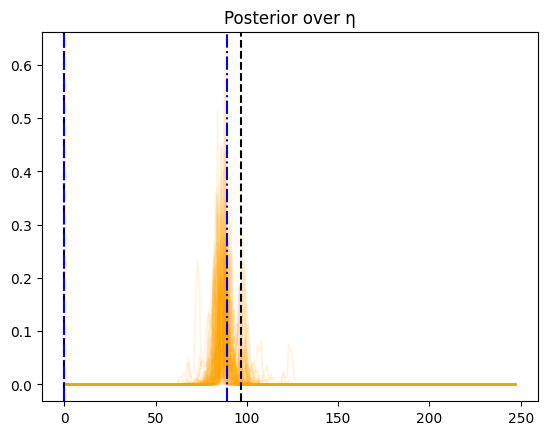

 70%|███████   | 7/10 [02:42<01:09, 23.16s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659, 0.43061637401044617, 0.43198032020150395, 0.3802300730596855, 0.4018935776571816]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115, 0.5098271660524417, 0.5263167019283401, 0.4736384931563356, 0.4712599670303784]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802, 0.41222372176177974, 0.41453574538529897, 0.41398822211119013, 0.4142716502422748]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716, 0.5008107732955323, 0.5022780741999491, 0.5010672802741281, 0.5012944110077833]


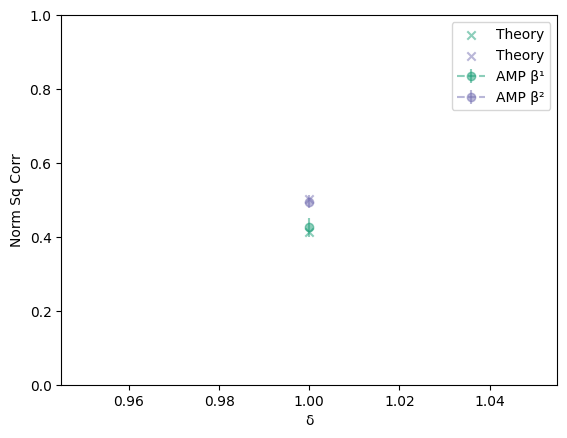

Constructed credible set with aimed coverage:  0.9579258091965184
Empirical coverage:  0.8573137116128043
Theoretical coverage:  0.827416359452934


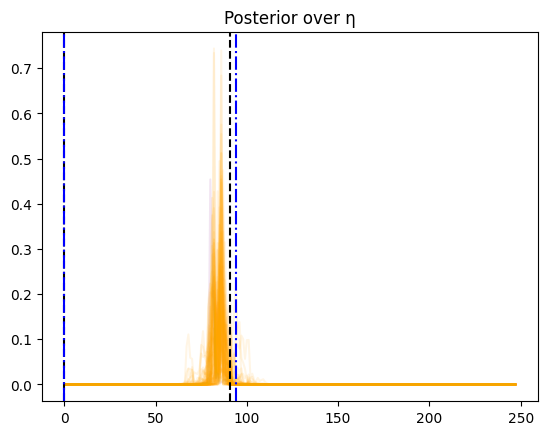

 80%|████████  | 8/10 [03:05<00:46, 23.16s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659, 0.43061637401044617, 0.43198032020150395, 0.3802300730596855, 0.4018935776571816, 0.445566204484814]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115, 0.5098271660524417, 0.5263167019283401, 0.4736384931563356, 0.4712599670303784, 0.5171980631171806]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802, 0.41222372176177974, 0.41453574538529897, 0.41398822211119013, 0.4142716502422748, 0.411726745714819]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716, 0.5008107732955323, 0.5022780741999491, 0.5010672802741281, 0.5012944110077833, 0.5030273646190322]


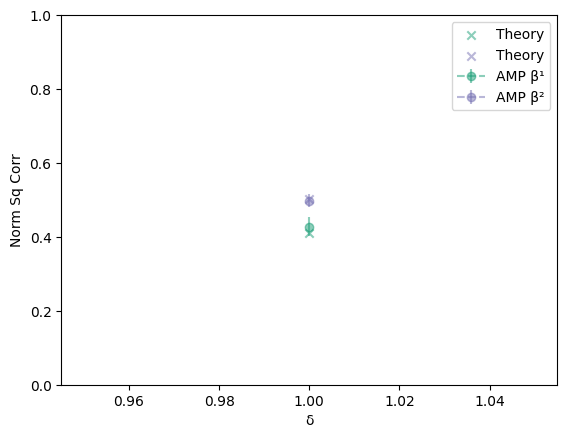

Constructed credible set with aimed coverage:  0.9529367490753677
Empirical coverage:  0.8724946065601137
Theoretical coverage:  0.8265290435706477


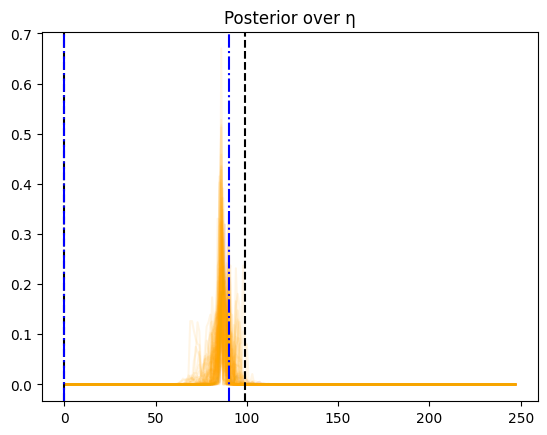

 90%|█████████ | 9/10 [03:28<00:23, 23.20s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.4450789490046872, 0.47110924740596083, 0.4099481176458095, 0.4338340061919659, 0.43061637401044617, 0.43198032020150395, 0.3802300730596855, 0.4018935776571816, 0.445566204484814, 0.4201435872005011]
norm_sq_corr_2_list:  [0.49781052160825695, 0.49567742048493507, 0.4998530862527771, 0.4840341522884115, 0.5098271660524417, 0.5263167019283401, 0.4736384931563356, 0.4712599670303784, 0.5171980631171806, 0.480434963220027]
norm_sq_corr_1_SE_list:  [0.41261946132359406, 0.4166576589057628, 0.41358381263926064, 0.4144737984753802, 0.41222372176177974, 0.41453574538529897, 0.41398822211119013, 0.4142716502422748, 0.411726745714819, 0.413111725756366]
norm_sq_corr_2_SE_list:  [0.5034651370587484, 0.5011092751455811, 0.501446570730178, 0.5030014144289716, 0.5008107732955323, 0.5022780741999491, 0.5010672802741281, 0.5012944110077833, 0.5030273646190322, 0.5025310613054906]


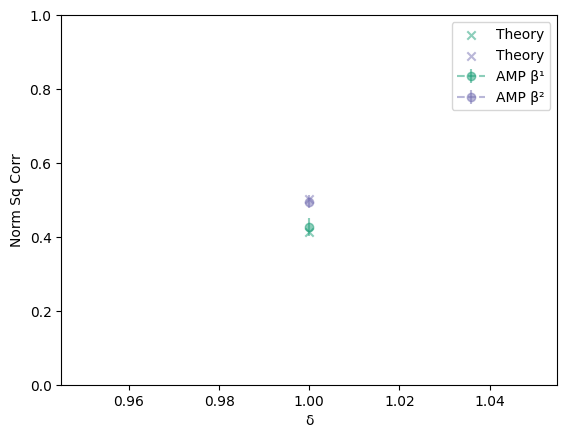

Constructed credible set with aimed coverage:  0.9937250493078341
Empirical coverage:  0.8640499963639741
Theoretical coverage:  0.8317659360237573


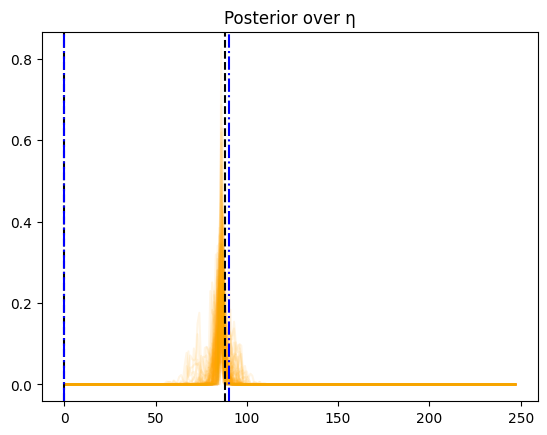

 67%|██████▋   | 2/3 [07:42<03:51, 231.46s/it]

True chgpts = [375]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423]
norm_sq_corr_2_list:  [0.45395535678515214]
norm_sq_corr_1_SE_list:  [0.46058958336044276]
norm_sq_corr_2_SE_list:  [0.46104826002200044]


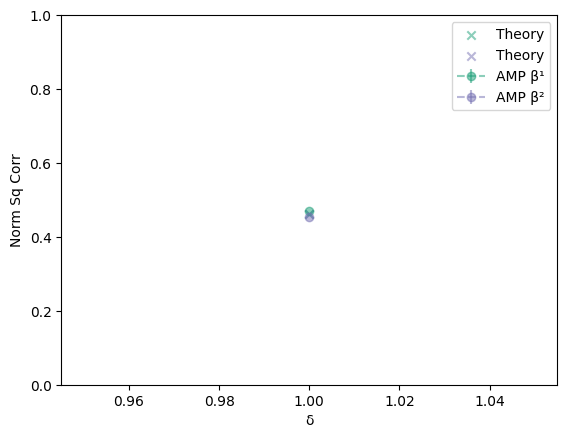

Constructed credible set with aimed coverage:  0.9644473006099712
Empirical coverage:  0.9398650611158533
Theoretical coverage:  0.9719620776167183


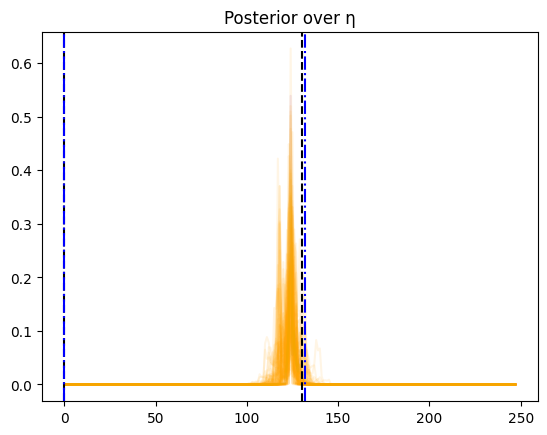

 10%|█         | 1/10 [00:23<03:28, 23.17s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355]


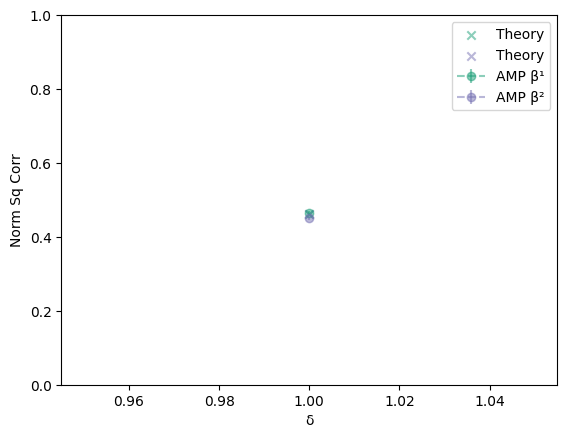

Constructed credible set with aimed coverage:  0.9556888780117264
Empirical coverage:  0.8709236316717082
Theoretical coverage:  0.9015910871720973


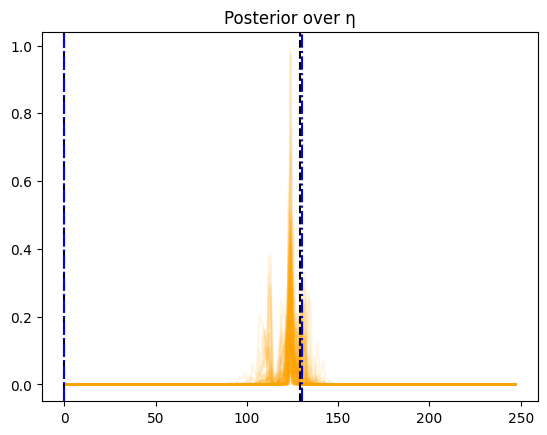

 20%|██        | 2/10 [00:46<03:06, 23.36s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753]


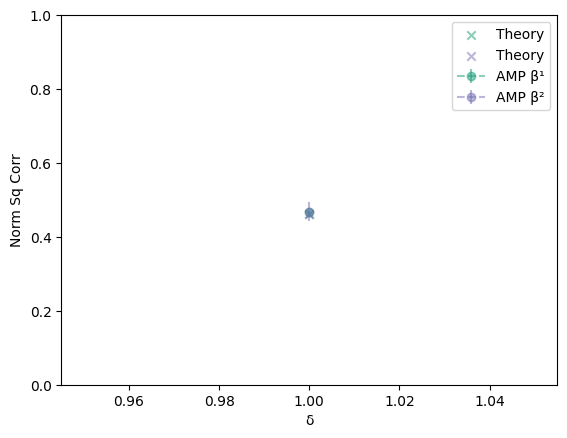

Constructed credible set with aimed coverage:  0.9825755347567273
Empirical coverage:  0.8889197355916637
Theoretical coverage:  0.9292016533814316


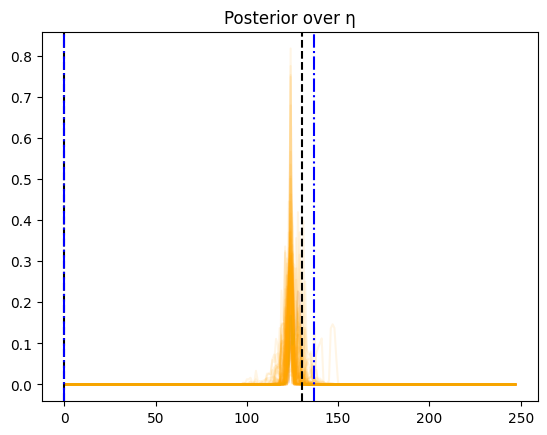

 30%|███       | 3/10 [01:10<02:45, 23.59s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927]


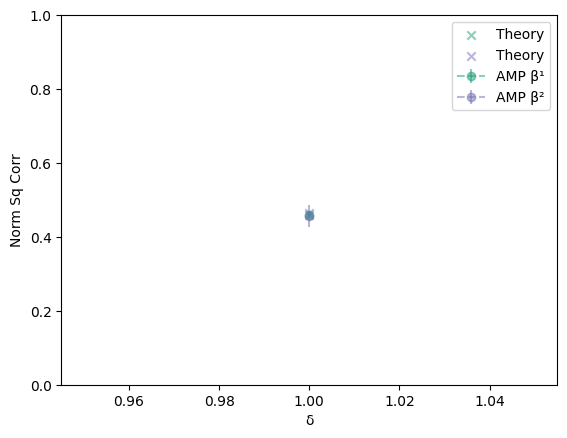

Constructed credible set with aimed coverage:  0.9857861395525906
Empirical coverage:  0.9166832939334292
Theoretical coverage:  0.8852188076294442


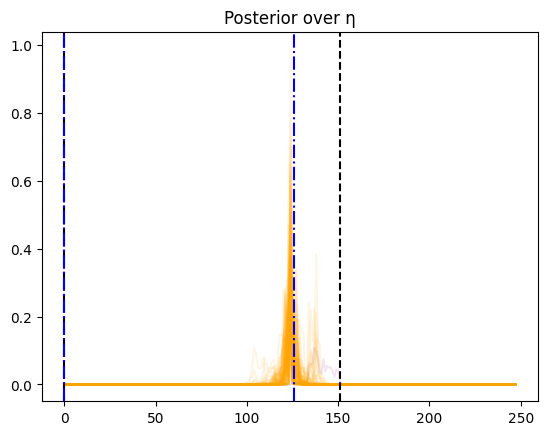

 40%|████      | 4/10 [01:33<02:20, 23.42s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706, 0.42400796008461933]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833, 0.4381854777105431]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337, 0.462628606132299]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927, 0.4594374677247437]


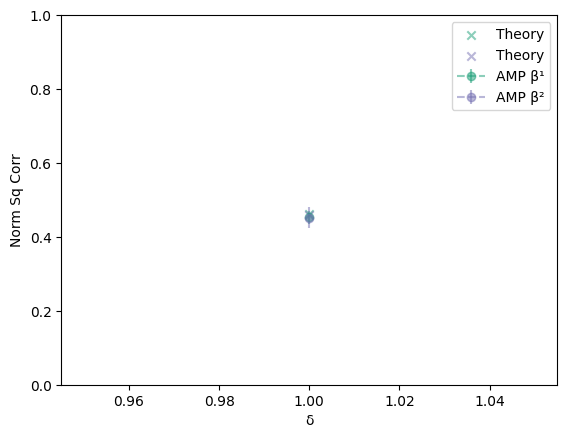

Constructed credible set with aimed coverage:  0.9794009034035353
Empirical coverage:  0.9106020912552422
Theoretical coverage:  0.9035300035980584


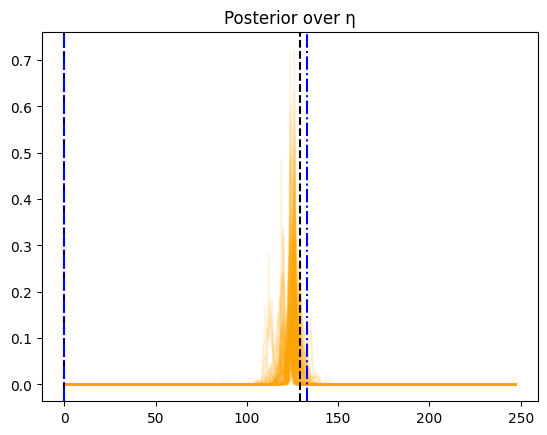

 50%|█████     | 5/10 [01:57<01:56, 23.39s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706, 0.42400796008461933, 0.43782837497837696]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833, 0.4381854777105431, 0.4740486956339228]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337, 0.462628606132299, 0.46046393848102785]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927, 0.4594374677247437, 0.46214359935150673]


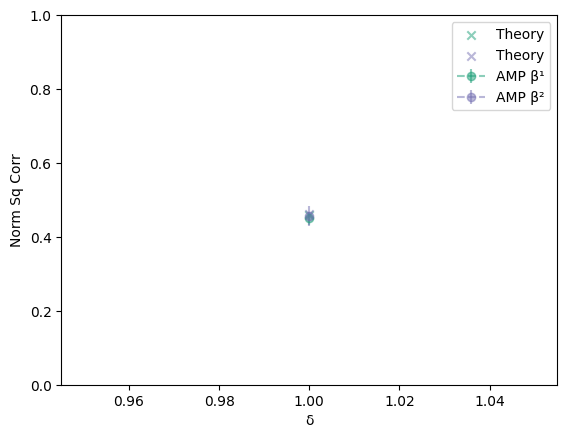

Constructed credible set with aimed coverage:  0.980522607201369
Empirical coverage:  0.9150511589053146
Theoretical coverage:  0.9032767337413069


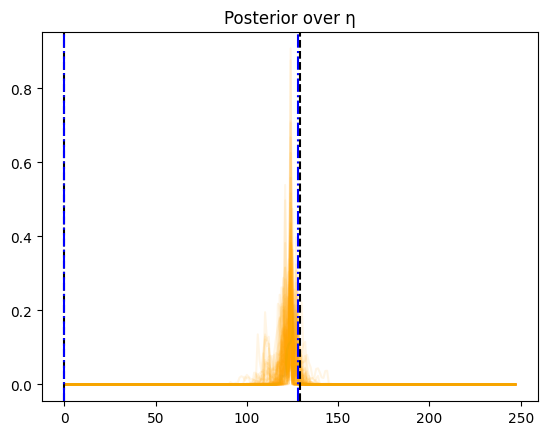

 60%|██████    | 6/10 [02:20<01:33, 23.34s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706, 0.42400796008461933, 0.43782837497837696, 0.46235002543268583]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833, 0.4381854777105431, 0.4740486956339228, 0.4618973163385364]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337, 0.462628606132299, 0.46046393848102785, 0.4622708753724909]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927, 0.4594374677247437, 0.46214359935150673, 0.46334038862068]


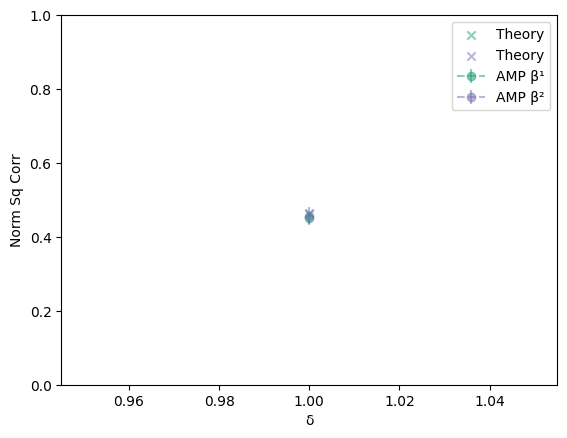

Constructed credible set with aimed coverage:  0.9618818190803573
Empirical coverage:  0.9028948809047157
Theoretical coverage:  0.898539598774051


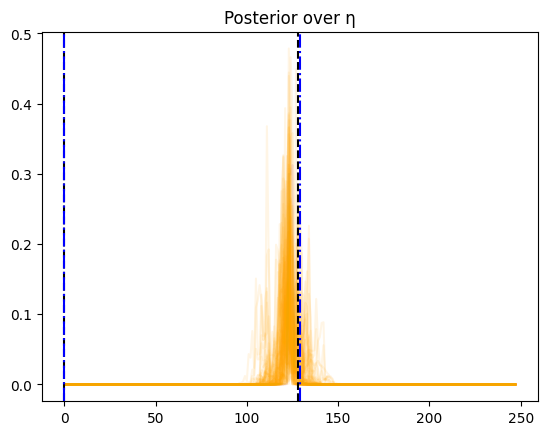

 70%|███████   | 7/10 [02:43<01:09, 23.26s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706, 0.42400796008461933, 0.43782837497837696, 0.46235002543268583, 0.4236572738104557]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833, 0.4381854777105431, 0.4740486956339228, 0.4618973163385364, 0.47808466043368114]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337, 0.462628606132299, 0.46046393848102785, 0.4622708753724909, 0.4612427617859983]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927, 0.4594374677247437, 0.46214359935150673, 0.46334038862068, 0.4642903741732666]


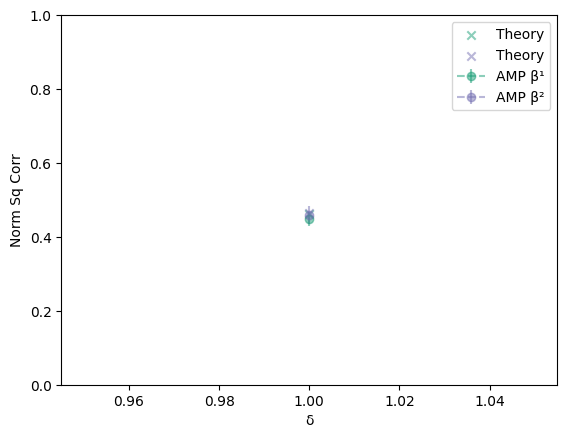

Constructed credible set with aimed coverage:  0.9595618424762162
Empirical coverage:  0.9082201351069114
Theoretical coverage:  0.886026216097841


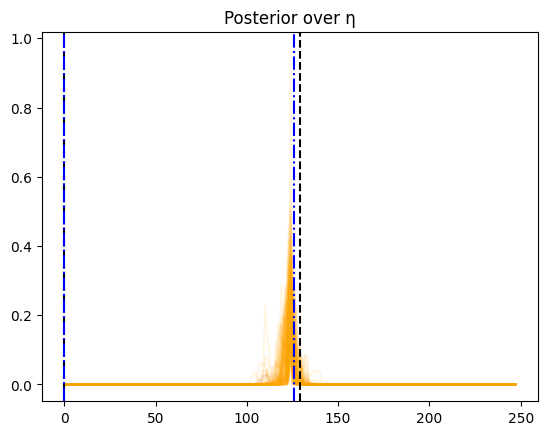

 80%|████████  | 8/10 [03:06<00:46, 23.22s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706, 0.42400796008461933, 0.43782837497837696, 0.46235002543268583, 0.4236572738104557, 0.4421429434375957]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833, 0.4381854777105431, 0.4740486956339228, 0.4618973163385364, 0.47808466043368114, 0.46634721588464245]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337, 0.462628606132299, 0.46046393848102785, 0.4622708753724909, 0.4612427617859983, 0.4627216996853009]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927, 0.4594374677247437, 0.46214359935150673, 0.46334038862068, 0.4642903741732666, 0.46243161100821245]


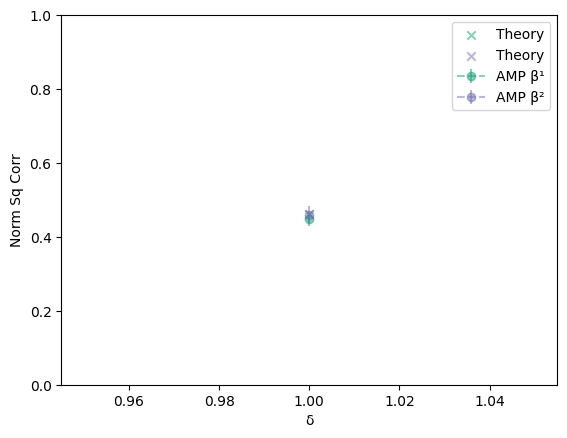

Constructed credible set with aimed coverage:  0.9552448359647896
Empirical coverage:  0.8949381921334637
Theoretical coverage:  0.8752102641254015


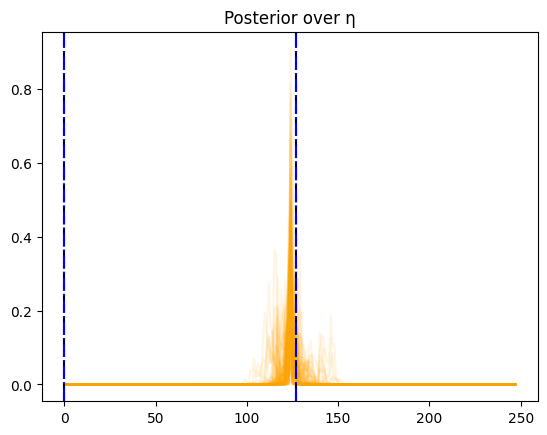

 90%|█████████ | 9/10 [03:30<00:23, 23.34s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

norm_sq_corr_1_list:  [0.46879288244929423, 0.46007457874495833, 0.4691814495335204, 0.4402666016598706, 0.42400796008461933, 0.43782837497837696, 0.46235002543268583, 0.4236572738104557, 0.4421429434375957, 0.4401854274986764]
norm_sq_corr_2_list:  [0.45395535678515214, 0.44629974468381184, 0.5039128042416766, 0.41951920448557833, 0.4381854777105431, 0.4740486956339228, 0.4618973163385364, 0.47808466043368114, 0.46634721588464245, 0.472890959734959]
norm_sq_corr_1_SE_list:  [0.46058958336044276, 0.4622465375714999, 0.4619710215148515, 0.46009834899435337, 0.462628606132299, 0.46046393848102785, 0.4622708753724909, 0.4612427617859983, 0.4627216996853009, 0.46078230445799706]
norm_sq_corr_2_SE_list:  [0.46104826002200044, 0.46187907038018355, 0.46107332941309753, 0.4646941549944927, 0.4594374677247437, 0.46214359935150673, 0.46334038862068, 0.4642903741732666, 0.46243161100821245, 0.45975849745374375]


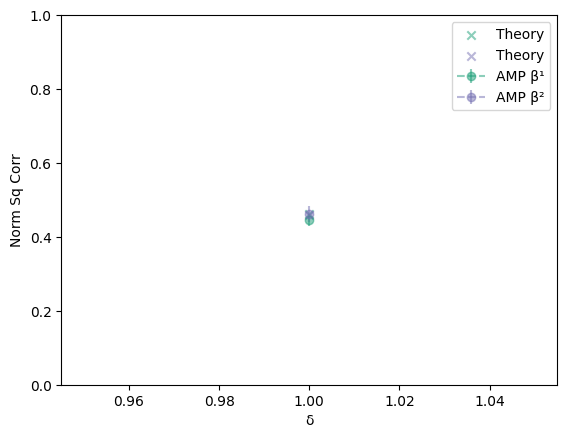

Constructed credible set with aimed coverage:  0.9640412460852704
Empirical coverage:  0.898179633534208
Theoretical coverage:  0.875095825028321


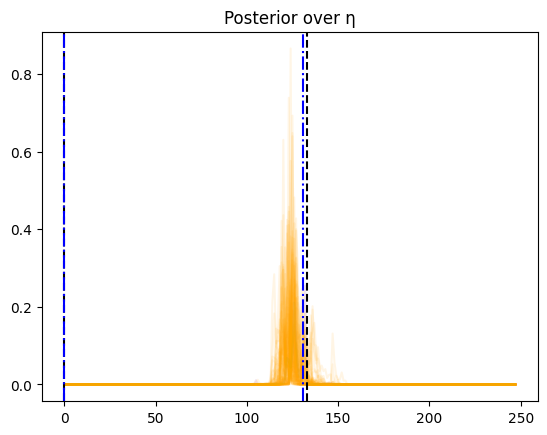

100%|██████████| 3/3 [11:35<00:00, 232.00s/it]


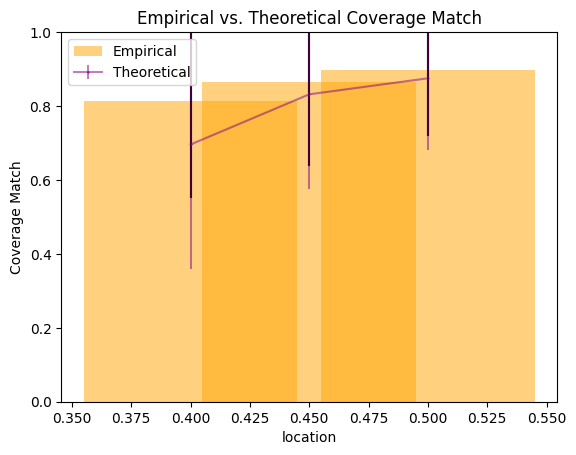

In [2]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as chgpt_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 750
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0]

# seed = 29
# nprandom.seed(2*seed)

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

chgpt_location_idx = [0.4, 0.45, 0.5]

coverage_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_coverage_list = [[] for i in range(len(chgpt_location_idx))]

empirical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]

δ = 1.0
n = int(δ * p)
B̃_cov = np.eye(L)

for i in tqdm(range(len(chgpt_location_idx))):
    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/3)

    Lmin = L
    Lmax = L # TODO: ground truth is L=4 cell stages (3 chgpts).
    num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
    assert η_arr.shape == (num_valid_configs, Lmax-1) and \
        len(p_η_arr) == num_valid_configs
    assert ϕ.shape == (Lmax, n)

    print(f"True chgpts = {true_chgpt_locations(n)}")
    C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

    signal_prior = GaussianSignal(B̃_cov)
    # Sample the noise vector
    η = np.array(nprandom.normal(0, σ, size=n))

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    # --- Set up theoretical coverage ---
    # Compute the fixed-C SE for given chgpt location
    # ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

    # Sample Z, V_\Theta
    num_outer_samples = 10
    # Sample Z
    # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_outer_samples)))).reshape(num_outer_samples, n, L)
    # # Sample V̄_Θ
    # V_Θ = (Z @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
    #     jnp.zeros(L), κ_T_fixed, size=n))).reshape(num_outer_samples, n, L)
    # ε = np.array(nprandom.normal(0, σ, size=(num_outer_samples, n)))

    norm_sq_corr_1_list = []
    norm_sq_corr_2_list = []
    norm_sq_corr_1_SE_list = []
    norm_sq_corr_2_SE_list = []
    for k in tqdm(range(num_outer_samples)):
        # --- Set up empirical coverage ---
        # Gaussian Prior
        B̃ = signal_prior.sample(p)
        B̂_0 = signal_prior.sample(p)

        # Generate the observation vector Y
        X = np.random.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        Y = chgpt_jax.q(Θ, C_true, σ, noise_vector = η).sample() 

        B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
        ν = ν_arr[-1]
        κ_T = κ_T_arr[-1]
        ν_fixed = ν_fixed_arr[-1]
        κ_T_fixed = κ_T_fixed_arr[-1]

        norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        norm_sq_corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
        norm_sq_corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))
        print("norm_sq_corr_1_list: ", norm_sq_corr_1_list)
        print("norm_sq_corr_2_list: ", norm_sq_corr_2_list)
        print("norm_sq_corr_1_SE_list: ", norm_sq_corr_1_SE_list)
        print("norm_sq_corr_2_SE_list: ", norm_sq_corr_2_SE_list)


        # Sqcorr plots
        plt.errorbar([δ], np.mean(norm_sq_corr_1_list), yerr = np.std(norm_sq_corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
        plt.errorbar([δ], np.mean(norm_sq_corr_2_list), yerr = np.std(norm_sq_corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
        plt.scatter([δ], norm_sq_corr_1_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[0])
        plt.scatter([δ], norm_sq_corr_2_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[2])
        plt.ylim((0, 1))
        plt.xlabel("δ")
        plt.ylabel("Norm Sq Corr")
        plt.legend()
        plt.show()

        # B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν

        # --- Compute Credible Set from AMP ---
        # Compute the credible set S(Θ_t, Y)
        post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
        α_CI = 0.05
        plt.plot(post_Θ_Y, color='purple', alpha=0.1)
        # plt.show()
        try:
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) 
            S_lower_AMP, S_upper_AMP = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_Θ_Y)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        # S_lower_upper_list[i].append((S_lower, S_upper))
        print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower_AMP:S_upper_AMP].sum())
        # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])
        empirical_credible_set_list[i].append((S_lower_AMP, S_upper_AMP))

        # --- Compute Credible Set from theoretical ---
        # Compute the credible set S(Θ_t, Y)
        Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
        # Sample V̄_Θ
        V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
        post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, chgpt_jax.q(Z_i, C_true, σ, noise_vector = η).sample(), jnp.array(ρ), σ, ν, κ_T)
        α_CI = 0.05
        plt.plot(post_V_q, color='orange', alpha=0.1)
        try:
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_V_q) 
            S_lower_theory, S_upper_theory = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_V_q)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        theoretical_credible_set_list[i].append((S_lower_theory, S_upper_theory))

        ### --- Estimate Expected coverage, with ensemble variables --- ###
        ## Sample Z, V̄_Θ, ε̄. 
        num_samples = 100
        # Sample Z
        Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # Sample V̄_Θ
        V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

        for j in range(num_samples):
            Ȳ = chgpt_jax.q(Z[j].reshape((n, L)), C_true, σ).sample()
            post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
            plt.plot(post_V_Z, color='orange', alpha=0.1)
            # plt.show()
            # if S_lower is not None:
            #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
            coverage_list[i].append(np.sum(post_V_Z[S_lower_AMP:S_upper_AMP]))
            theoretical_coverage_list[i].append(np.sum(post_V_Z[S_lower_theory:S_upper_theory]))
            # else:
            #     coverage_list[i].append(None)
        print("Empirical coverage: ", np.mean(coverage_list[i]))
        print("Theoretical coverage: ", np.mean(theoretical_coverage_list[i]))
        # Add x-ticks where S_lower and S_upper are
        plt.axvline(x=S_lower_AMP, color='black', linestyle='--')
        plt.axvline(x=S_upper_AMP, color='black', linestyle='--')
        plt.axvline(x=S_lower_theory, color='blue', linestyle='-.')
        plt.axvline(x=S_upper_theory, color='blue', linestyle='-.')
        plt.title("Posterior over η")
        plt.show()

### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.09, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', markersize=1.1, alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))
plt.show()




In [ ]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.09, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', markersize=1.1, alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))
plt.show()

NameError: name 'coverage_list' is not defined

<Figure size 640x480 with 0 Axes>

### Sanity check: plot AMP vs. fixed C state Evolution

  0%|          | 0/5 [00:00<?, ?it/s]

True chgpts = [125]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:32,  8.03s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:15<00:23,  7.79s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:23<00:15,  7.70s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:30<00:07,  7.70s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:38<02:34, 38.60s/it]

True chgpts = [250]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:13<00:54, 13.61s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:24<00:36, 12.08s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:35<00:22, 11.42s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:45<00:11, 11.08s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 2/5 [01:35<02:27, 49.15s/it]

True chgpts = [375]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:16<01:06, 16.62s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:30<00:44, 14.89s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:44<00:28, 14.36s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:57<00:14, 14.18s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 3/5 [02:46<01:58, 59.47s/it]

True chgpts = [500]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:19<01:18, 19.50s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:36<00:54, 18.08s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:54<00:35, 17.92s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 4/5 [01:14<00:18, 18.64s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 4/5 [04:18<01:12, 72.15s/it]

True chgpts = [625]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:23<01:34, 23.74s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:43<01:04, 21.66s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 3/5 [01:05<00:43, 21.55s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 4/5 [01:25<00:20, 20.85s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 5/5 [06:03<00:00, 72.70s/it]


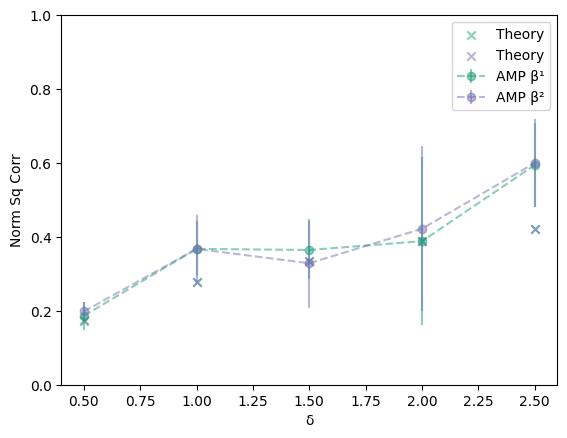

In [2]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 500
σ = 0.6 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 5
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.5, 1.0, 1.5, 2.0, 2.5]

# seed = 29
# nprandom.seed(2*seed)

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

chgpt_location_idx = [0.5]

norm_sq_corr_1_list  = [[] for i in range(len(δ_list))]
norm_sq_corr_2_list  = [[] for i in range(len(δ_list))]
norm_sq_corr_1_SE_list  = [[] for i in range(len(δ_list))]
norm_sq_corr_2_SE_list  = [[] for i in range(len(δ_list))]
for i in tqdm(range(len(δ_list))):
    δ = δ_list[i]
    n = int(δ * p)
    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[0])] 
    B̃_cov = np.eye(L)

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/20)

    Lmin = L
    Lmax = L 
    num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
    assert η_arr.shape == (num_valid_configs, Lmax-1) and \
        len(p_η_arr) == num_valid_configs
    assert ϕ.shape == (Lmax, n)

    print(f"True chgpts = {true_chgpt_locations(n)}")
    C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

    signal_prior = GaussianSignal(B̃_cov)

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    for trial_num in tqdm(range(num_trials)):
        # --- Set up empirical coverage ---
        # Gaussian Prior
        B̃ = signal_prior.sample(p)
        B̂_0 = signal_prior.sample(p)

        # Generate the observation vector Y
        X = np.random.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        Y = q(Θ, C_true, σ) 

        B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
        ν = ν_arr[-1]
        κ_T = κ_T_arr[-1]
        ν_fixed = ν_fixed_arr[-1]
        κ_T_fixed = κ_T_fixed_arr[-1]

        norm_sq_corr_1_list[i].append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_list[i].append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        norm_sq_corr_1_SE_list[i].append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
        norm_sq_corr_2_SE_list[i].append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))


# Sqcorr plots
plt.errorbar(δ_list, np.mean(norm_sq_corr_1_list, axis = 1), yerr = np.std(norm_sq_corr_1_list, axis=1), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
plt.errorbar(δ_list, np.mean(norm_sq_corr_2_list, axis = 1), yerr = np.std(norm_sq_corr_2_list, axis = 1), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
plt.scatter(δ_list, np.mean(norm_sq_corr_1_SE_list, axis = 1), label="Theory", marker="x", alpha = 0.5, c=PAL[0])
plt.scatter(δ_list, np.mean(norm_sq_corr_2_SE_list, axis = 1), label="Theory", marker="x", alpha = 0.5, c=PAL[2])
plt.ylim((0, 1))
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.legend()
plt.show()


In [ ]:
# Sqcorr plots
plt.errorbar(δ_list, np.mean(norm_sq_corr_1_list, axis = 1), yerr = np.std(norm_sq_corr_1_list, axis=1), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
plt.errorbar(δ_list, np.mean(norm_sq_corr_2_list, axis = 1), yerr = np.std(norm_sq_corr_2_list, axis = 1), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
plt.scatter(δ_list, np.mean(norm_sq_corr_1_SE_list, axis = 1), label="Theory", marker="x", alpha = 0.5, c=PAL[0])
plt.scatter(δ_list, np.mean(norm_sq_corr_2_SE_list, axis = 1), label="Theory", marker="x", alpha = 0.5, c=PAL[2])
plt.ylim((0, 1))
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.legend()
plt.show()

### Posterior coverage with signal configurations instead of η, one changepoint, left-sided credible set (COMPLETE)

  0%|          | 0/3 [00:00<?, ?it/s]

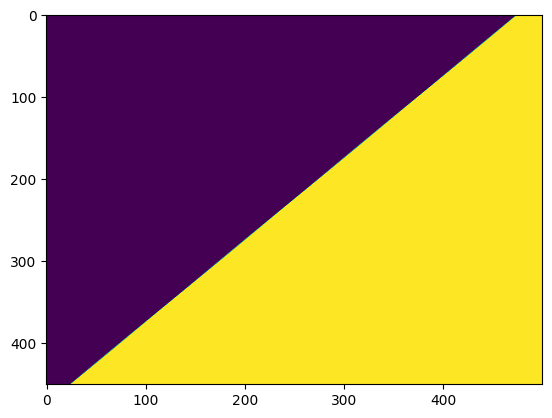

  0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [03:16<06:32, 196.32s/it]

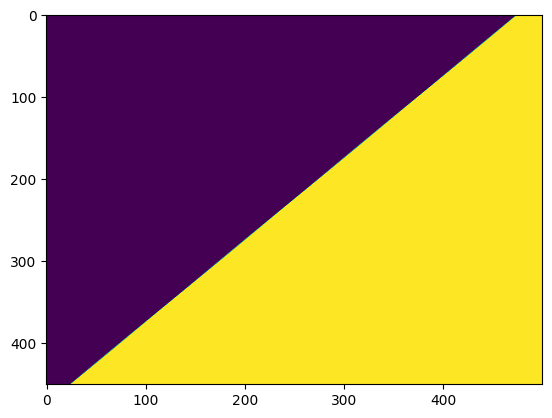

  0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [06:32<03:16, 196.11s/it]

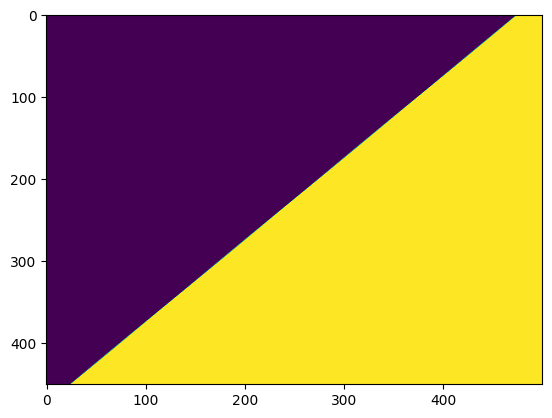

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 3/3 [09:49<00:00, 196.64s/it]


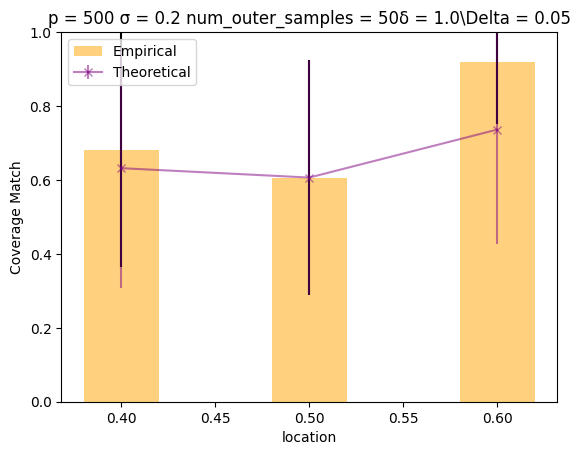

In [9]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 500
σ = 0.2 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0]

seed = 29
nprandom.seed(2*seed)

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

chgpt_location_idx = [0.4, 0.5, 0.6]

coverage_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_coverage_list = [[] for i in range(len(chgpt_location_idx))]

empirical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]

δ = 1.0
n = int(δ * p)
B̃_cov = np.eye(L)
for i in tqdm(range(len(chgpt_location_idx))):

    # true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/20)
    C_s = amp.signal_configuration.generate_C_distanced(n, L, Δ = Δ(n))[1:-1] # Excludes the all zeros case
    # Choose C_true to be the middle point
    C_true = C_s[int(len(C_s)/2)]
    plt.imshow(C_s, aspect='auto')
    plt.show()

    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])]
    ϕ = amp.signal_configuration.C_to_marginal(C_s) 

    # C_true = np.zeros((n, )).astype(int)
    # loc = 0
    # for m in range(len(true_chgpt_locations(n)) + 1):
    #     if len(true_chgpt_locations(n)) == 0:
    #         break
    #     if m >= len(true_chgpt_locations(n)):
    #         C_true[loc:] = m
    #         break
    #     C_true[loc:true_chgpt_locations(n)[m]] = m
    #     loc = true_chgpt_locations(n)[m]

    signal_prior = GaussianSignal(B̃_cov)

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    # --- Set up theoretical coverage ---
    # Compute the fixed-C SE for given chgpt location
    ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

    # Sample Z, V_\Theta
    num_outer_samples = 50
    # Sample Z
    # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_outer_samples)))).reshape(num_outer_samples, n, L)
    # # Sample V̄_Θ
    # V_Θ = (Z @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
    #     jnp.zeros(L), κ_T_fixed, size=n))).reshape(num_outer_samples, n, L)
    # ε = np.array(nprandom.normal(0, σ, size=(num_outer_samples, n)))

    norm_sq_corr_1_list = []
    norm_sq_corr_2_list = []
    norm_sq_corr_1_SE_list = []
    norm_sq_corr_2_SE_list = []
    for k in tqdm(range(num_outer_samples)):
        # --- Set up empirical coverage ---
        # Gaussian Prior
        B̃ = signal_prior.sample(p)
        B̂_0 = signal_prior.sample(p)

        # Generate the observation vector Y
        X = np.random.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        Y = q(Θ, C_true, σ) 

        # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
        # ν = ν_arr[-1]
        # κ_T = κ_T_arr[-1]
        # ν_fixed = ν_fixed_arr[-1]
        # κ_T_fixed = κ_T_fixed_arr[-1]

        B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν


        norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        norm_sq_corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
        norm_sq_corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))
        # print("norm_sq_corr_1_list: ", norm_sq_corr_1_list)
        # print("norm_sq_corr_2_list: ", norm_sq_corr_2_list)
        # print("norm_sq_corr_1_SE_list: ", norm_sq_corr_1_SE_list)
        # print("norm_sq_corr_2_SE_list: ", norm_sq_corr_2_SE_list)


        # # Sqcorr plots
        # plt.errorbar([δ], np.mean(norm_sq_corr_1_list), yerr = np.std(norm_sq_corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
        # plt.errorbar([δ], np.mean(norm_sq_corr_2_list), yerr = np.std(norm_sq_corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
        # plt.scatter([δ], norm_sq_corr_1_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[0])
        # plt.scatter([δ], norm_sq_corr_2_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[2])
        # plt.ylim((0, 1))
        # plt.xlabel("δ")
        # plt.ylabel("Norm Sq Corr")
        # plt.legend()
        # plt.show()

        # B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
 
        # --- Compute Credible Set from AMP ---
        # Compute the credible set S(Θ_t, Y)
        # post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
        post_Θ_Y = amp.posterior.compute_posterior(C_s, Θ_t, Y, n, ρ, σ, ν, κ_T)
        α_CI = 0.05
        # plt.plot(post_Θ_Y, color='purple', alpha=0.1)
        # plt.show()
        try:
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) 
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set(L, α_CI, C_s, post_Θ_Y)
            S_lower_AMP, S_upper_AMP = amp.posterior.left_sided_credible_set_C(L, α_CI, C_s, post_Θ_Y)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        # S_lower_upper_list[i].append((S_lower, S_upper))
        # print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower_AMP:S_upper_AMP].sum())
        # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])
        empirical_credible_set_list[i].append((S_lower_AMP, S_upper_AMP))

        # --- Compute Credible Set from theoretical ---
        # Compute the credible set S(Θ_t, Y)
        Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
        # Sample V̄_Θ
        V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
        # post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
        post_V_q = amp.posterior.compute_posterior(C_s, V_Θ_i, q(Z_i, C_true, σ), n, ρ, σ, ν, κ_T)
        α_CI = 0.05
        # plt.plot(post_V_q, color='orange', alpha=0.1)
        try:
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_V_q) 
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set(L, α_CI, C_s, post_V_q)
            S_lower_theory, S_upper_theory = amp.posterior.left_sided_credible_set_C(L, α_CI, C_s, post_V_q)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        theoretical_credible_set_list[i].append((S_lower_theory, S_upper_theory))

        ### --- Estimate Expected coverage, with ensemble variables --- ###
        ## Sample Z, V̄_Θ, ε̄. 
        # num_samples = 100
        # # Sample Z
        # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # # Sample V̄_Θ
        # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
        #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

        ## Sample Z, V̄_Θ, ε̄. 
        num_samples = 300
        # Sample Z
        Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # Sample V̄_Θ
        V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
        Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n

        comp_post_mapped = jax.vmap(amp.posterior.compute_posterior, in_axes=(None, 0, 0, None, None, None, None, None), out_axes=0)
        post_res = comp_post_mapped(C_s, V̄_θ, Ȳ, n, ρ, σ, ν, κ_T)
        coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
        theoretical_coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_theory:S_upper_theory], axis = 1)

        # for j in range(num_samples):
        #     Ȳ = q(Z[j].reshape((n, L)), C_true, σ)
        #     # post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
        #     post_V_Z_eval = amp.posterior.compute_posterior(C_s, V̄_θ[j], Ȳ, n, ρ, σ, ν, κ_T)
        #     # plt.plot(post_V_Z_eval, color='orange', alpha=0.1)
        #     # plt.show()
        #     # if S_lower is not None:
        #     #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
        #     coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_AMP:S_upper_AMP]))
        #     theoretical_coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_theory:S_upper_theory]))
            # else:
            #     coverage_list[i].append(None)
        # print("Empirical coverage: ", np.mean(coverage_list[i]))
        # print("Theoretical coverage: ", np.mean(theoretical_coverage_list[i]))
        # Add x-ticks where S_lower and S_upper are
        # plt.axvline(x=S_lower_AMP, color='black', linestyle='--')
        # plt.axvline(x=S_upper_AMP, color='black', linestyle='--')
        # plt.axvline(x=S_lower_theory, color='blue', linestyle='-.')
        # plt.axvline(x=S_upper_theory, color='blue', linestyle='-.')
        # plt.title("Posterior over η")
        # plt.show()

### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
# plt.title(str("p = ", str(p), " σ = ", str(σ), " num_outer_samples = ", str(num_outer_samples), "δ = ", str(δ), "\Delta = ", str(Δ(n)/n)))
plt.title(str("p = " + str(p) + " σ = " + str(σ) + " num_outer_samples = " + str(num_outer_samples) +  "δ = " +  str(δ) + "\Delta = " + str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 1))
plt.show()




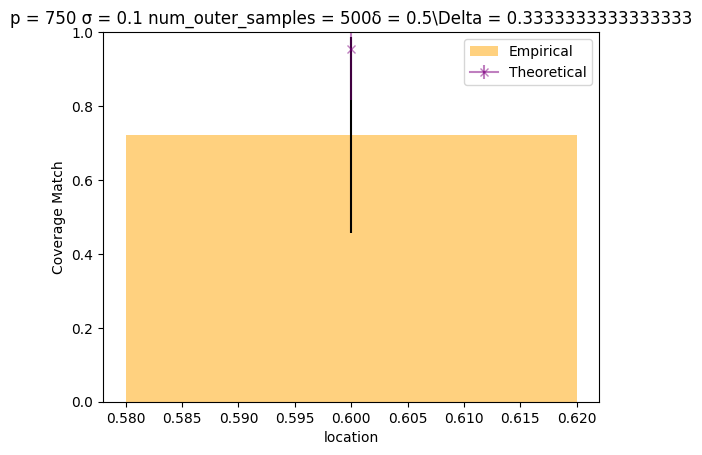

In [6]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title(str("p = " + str(p) + " σ = " + str(σ) + " num_outer_samples = " + str(num_outer_samples) +  "δ = " +  str(δ) + "\Delta = " + str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 1))
plt.show()


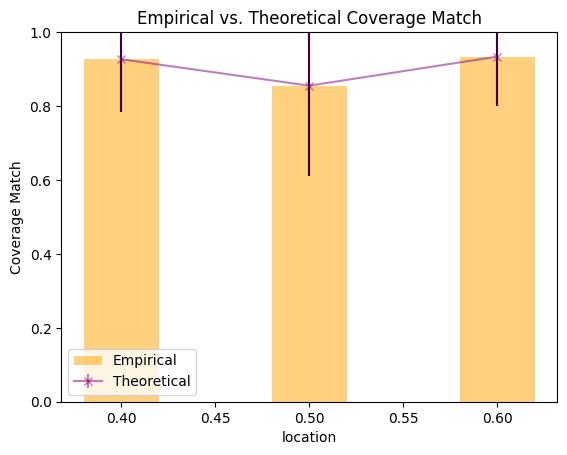

In [5]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
fig = plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
tikzplotlib_fix_ncols(fig)
# plt.savefig("post_cov_1.pdf")
import tikzplotlib
tikzplotlib.save("post_cov_1.tex")
plt.show()

### Centred credible set experiment, finding the first changepoint

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:35<00:00, 35.59s/it]


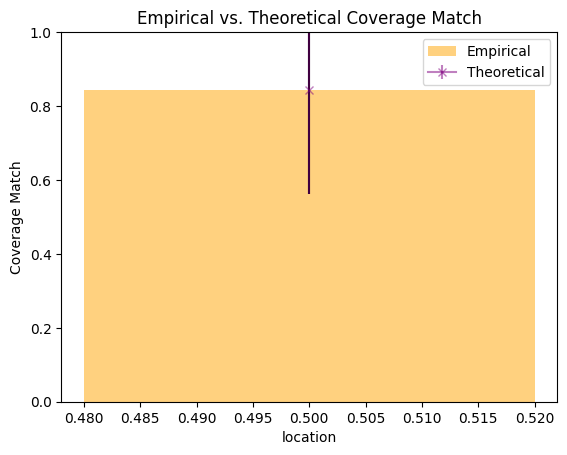

In [4]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 500
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0]

seed = 29
nprandom.seed(2*seed)

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

# chgpt_location_idx = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
chgpt_location_idx = [0.5]

coverage_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_coverage_list = [[] for i in range(len(chgpt_location_idx))]

empirical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]

δ = 1.0
n = int(δ * p)
B̃_cov = np.eye(L)

# --- Preliminaries ---
# Changepoint locations
Δ = lambda n: int(n/4)
C_s = amp.signal_configuration.generate_C_distanced(n, L, Δ = Δ(n))[1:-1] # Excludes the all zeros case
for i in tqdm(range(len(chgpt_location_idx))):

    # true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 

    # plt.imshow(C_s, aspect='auto')
    # plt.show()

    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])]
    ϕ = amp.signal_configuration.C_to_marginal(C_s) 

    C_true = np.zeros((n, )).astype(int)
    loc = 0
    for m in range(len(true_chgpt_locations(n)) + 1):
        if len(true_chgpt_locations(n)) == 0:
            break
        if m >= len(true_chgpt_locations(n)):
            C_true[loc:] = m
            break
        C_true[loc:true_chgpt_locations(n)[m]] = m
        loc = true_chgpt_locations(n)[m]

    signal_prior = GaussianSignal(B̃_cov)

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    # --- Set up theoretical coverage ---
    # Compute the fixed-C SE for given chgpt location
    ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

    # Sample Z, V_\Theta
    num_outer_samples = 3
    # Sample Z
    # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_outer_samples)))).reshape(num_outer_samples, n, L)
    # # Sample V̄_Θ
    # V_Θ = (Z @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
    #     jnp.zeros(L), κ_T_fixed, size=n))).reshape(num_outer_samples, n, L)
    # ε = np.array(nprandom.normal(0, σ, size=(num_outer_samples, n)))

    norm_sq_corr_1_list = []
    norm_sq_corr_2_list = []
    norm_sq_corr_1_SE_list = []
    norm_sq_corr_2_SE_list = []
    for k in tqdm(range(num_outer_samples)):
        # --- Set up empirical coverage ---
        # Gaussian Prior
        B̃ = signal_prior.sample(p)
        B̂_0 = signal_prior.sample(p)

        # Generate the observation vector Y
        X = np.random.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        Y = q(Θ, C_true, σ) 

        # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
        # ν = ν_arr[-1]
        # κ_T = κ_T_arr[-1]
        # ν_fixed = ν_fixed_arr[-1]
        # κ_T_fixed = κ_T_fixed_arr[-1]

        B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν


        norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        norm_sq_corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
        norm_sq_corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))
        # print("norm_sq_corr_1_list: ", norm_sq_corr_1_list)
        # print("norm_sq_corr_2_list: ", norm_sq_corr_2_list)
        # print("norm_sq_corr_1_SE_list: ", norm_sq_corr_1_SE_list)
        # print("norm_sq_corr_2_SE_list: ", norm_sq_corr_2_SE_list)


        # # Sqcorr plots
        # plt.errorbar([δ], np.mean(norm_sq_corr_1_list), yerr = np.std(norm_sq_corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
        # plt.errorbar([δ], np.mean(norm_sq_corr_2_list), yerr = np.std(norm_sq_corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
        # plt.scatter([δ], norm_sq_corr_1_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[0])
        # plt.scatter([δ], norm_sq_corr_2_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[2])
        # plt.ylim((0, 1))
        # plt.xlabel("δ")
        # plt.ylabel("Norm Sq Corr")
        # plt.legend()
        # plt.show()

        B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
 
        # --- Compute Credible Set from AMP ---
        # Compute the credible set S(Θ_t, Y)
        # post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
        post_Θ_Y = amp.posterior.compute_posterior(C_s, Θ_t, Y, n, ρ, σ, ν, κ_T)
        α_CI = 0.05
        # plt.plot(post_Θ_Y, color='purple', alpha=0.1)
        # plt.show()
        try:
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) 
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set(L, α_CI, C_s, post_Θ_Y)
            S_lower_AMP, S_upper_AMP = amp.posterior.left_sided_credible_set_C(L, α_CI, C_s, post_Θ_Y)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        # S_lower_upper_list[i].append((S_lower, S_upper))
        # print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower_AMP:S_upper_AMP].sum())
        # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])
        empirical_credible_set_list[i].append((S_lower_AMP, S_upper_AMP))

        # --- Compute Credible Set from theoretical ---
        # Compute the credible set S(Θ_t, Y)
        Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
        # Sample V̄_Θ
        V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
        # post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
        post_V_q = amp.posterior.compute_posterior(C_s, V_Θ_i, q(Z_i, C_true, σ), n, ρ, σ, ν, κ_T)
        α_CI = 0.05
        # plt.plot(post_V_q, color='orange', alpha=0.1)
        try:
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_V_q) 
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set(L, α_CI, C_s, post_V_q)
            S_lower_theory, S_upper_theory = amp.posterior.left_sided_credible_set_C(L, α_CI, C_s, post_V_q)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        theoretical_credible_set_list[i].append((S_lower_theory, S_upper_theory))

        ### --- Estimate Expected coverage, with ensemble variables --- ###
        ## Sample Z, V̄_Θ, ε̄. 
        # num_samples = 100
        # # Sample Z
        # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # # Sample V̄_Θ
        # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
        #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

        ## Sample Z, V̄_Θ, ε̄. 
        num_samples = 100
        # Sample Z
        Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # Sample V̄_Θ
        V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
        Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n

        comp_post_mapped = jax.vmap(amp.posterior.compute_posterior, in_axes=(None, 0, 0, None, None, None, None, None), out_axes=0)
        post_res = comp_post_mapped(C_s, V̄_θ, Ȳ, n, ρ, σ, ν, κ_T)
        coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
        theoretical_coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)

### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))
plt.show()




### Averaging over changepoint locations

  0%|          | 0/166 [00:00<?, ?it/s]

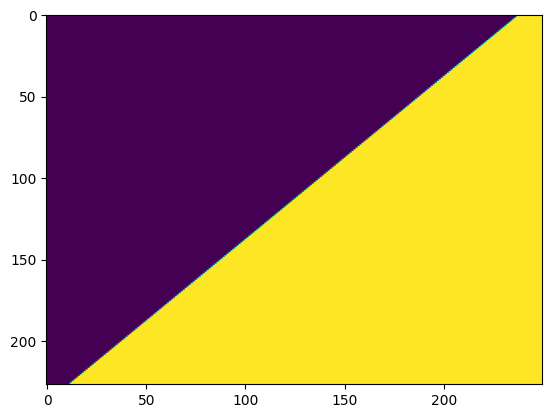

  0%|          | 0/10 [00:00<?, ?it/s]

  1%|          | 1/166 [03:14<8:54:37, 194.41s/it]

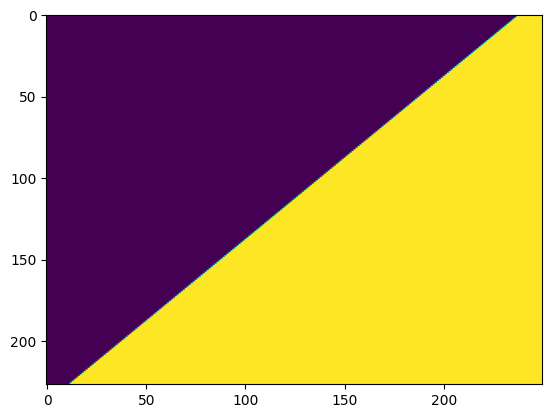

  0%|          | 0/10 [00:00<?, ?it/s]

  1%|          | 2/166 [06:23<8:43:26, 191.50s/it]

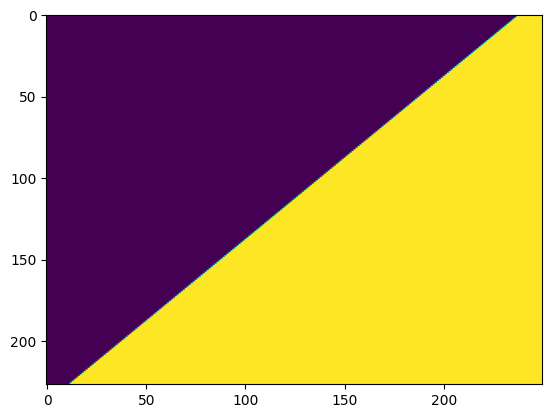

  0%|          | 0/10 [00:00<?, ?it/s]

  2%|▏         | 3/166 [09:34<8:38:43, 190.94s/it]

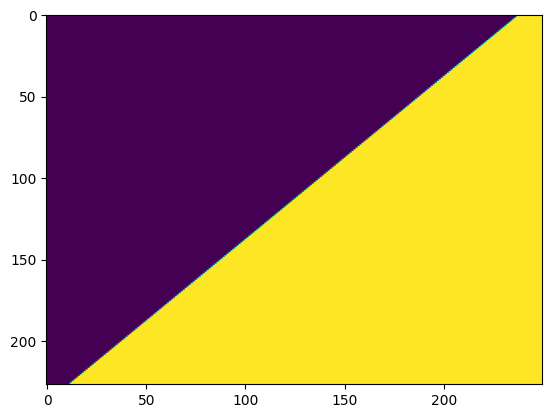

  0%|          | 0/10 [00:00<?, ?it/s]

  2%|▏         | 4/166 [12:46<8:36:47, 191.40s/it]

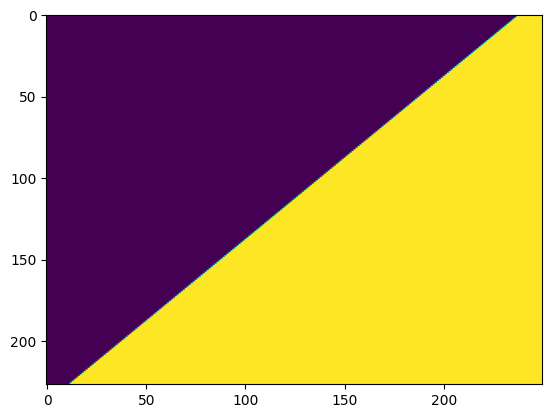

  0%|          | 0/10 [00:00<?, ?it/s]

  3%|▎         | 5/166 [16:00<8:36:19, 192.42s/it]

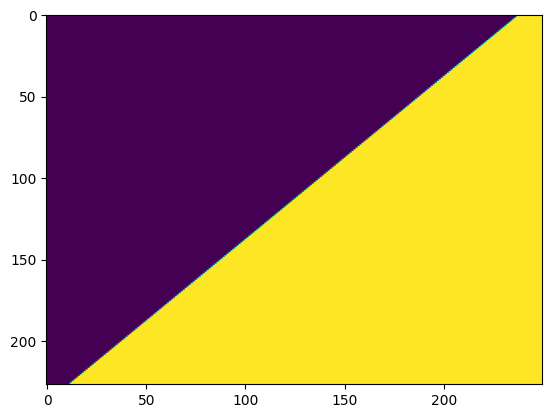

  0%|          | 0/10 [00:00<?, ?it/s]

  4%|▎         | 6/166 [19:13<8:33:35, 192.60s/it]

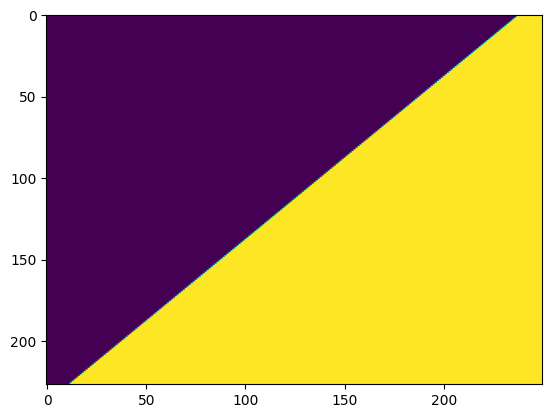

  0%|          | 0/10 [00:00<?, ?it/s]

  4%|▍         | 7/166 [22:27<8:31:32, 193.03s/it]

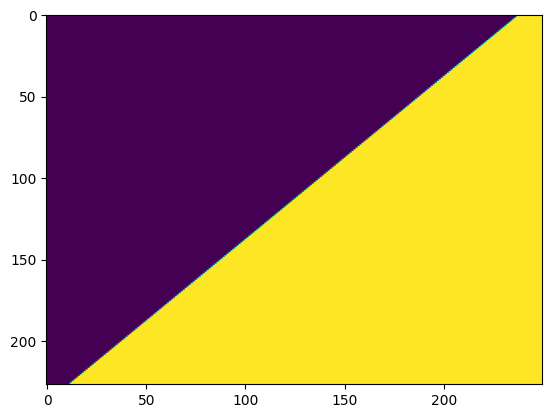

  0%|          | 0/10 [00:00<?, ?it/s]

  5%|▍         | 8/166 [25:41<8:29:14, 193.38s/it]

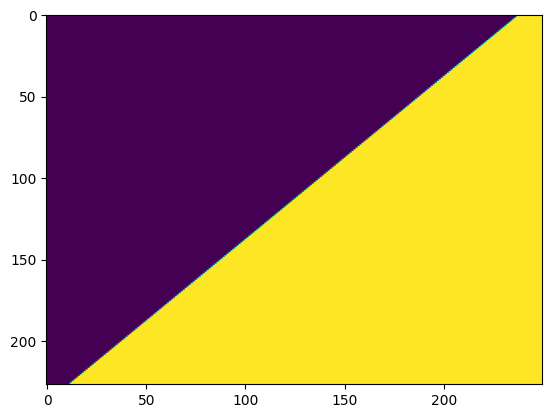

  0%|          | 0/10 [00:00<?, ?it/s]

  5%|▌         | 9/166 [28:55<8:26:14, 193.47s/it]

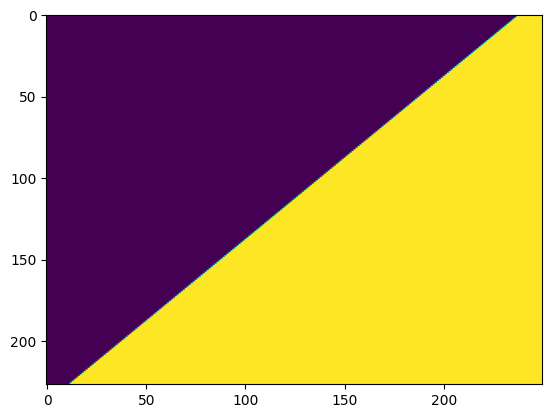

  0%|          | 0/10 [00:00<?, ?it/s]

  6%|▌         | 10/166 [32:09<8:23:46, 193.76s/it]

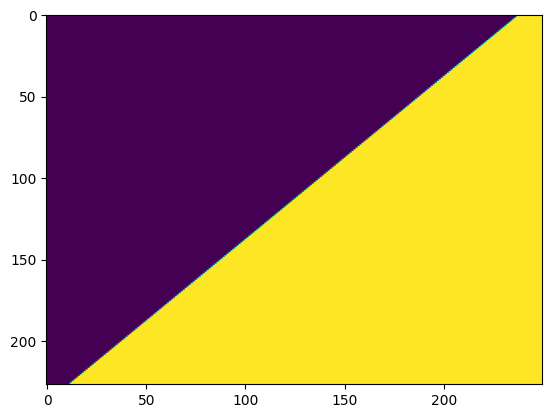

  0%|          | 0/10 [00:00<?, ?it/s]

  7%|▋         | 11/166 [35:20<8:18:21, 192.91s/it]

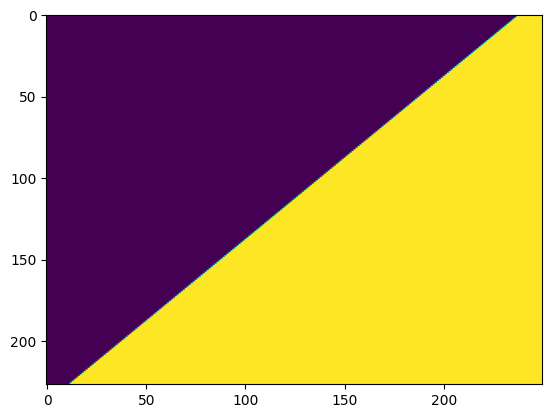

  0%|          | 0/10 [00:00<?, ?it/s]

  7%|▋         | 12/166 [38:34<8:15:45, 193.16s/it]

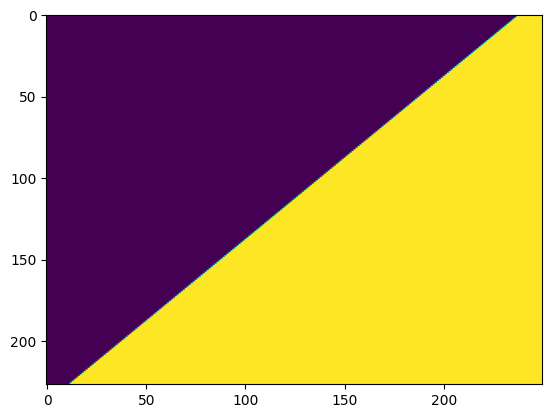

  0%|          | 0/10 [00:00<?, ?it/s]

  8%|▊         | 13/166 [41:46<8:11:57, 192.93s/it]

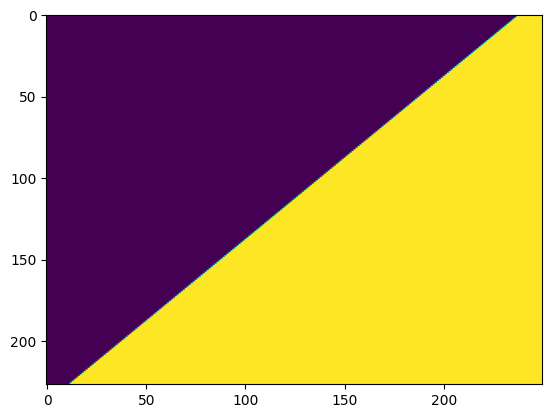

  0%|          | 0/10 [00:00<?, ?it/s]

  8%|▊         | 14/166 [45:00<8:09:28, 193.22s/it]

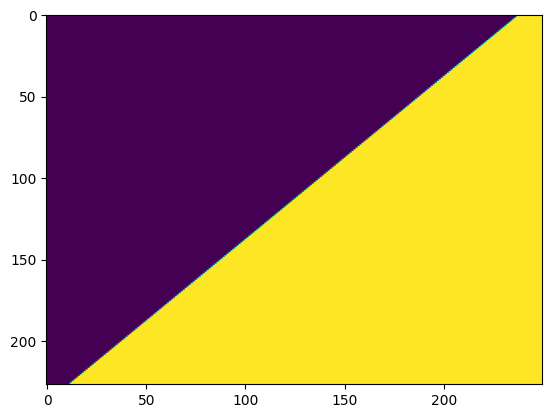

  0%|          | 0/10 [00:00<?, ?it/s]

  9%|▉         | 15/166 [48:13<8:06:19, 193.24s/it]

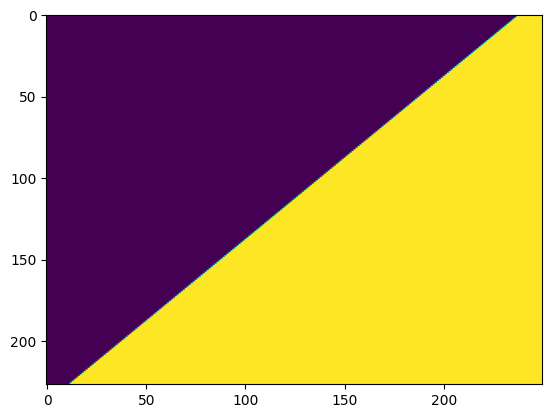

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|▉         | 16/166 [51:26<8:02:59, 193.20s/it]

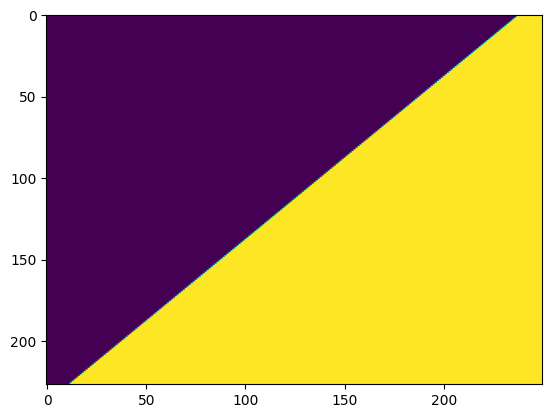

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 17/166 [54:41<8:00:53, 193.65s/it]

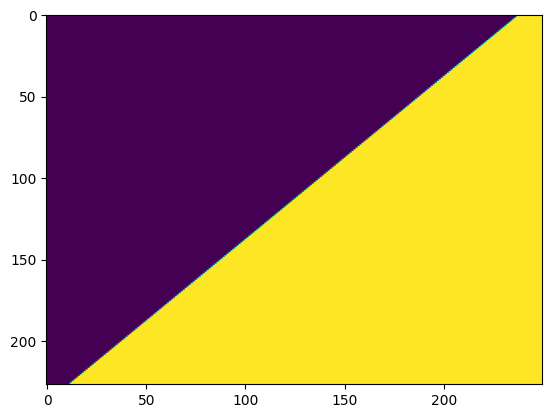

  0%|          | 0/10 [00:00<?, ?it/s]

 11%|█         | 18/166 [57:53<7:56:27, 193.16s/it]

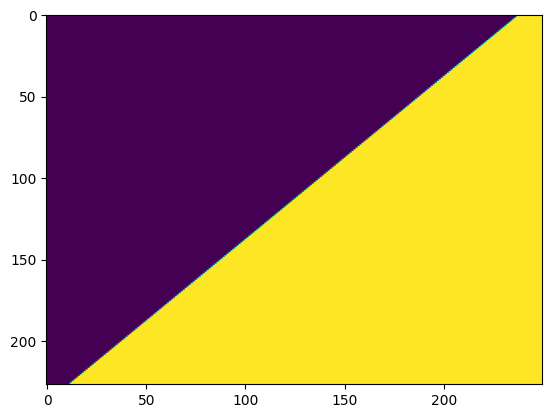

  0%|          | 0/10 [00:00<?, ?it/s]

 11%|█▏        | 19/166 [1:01:07<7:53:56, 193.44s/it]

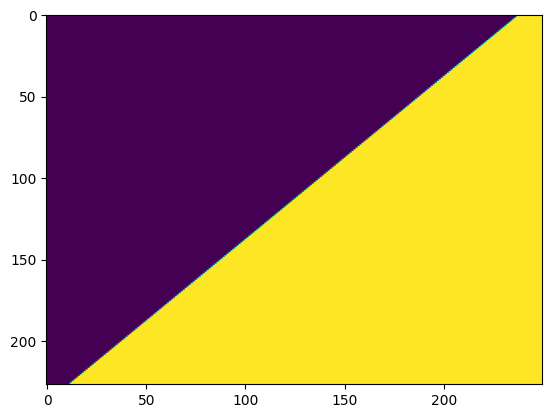

  0%|          | 0/10 [00:00<?, ?it/s]

 12%|█▏        | 20/166 [1:04:21<7:50:57, 193.55s/it]

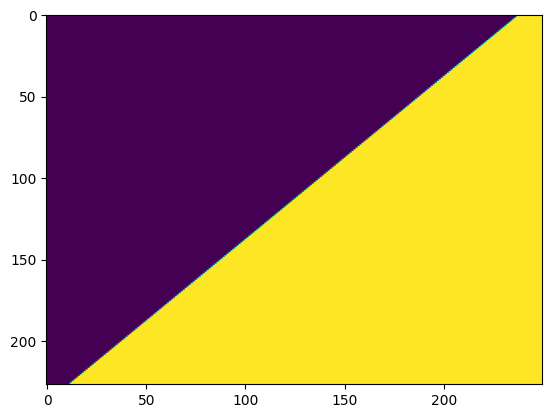

  0%|          | 0/10 [00:00<?, ?it/s]

 13%|█▎        | 21/166 [1:07:34<7:47:32, 193.47s/it]

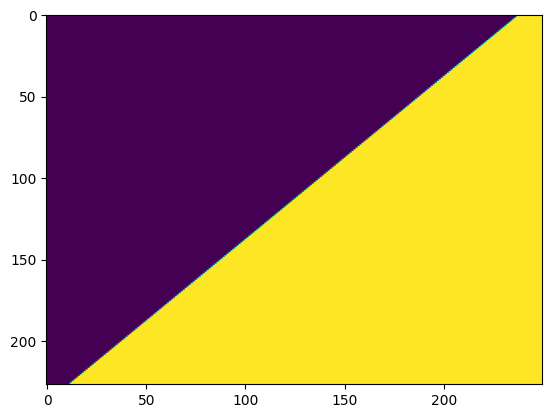

  0%|          | 0/10 [00:00<?, ?it/s]

 13%|█▎        | 22/166 [1:10:50<7:46:09, 194.23s/it]

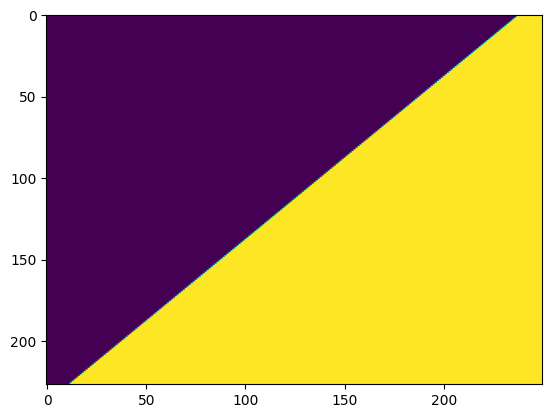

  0%|          | 0/10 [00:00<?, ?it/s]

 14%|█▍        | 23/166 [1:14:04<7:42:47, 194.18s/it]

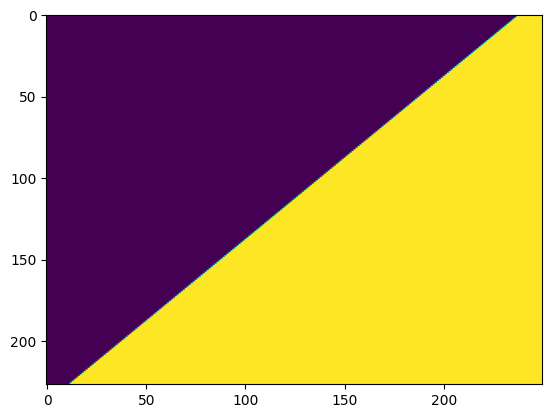

  0%|          | 0/10 [00:00<?, ?it/s]

 14%|█▍        | 24/166 [1:17:18<7:39:03, 193.97s/it]

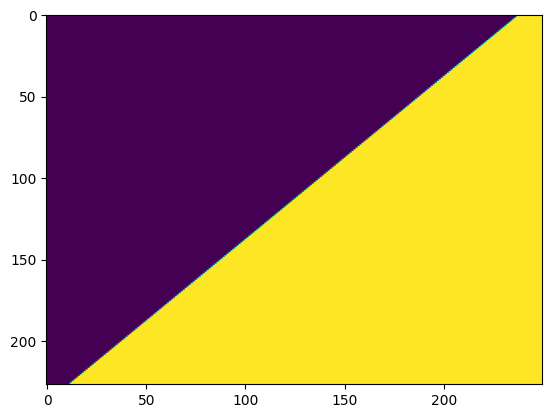

  0%|          | 0/10 [00:00<?, ?it/s]

 15%|█▌        | 25/166 [1:20:31<7:35:16, 193.74s/it]

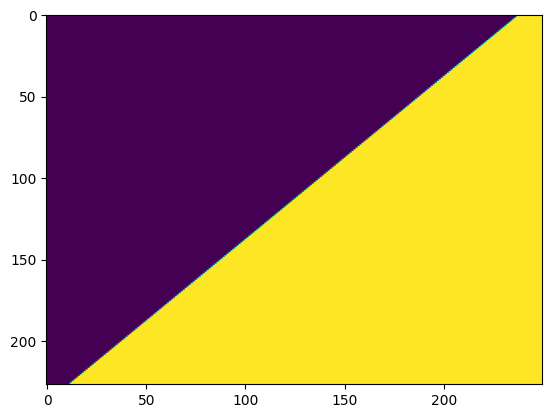

  0%|          | 0/10 [00:00<?, ?it/s]

 16%|█▌        | 26/166 [1:23:47<7:33:19, 194.28s/it]

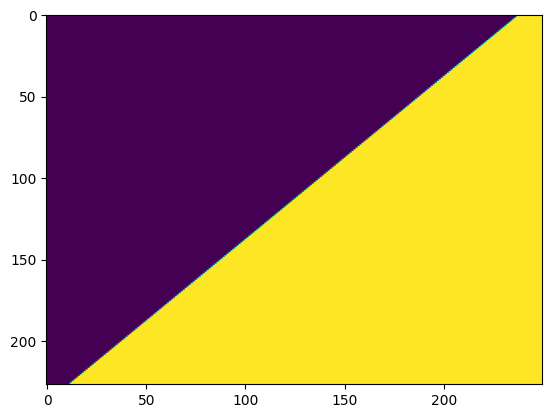

  0%|          | 0/10 [00:00<?, ?it/s]

 16%|█▋        | 27/166 [1:27:02<7:31:02, 194.70s/it]

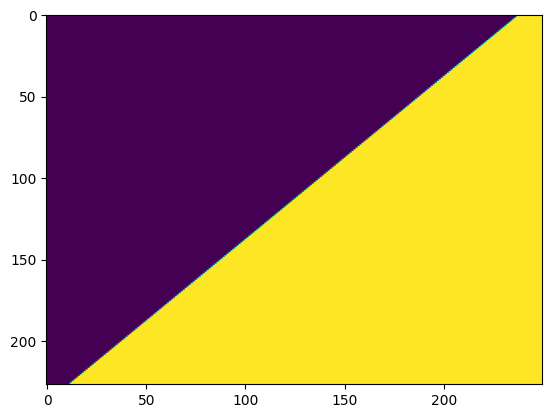

  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 28/166 [1:30:17<7:27:54, 194.75s/it]

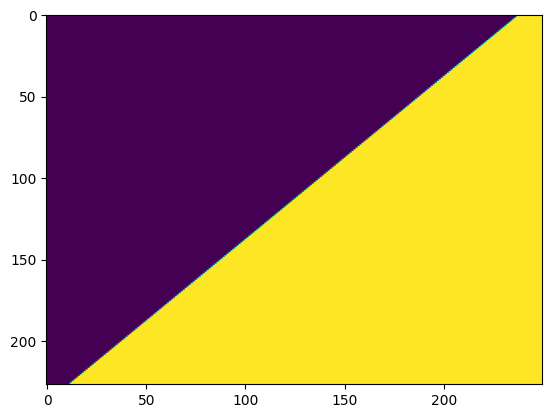

  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 29/166 [1:33:30<7:23:41, 194.32s/it]

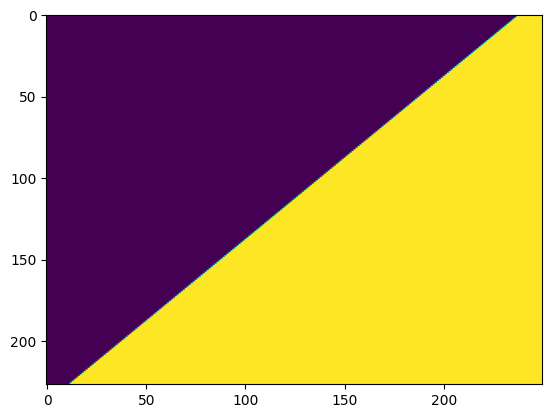

  0%|          | 0/10 [00:00<?, ?it/s]

 18%|█▊        | 30/166 [1:36:44<7:20:06, 194.17s/it]

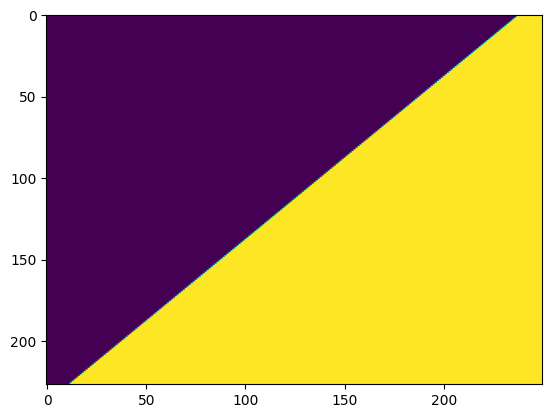

  0%|          | 0/10 [00:00<?, ?it/s]

 19%|█▊        | 31/166 [1:39:57<7:15:45, 193.67s/it]

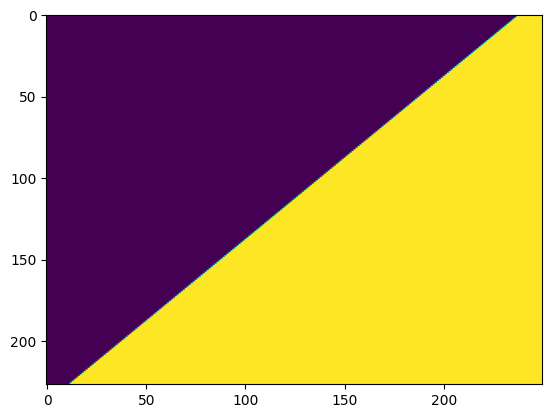

  0%|          | 0/10 [00:00<?, ?it/s]

 19%|█▉        | 32/166 [1:43:11<7:13:12, 193.97s/it]

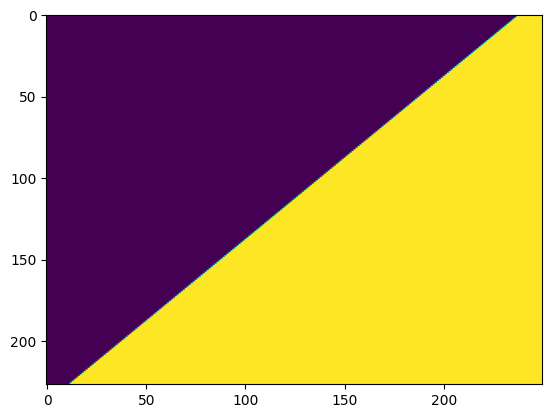

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|█▉        | 33/166 [1:46:27<7:10:56, 194.41s/it]

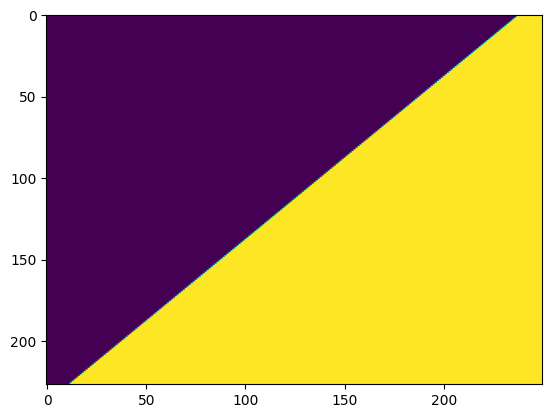

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 34/166 [1:49:41<7:07:42, 194.42s/it]

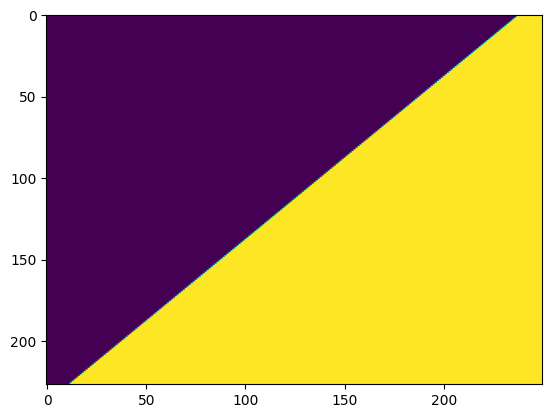

  0%|          | 0/10 [00:00<?, ?it/s]

 21%|██        | 35/166 [1:52:56<7:04:56, 194.63s/it]

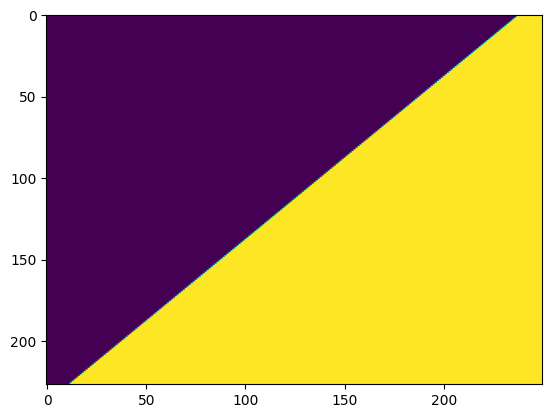

  0%|          | 0/10 [00:00<?, ?it/s]

 22%|██▏       | 36/166 [1:56:12<7:02:00, 194.77s/it]

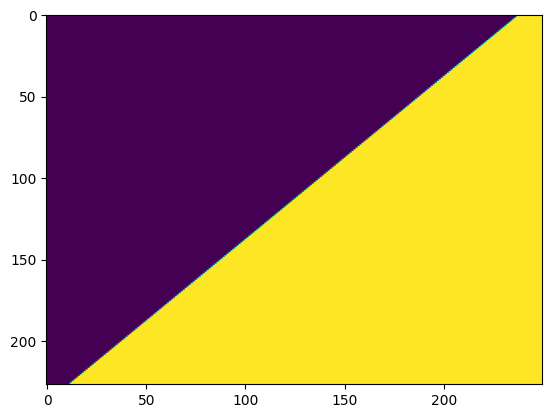

  0%|          | 0/10 [00:00<?, ?it/s]

 22%|██▏       | 37/166 [1:59:28<6:59:42, 195.21s/it]

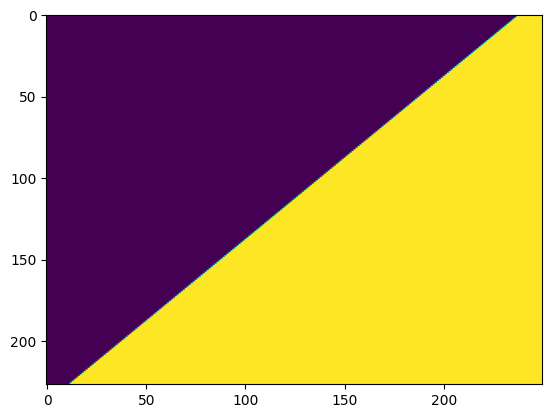

  0%|          | 0/10 [00:00<?, ?it/s]

 23%|██▎       | 38/166 [2:02:43<6:56:19, 195.16s/it]

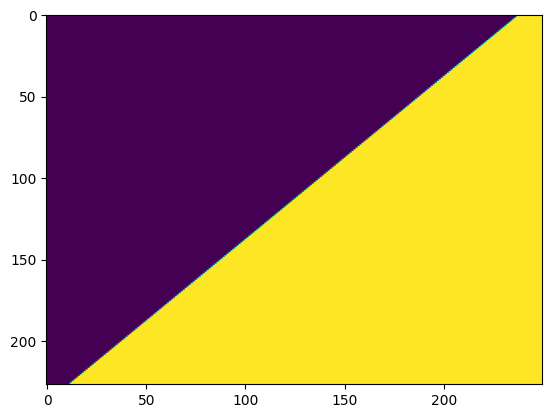

  0%|          | 0/10 [00:00<?, ?it/s]

 23%|██▎       | 39/166 [2:05:59<6:53:27, 195.34s/it]

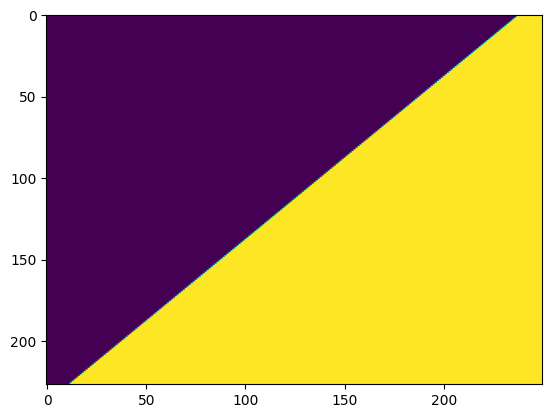

  0%|          | 0/10 [00:00<?, ?it/s]

 24%|██▍       | 40/166 [2:09:14<6:50:30, 195.48s/it]

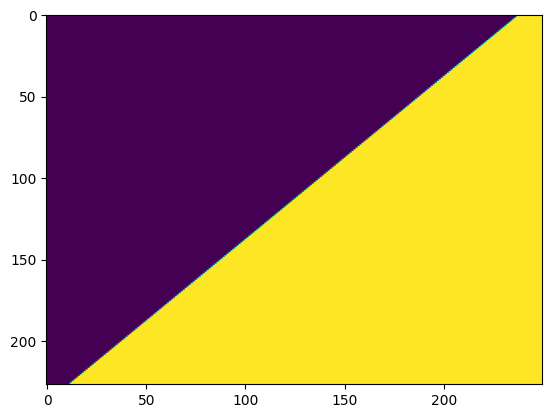

  0%|          | 0/10 [00:00<?, ?it/s]

 25%|██▍       | 41/166 [2:12:32<6:48:16, 195.97s/it]

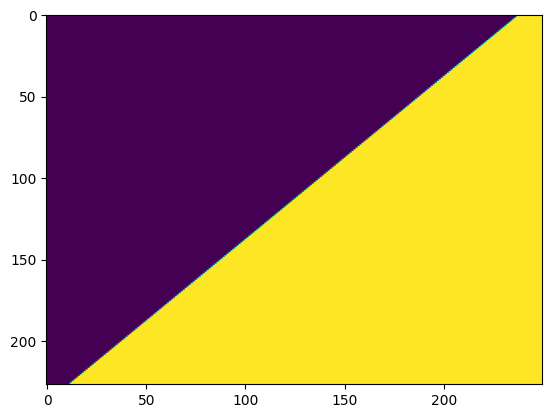

  0%|          | 0/10 [00:00<?, ?it/s]

 25%|██▌       | 42/166 [2:15:45<6:43:37, 195.30s/it]

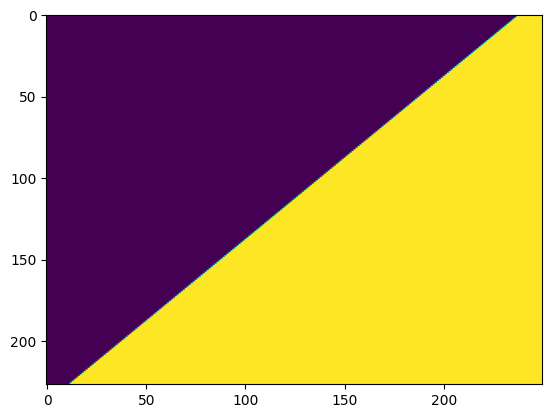

  0%|          | 0/10 [00:00<?, ?it/s]

 26%|██▌       | 43/166 [2:19:01<6:40:35, 195.41s/it]

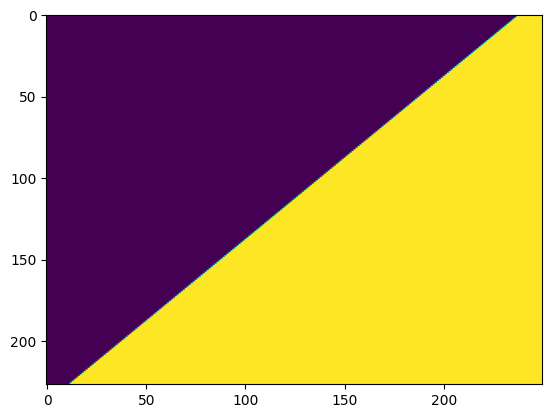

  0%|          | 0/10 [00:00<?, ?it/s]

 27%|██▋       | 44/166 [2:22:19<6:38:41, 196.08s/it]

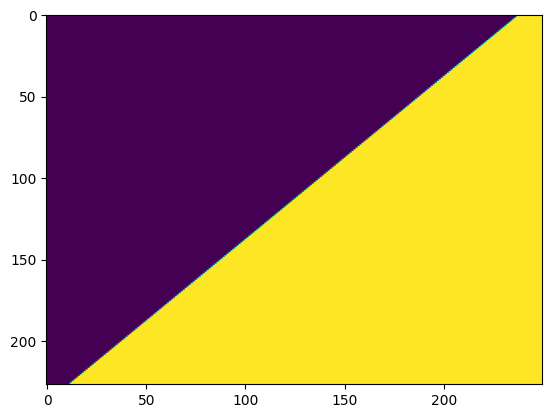

  0%|          | 0/10 [00:00<?, ?it/s]

 27%|██▋       | 45/166 [2:25:34<6:35:13, 195.98s/it]

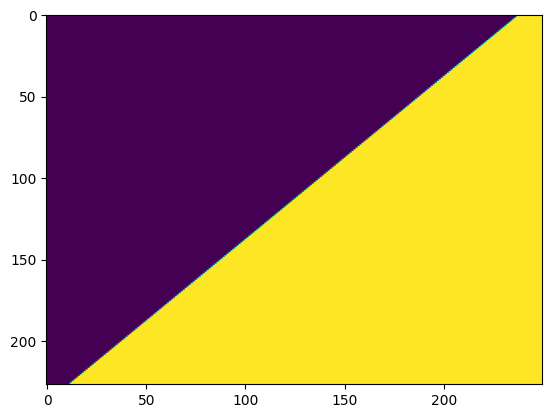

  0%|          | 0/10 [00:00<?, ?it/s]

 28%|██▊       | 46/166 [2:28:51<6:32:22, 196.18s/it]

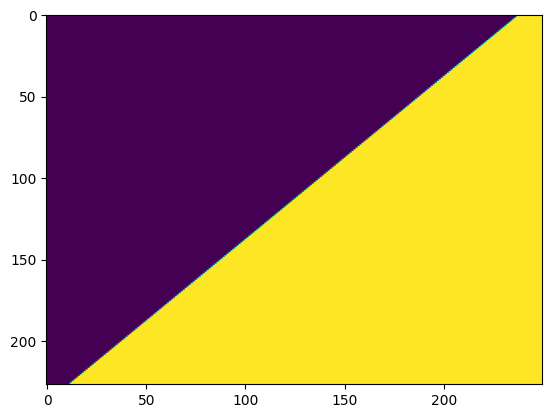

  0%|          | 0/10 [00:00<?, ?it/s]

 28%|██▊       | 47/166 [2:32:06<6:28:41, 195.98s/it]

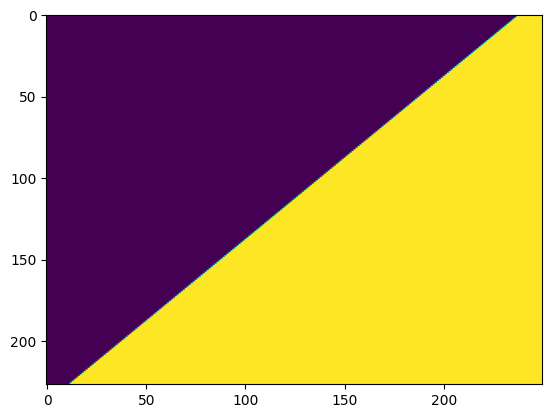

  0%|          | 0/10 [00:00<?, ?it/s]

 29%|██▉       | 48/166 [2:35:21<6:24:47, 195.66s/it]

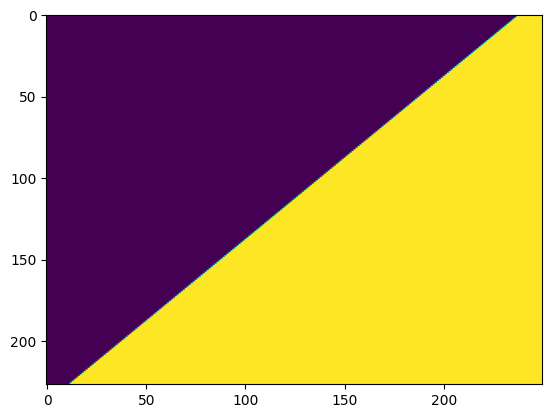

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|██▉       | 49/166 [2:38:38<6:21:56, 195.87s/it]

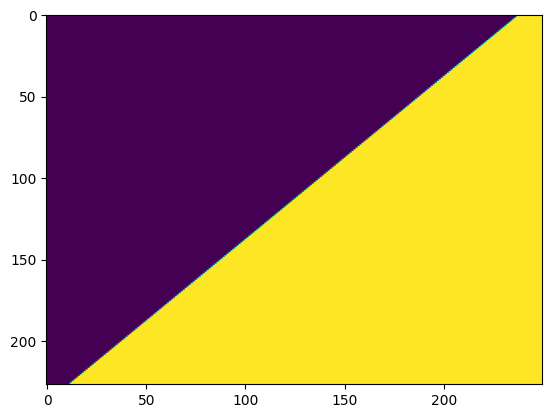

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 50/166 [2:41:54<6:18:47, 195.93s/it]

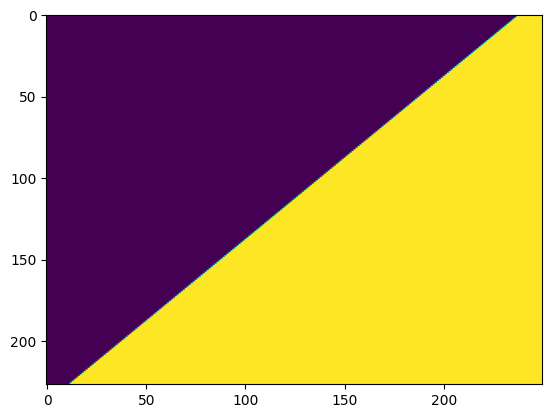

  0%|          | 0/10 [00:00<?, ?it/s]

 31%|███       | 51/166 [2:45:10<6:15:46, 196.05s/it]

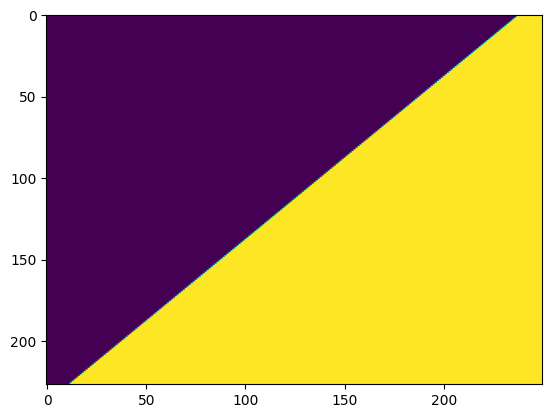

  0%|          | 0/10 [00:00<?, ?it/s]

 31%|███▏      | 52/166 [2:48:26<6:12:22, 195.99s/it]

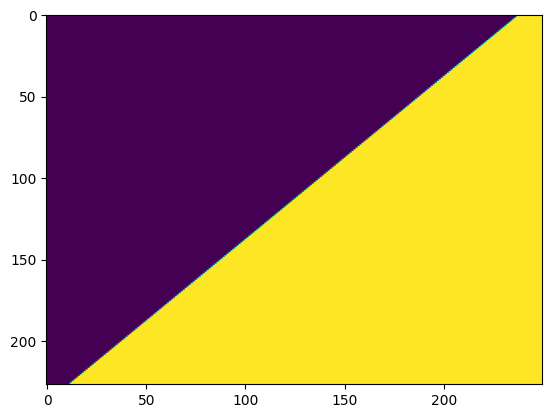

  0%|          | 0/10 [00:00<?, ?it/s]

 32%|███▏      | 53/166 [2:51:41<6:08:49, 195.84s/it]

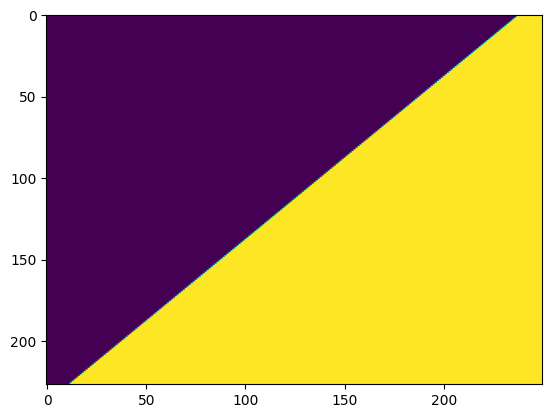

  0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 54/166 [2:54:57<6:05:24, 195.75s/it]

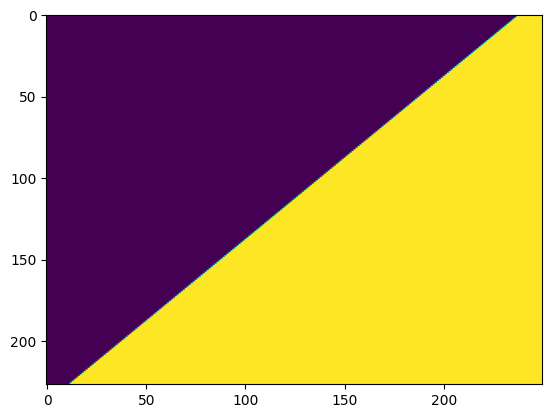

  0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 55/166 [2:58:13<6:02:16, 195.82s/it]

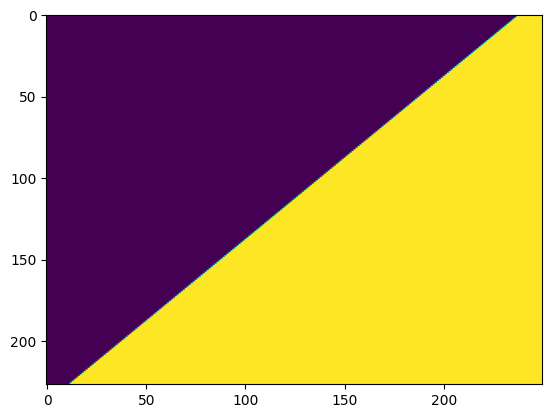

  0%|          | 0/10 [00:00<?, ?it/s]

 34%|███▎      | 56/166 [3:01:28<5:58:43, 195.67s/it]

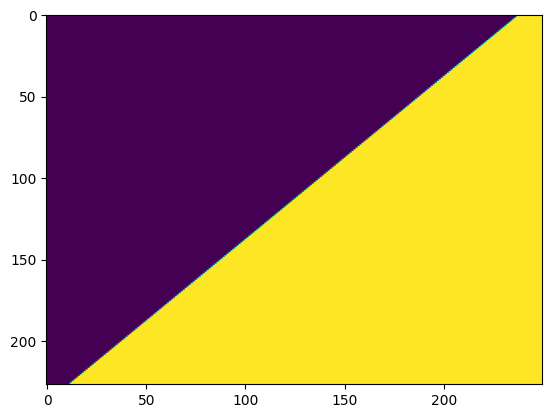

  0%|          | 0/10 [00:00<?, ?it/s]

 34%|███▍      | 57/166 [3:04:44<5:55:24, 195.64s/it]

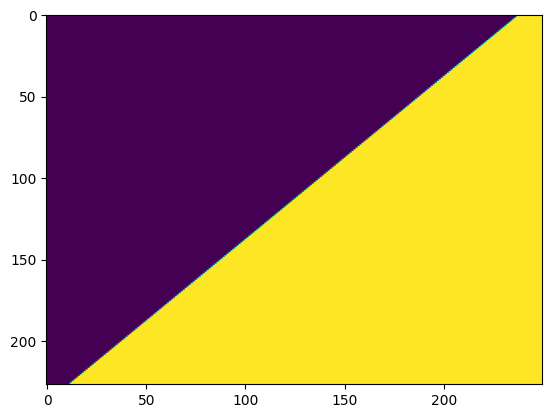

  0%|          | 0/10 [00:00<?, ?it/s]

 35%|███▍      | 58/166 [3:07:58<5:51:32, 195.30s/it]

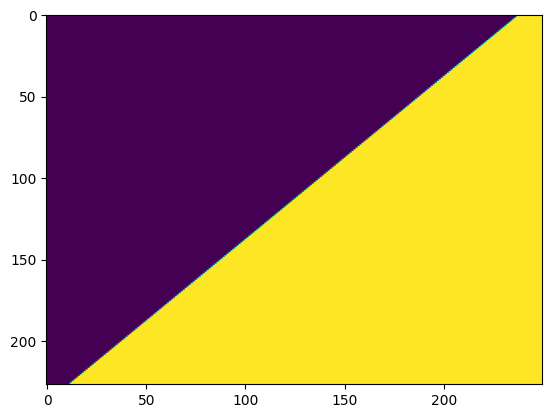

  0%|          | 0/10 [00:00<?, ?it/s]

 36%|███▌      | 59/166 [3:11:15<5:49:02, 195.73s/it]

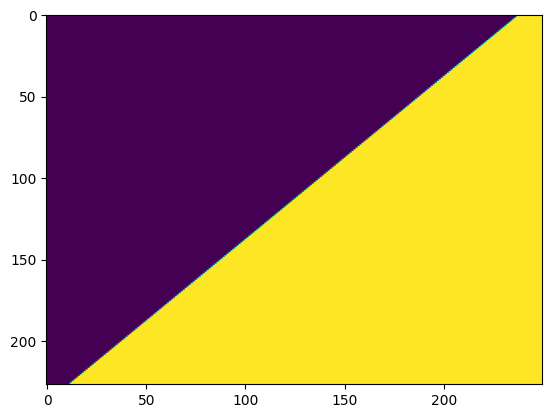

  0%|          | 0/10 [00:00<?, ?it/s]

 36%|███▌      | 60/166 [3:14:30<5:45:32, 195.59s/it]

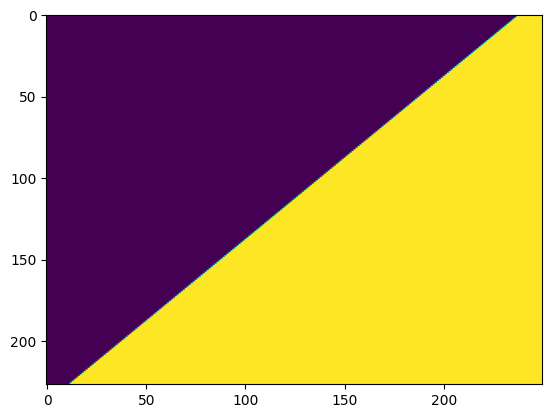

  0%|          | 0/10 [00:00<?, ?it/s]

 37%|███▋      | 61/166 [3:17:45<5:41:58, 195.41s/it]

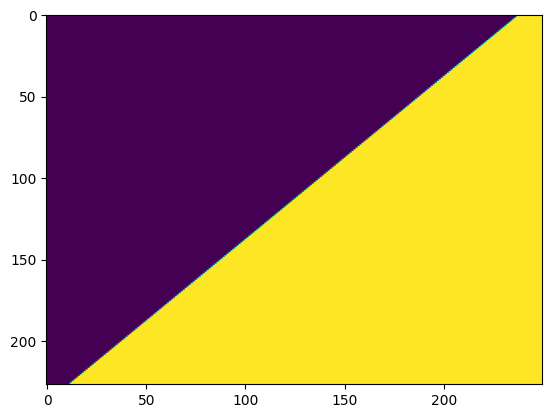

  0%|          | 0/10 [00:00<?, ?it/s]

 37%|███▋      | 62/166 [3:21:02<5:39:21, 195.78s/it]

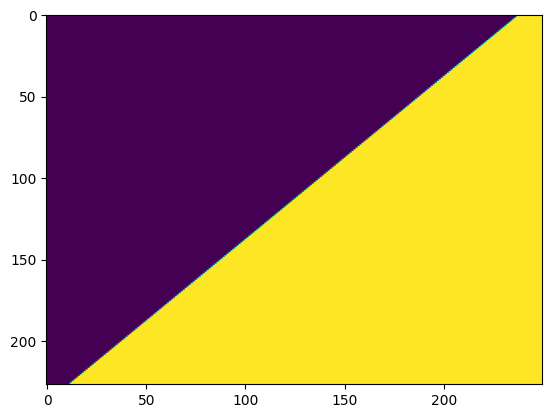

  0%|          | 0/10 [00:00<?, ?it/s]

 38%|███▊      | 63/166 [3:24:20<5:37:21, 196.52s/it]

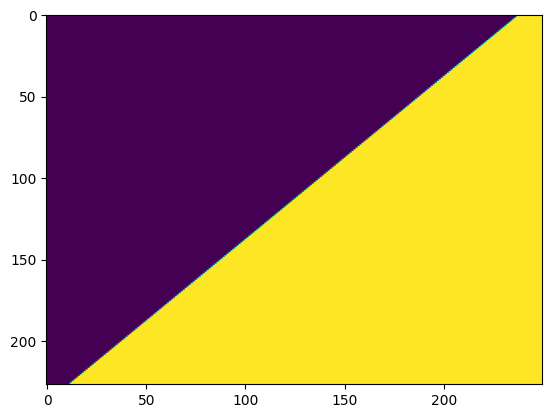

  0%|          | 0/10 [00:00<?, ?it/s]

 39%|███▊      | 64/166 [3:27:37<5:34:23, 196.70s/it]

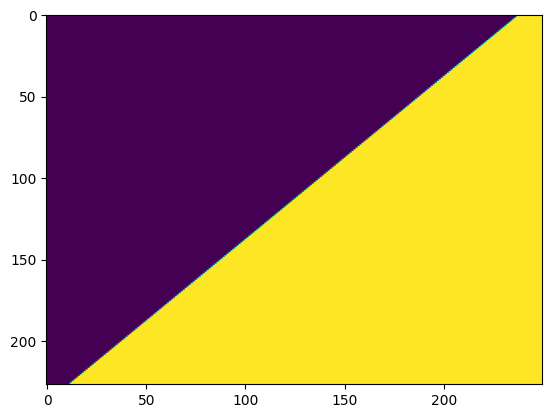

  0%|          | 0/10 [00:00<?, ?it/s]

 39%|███▉      | 65/166 [3:30:54<5:31:04, 196.67s/it]

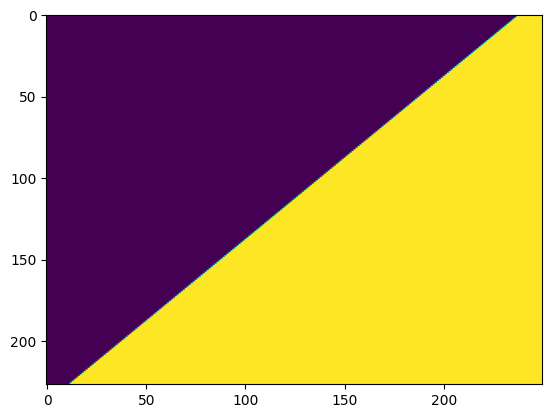

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|███▉      | 66/166 [3:34:09<5:27:06, 196.26s/it]

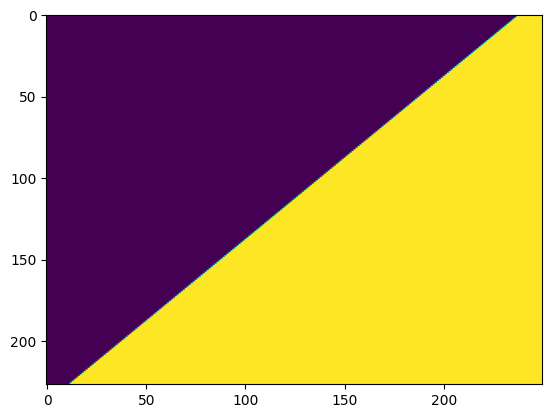

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 67/166 [3:37:27<5:24:18, 196.55s/it]

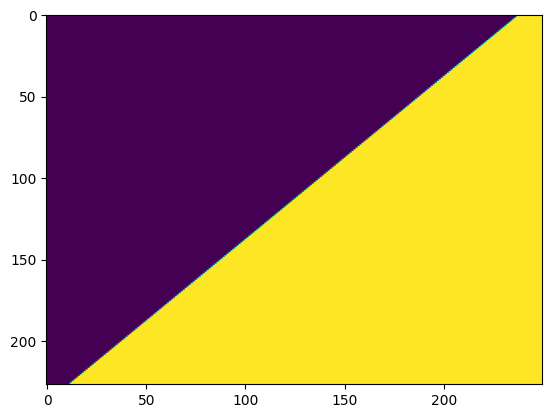

  0%|          | 0/10 [00:00<?, ?it/s]

 41%|████      | 68/166 [3:40:44<5:21:21, 196.75s/it]

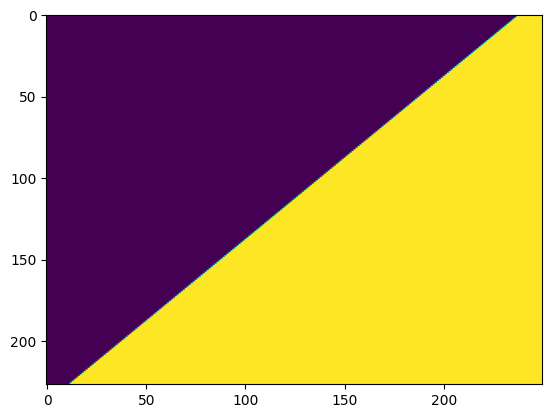

  0%|          | 0/10 [00:00<?, ?it/s]

 42%|████▏     | 69/166 [3:44:00<5:17:45, 196.55s/it]

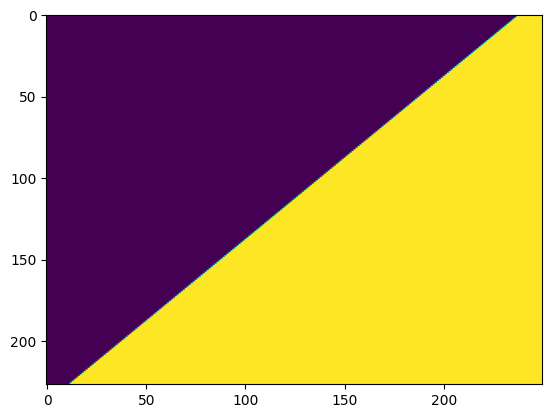

  0%|          | 0/10 [00:00<?, ?it/s]

 42%|████▏     | 70/166 [3:47:16<5:14:19, 196.45s/it]

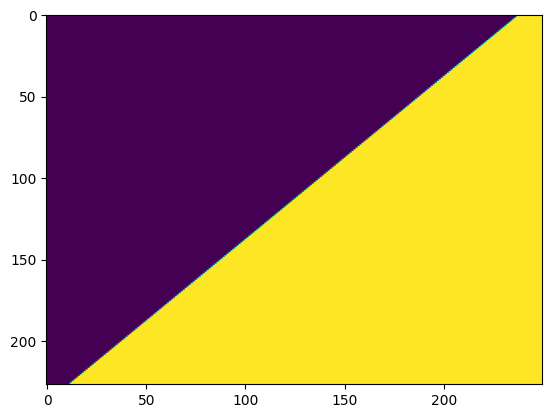

  0%|          | 0/10 [00:00<?, ?it/s]

 43%|████▎     | 71/166 [3:50:34<5:11:44, 196.89s/it]

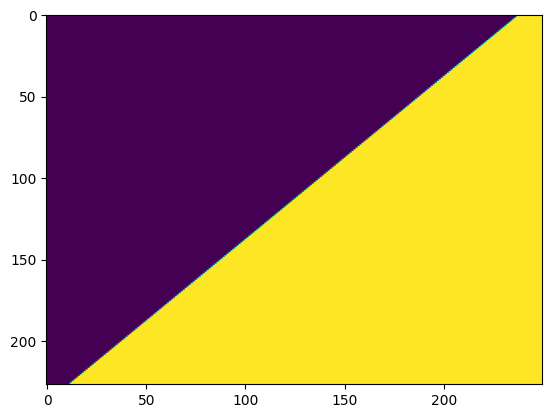

  0%|          | 0/10 [00:00<?, ?it/s]

 43%|████▎     | 72/166 [3:53:51<5:08:25, 196.87s/it]

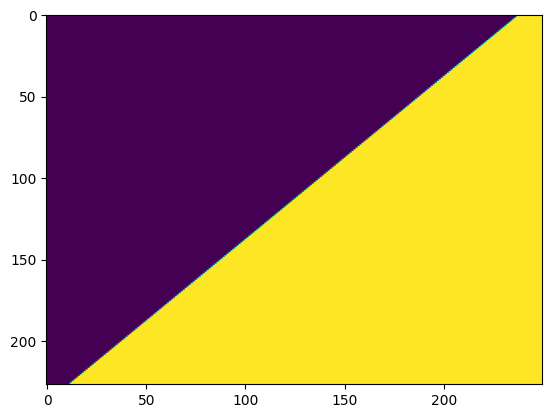

  0%|          | 0/10 [00:00<?, ?it/s]

 44%|████▍     | 73/166 [3:57:07<5:05:00, 196.78s/it]

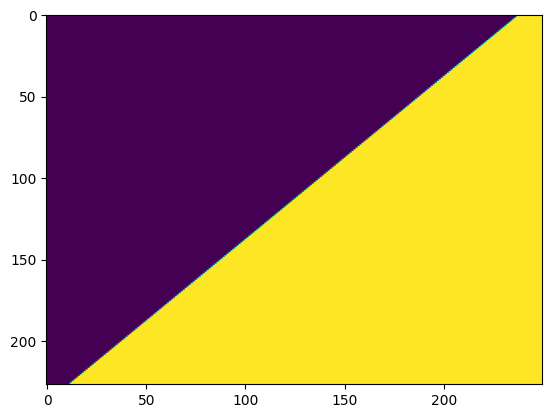

  0%|          | 0/10 [00:00<?, ?it/s]

 45%|████▍     | 74/166 [4:00:25<5:02:08, 197.05s/it]

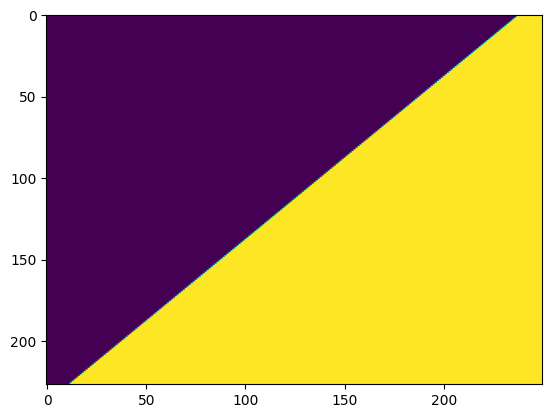

  0%|          | 0/10 [00:00<?, ?it/s]

 45%|████▌     | 75/166 [4:03:42<4:58:57, 197.12s/it]

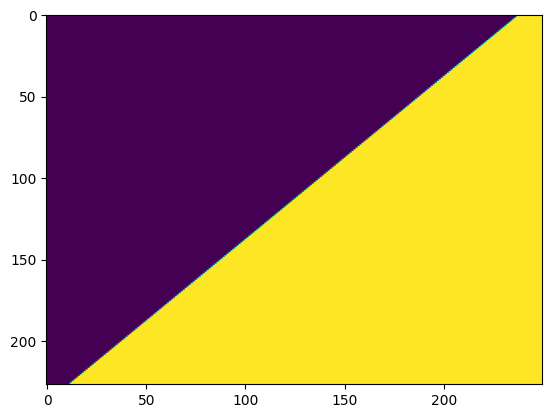

  0%|          | 0/10 [00:00<?, ?it/s]

 46%|████▌     | 76/166 [4:06:59<4:55:40, 197.11s/it]

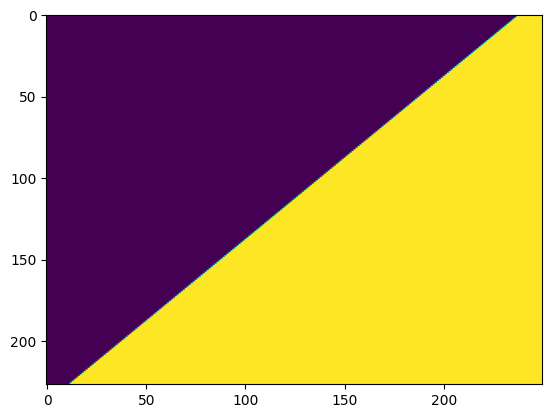

  0%|          | 0/10 [00:00<?, ?it/s]

 46%|████▋     | 77/166 [4:10:17<4:52:29, 197.18s/it]

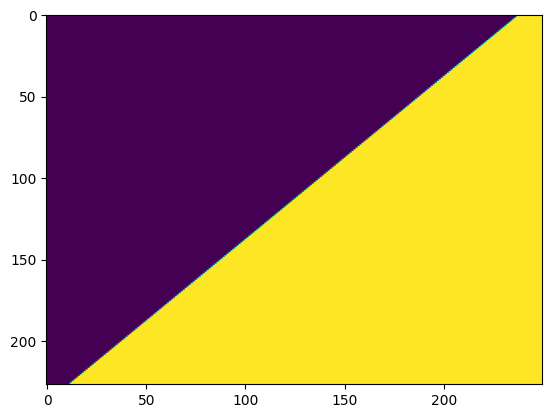

  0%|          | 0/10 [00:00<?, ?it/s]

 47%|████▋     | 78/166 [4:13:33<4:48:42, 196.85s/it]

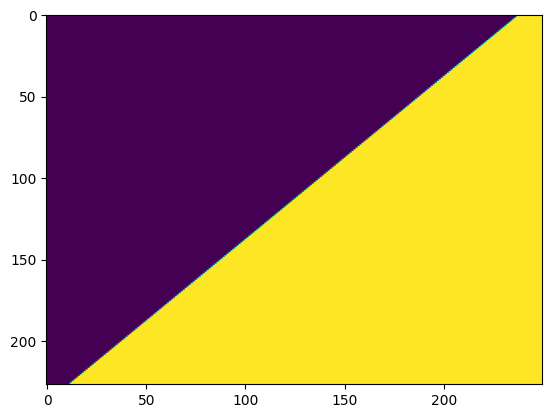

  0%|          | 0/10 [00:00<?, ?it/s]

 48%|████▊     | 79/166 [4:16:50<4:45:45, 197.07s/it]

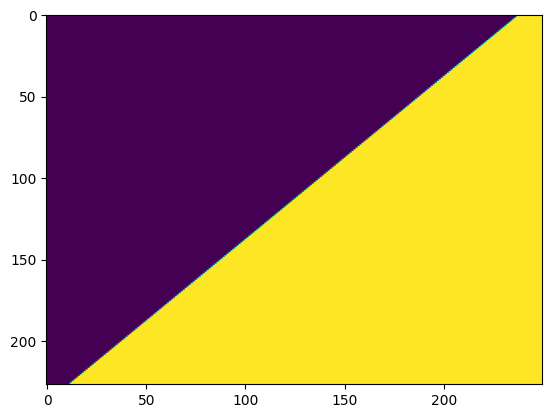

  0%|          | 0/10 [00:00<?, ?it/s]

 48%|████▊     | 80/166 [4:20:06<4:41:43, 196.55s/it]

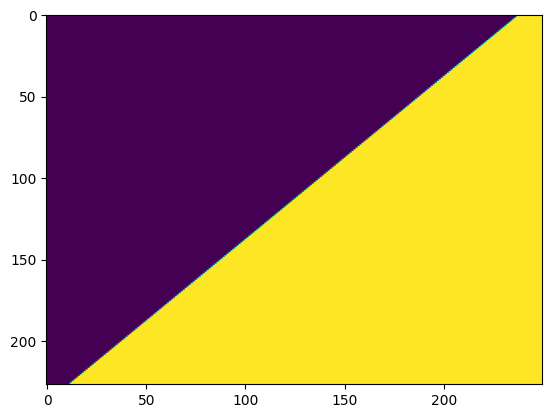

  0%|          | 0/10 [00:00<?, ?it/s]

 49%|████▉     | 81/166 [4:23:22<4:38:31, 196.60s/it]

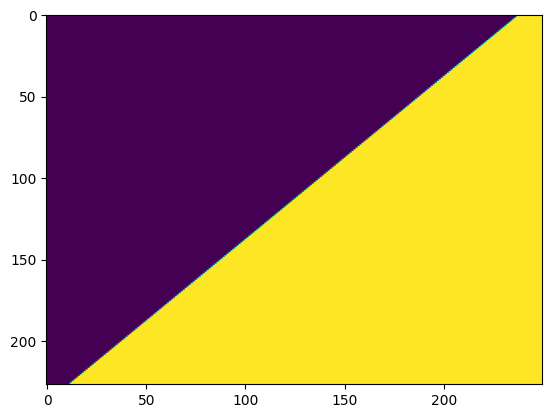

  0%|          | 0/10 [00:00<?, ?it/s]

 49%|████▉     | 82/166 [4:26:40<4:35:39, 196.89s/it]

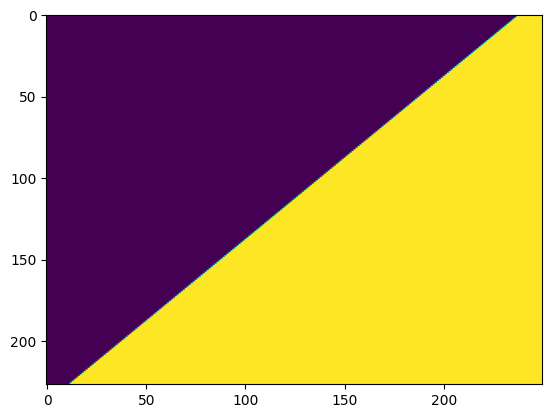

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 83/166 [4:29:57<4:32:16, 196.82s/it]

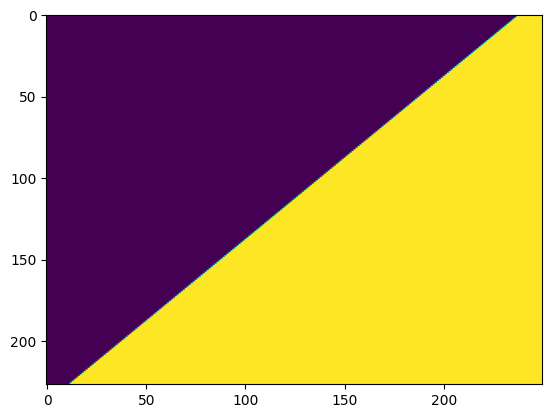

  0%|          | 0/10 [00:00<?, ?it/s]

 51%|█████     | 84/166 [4:33:13<4:28:58, 196.81s/it]

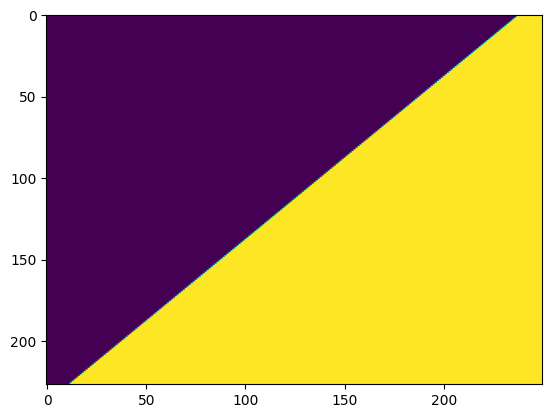

  0%|          | 0/10 [00:00<?, ?it/s]

 51%|█████     | 85/166 [4:36:31<4:26:00, 197.04s/it]

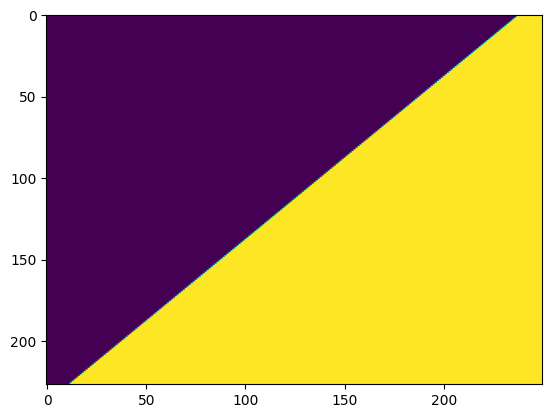

  0%|          | 0/10 [00:00<?, ?it/s]

 52%|█████▏    | 86/166 [4:39:48<4:22:31, 196.89s/it]

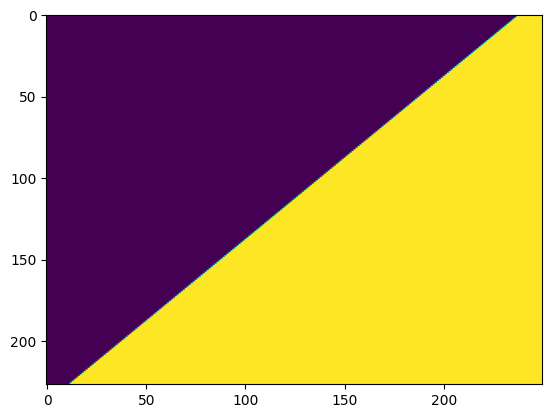

  0%|          | 0/10 [00:00<?, ?it/s]

 52%|█████▏    | 87/166 [4:43:05<4:19:15, 196.91s/it]

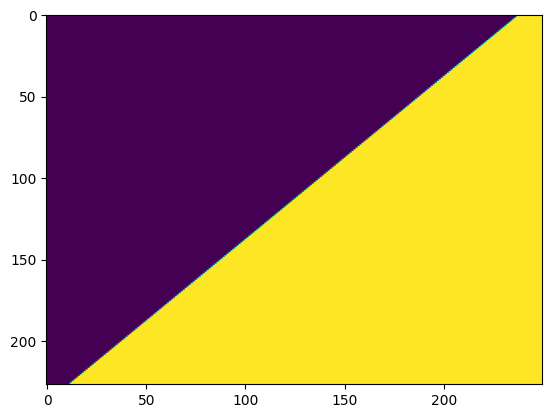

  0%|          | 0/10 [00:00<?, ?it/s]

 53%|█████▎    | 88/166 [4:46:24<4:16:53, 197.60s/it]

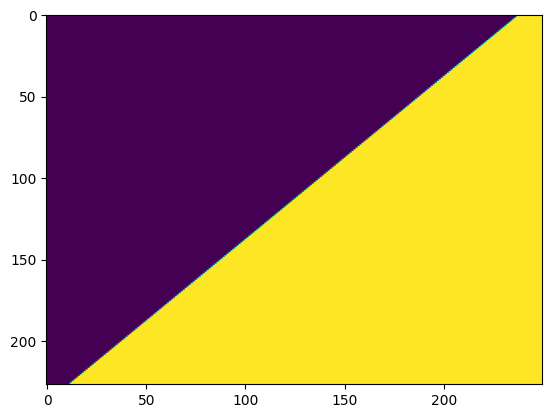

  0%|          | 0/10 [00:00<?, ?it/s]

 54%|█████▎    | 89/166 [4:49:42<4:13:45, 197.73s/it]

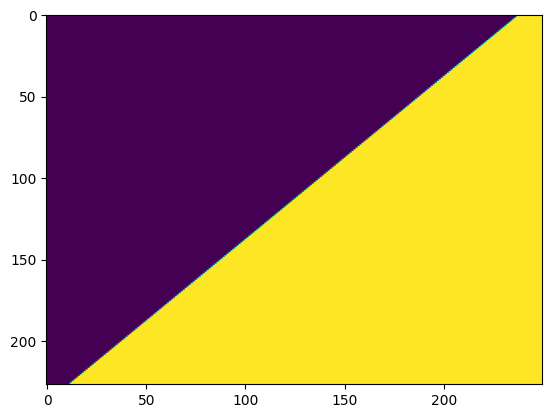

  0%|          | 0/10 [00:00<?, ?it/s]

 54%|█████▍    | 90/166 [4:53:00<4:10:39, 197.89s/it]

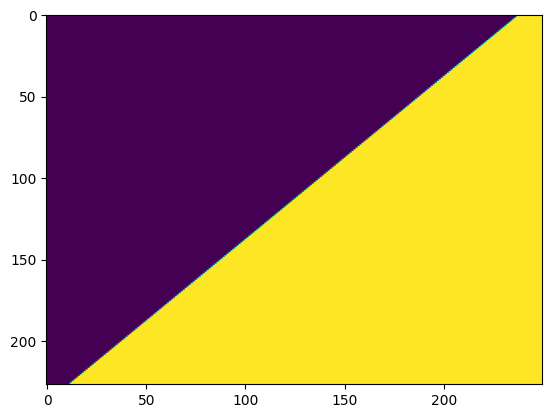

  0%|          | 0/10 [00:00<?, ?it/s]

 55%|█████▍    | 91/166 [4:56:19<4:07:42, 198.17s/it]

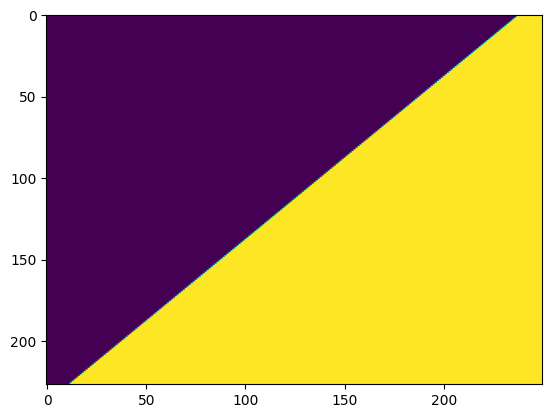

  0%|          | 0/10 [00:00<?, ?it/s]

 55%|█████▌    | 92/166 [4:59:36<4:03:57, 197.80s/it]

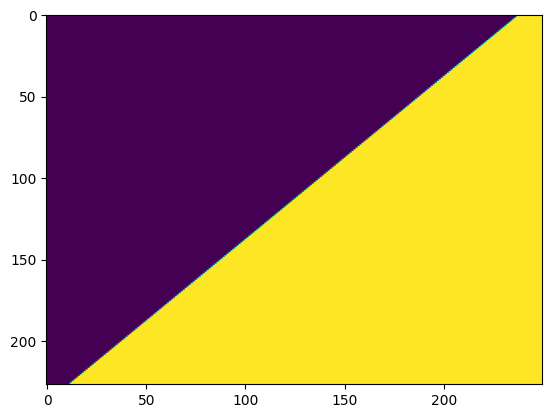

  0%|          | 0/10 [00:00<?, ?it/s]

 56%|█████▌    | 93/166 [5:02:54<4:00:51, 197.97s/it]

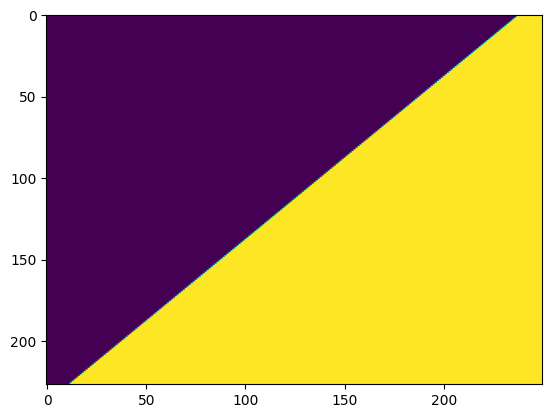

  0%|          | 0/10 [00:00<?, ?it/s]

 57%|█████▋    | 94/166 [5:06:12<3:57:20, 197.78s/it]

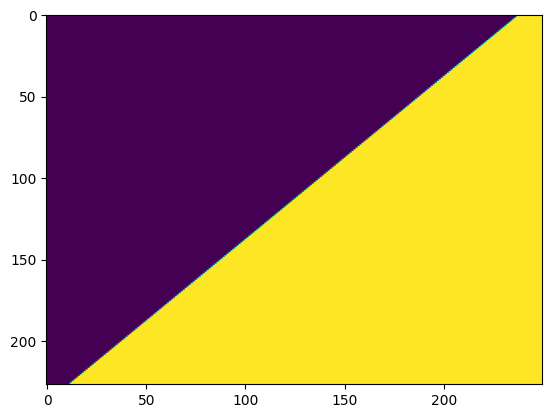

  0%|          | 0/10 [00:00<?, ?it/s]

 57%|█████▋    | 95/166 [5:09:29<3:53:48, 197.59s/it]

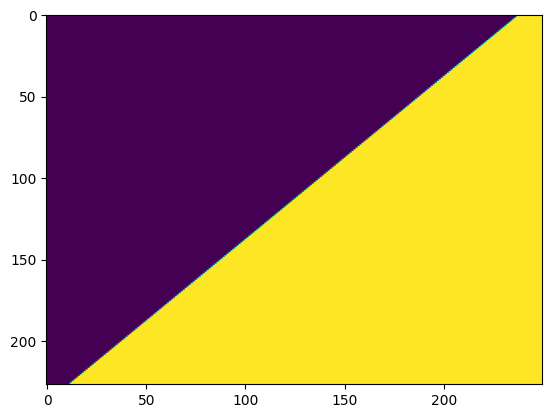

  0%|          | 0/10 [00:00<?, ?it/s]

 58%|█████▊    | 96/166 [5:12:45<3:50:12, 197.32s/it]

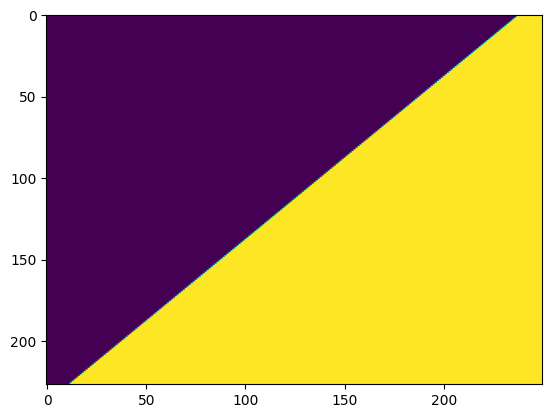

  0%|          | 0/10 [00:00<?, ?it/s]

 58%|█████▊    | 97/166 [5:16:02<3:46:50, 197.25s/it]

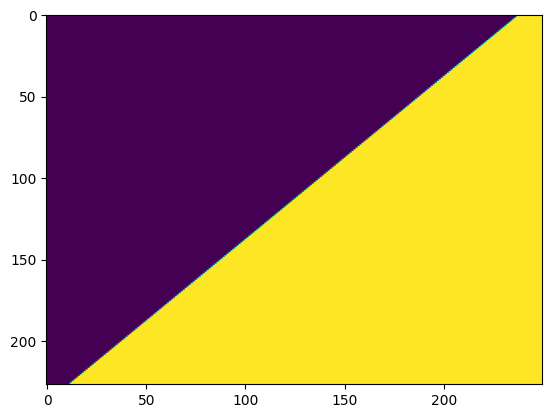

  0%|          | 0/10 [00:00<?, ?it/s]

 59%|█████▉    | 98/166 [5:19:20<3:43:40, 197.37s/it]

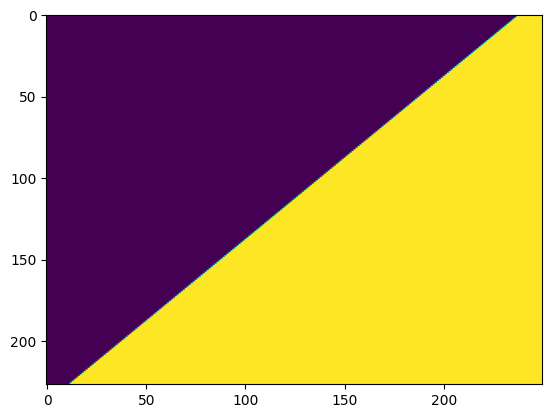

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|█████▉    | 99/166 [5:22:37<3:40:18, 197.29s/it]

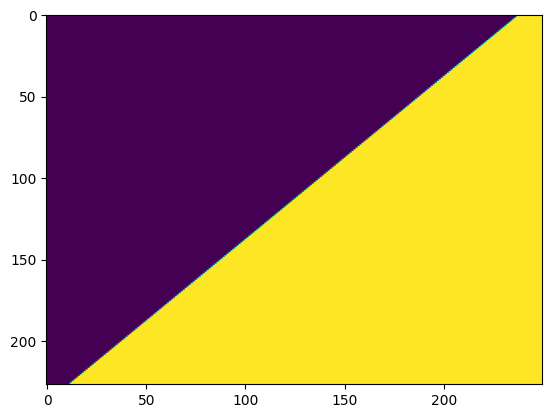

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 100/166 [5:25:55<3:37:19, 197.58s/it]

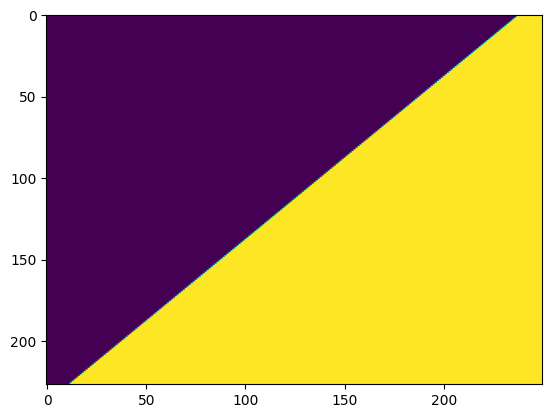

  0%|          | 0/10 [00:00<?, ?it/s]

 61%|██████    | 101/166 [5:29:14<3:34:28, 197.98s/it]

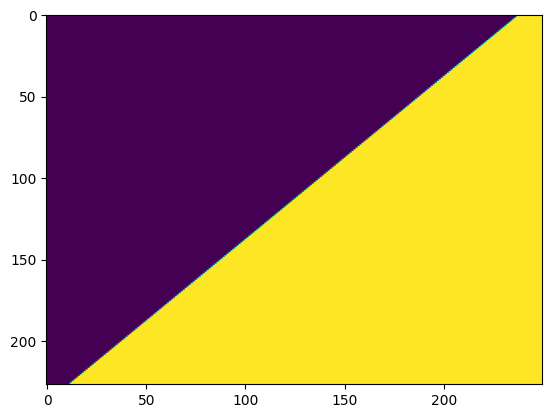

  0%|          | 0/10 [00:00<?, ?it/s]

 61%|██████▏   | 102/166 [5:32:31<3:30:50, 197.66s/it]

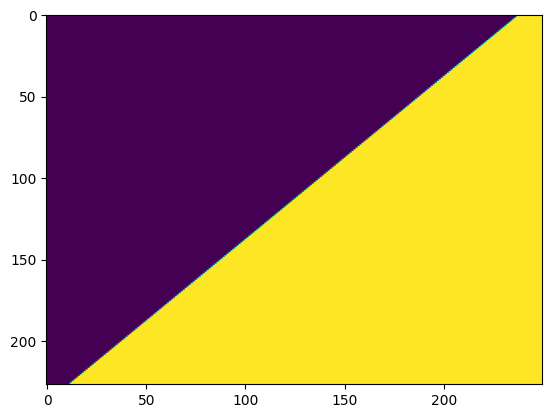

  0%|          | 0/10 [00:00<?, ?it/s]

 62%|██████▏   | 103/166 [5:35:48<3:27:09, 197.29s/it]

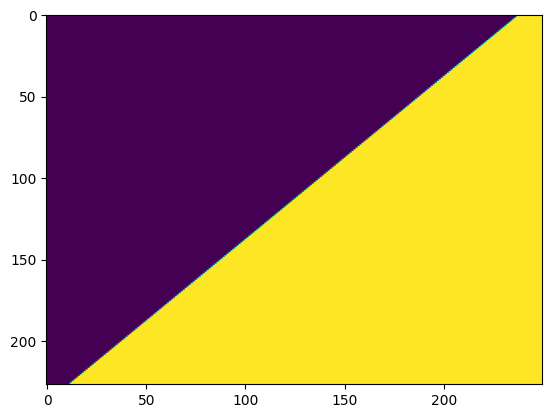

  0%|          | 0/10 [00:00<?, ?it/s]

 63%|██████▎   | 104/166 [5:39:04<3:23:34, 197.00s/it]

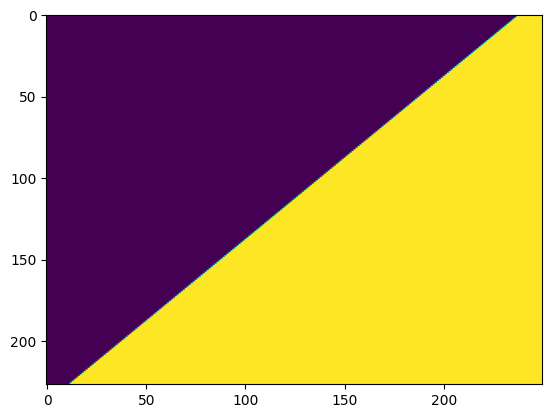

  0%|          | 0/10 [00:00<?, ?it/s]

 63%|██████▎   | 105/166 [5:42:22<3:20:39, 197.36s/it]

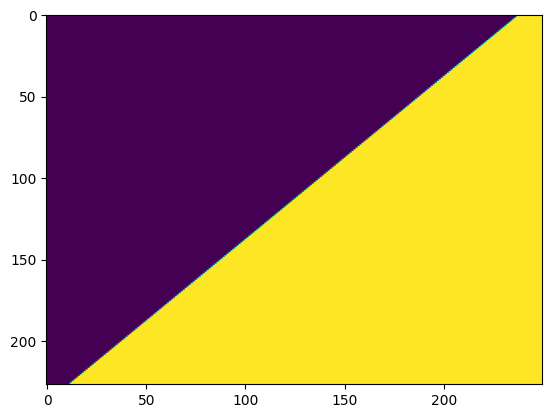

  0%|          | 0/10 [00:00<?, ?it/s]

 64%|██████▍   | 106/166 [5:45:37<3:16:41, 196.69s/it]

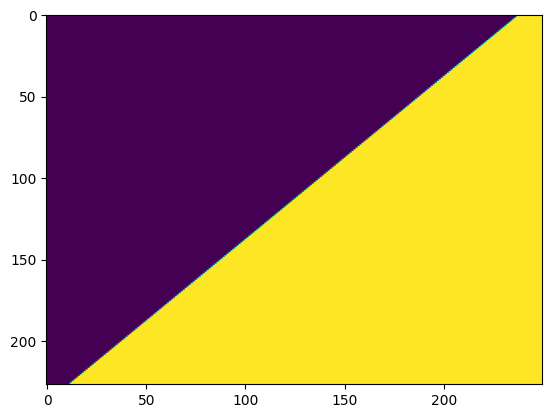

  0%|          | 0/10 [00:00<?, ?it/s]

 64%|██████▍   | 107/166 [5:48:54<3:13:21, 196.63s/it]

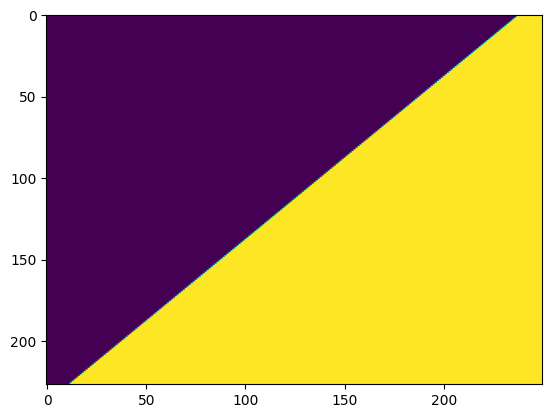

  0%|          | 0/10 [00:00<?, ?it/s]

 65%|██████▌   | 108/166 [5:52:11<3:10:06, 196.67s/it]

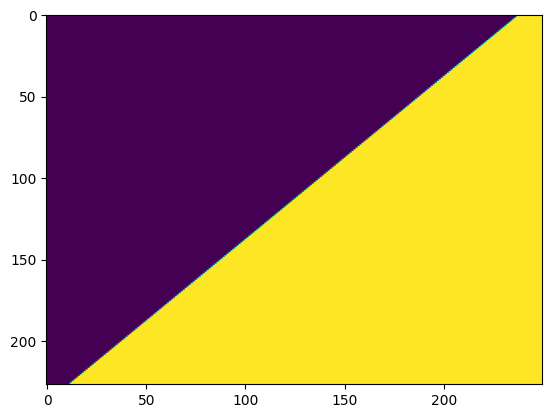

  0%|          | 0/10 [00:00<?, ?it/s]

 66%|██████▌   | 109/166 [5:55:28<3:06:54, 196.74s/it]

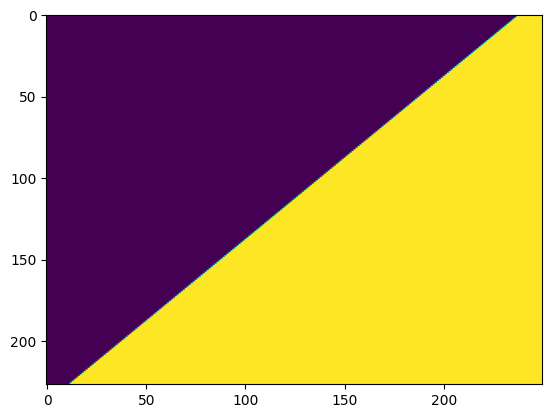

  0%|          | 0/10 [00:00<?, ?it/s]

 66%|██████▋   | 110/166 [5:58:45<3:03:50, 196.97s/it]

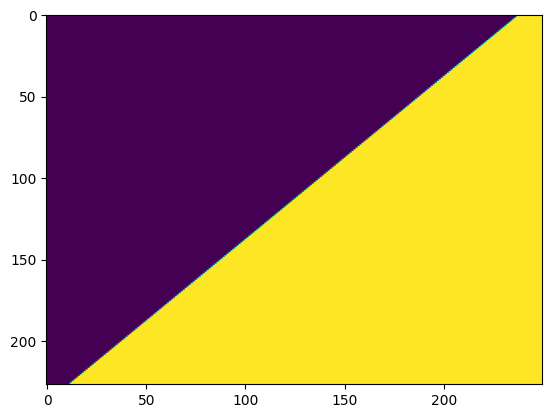

  0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 111/166 [6:02:02<3:00:36, 197.03s/it]

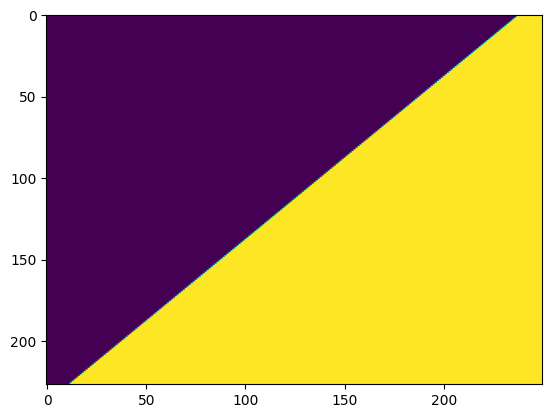

  0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 112/166 [6:05:20<2:57:24, 197.12s/it]

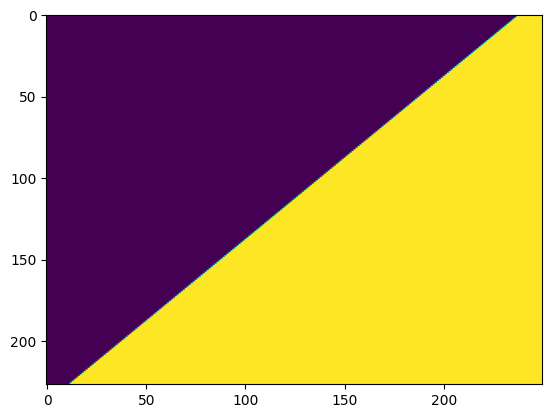

  0%|          | 0/10 [00:00<?, ?it/s]

 68%|██████▊   | 113/166 [6:08:39<2:54:45, 197.84s/it]

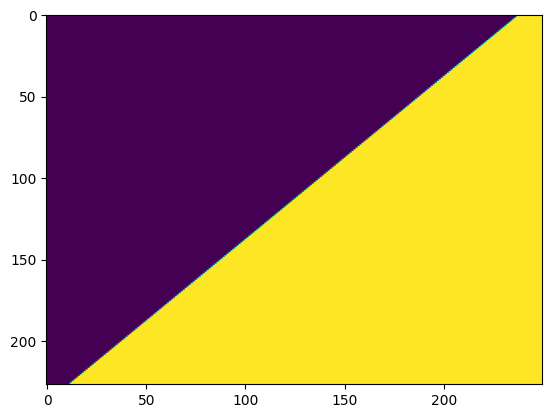

  0%|          | 0/10 [00:00<?, ?it/s]

 69%|██████▊   | 114/166 [6:11:55<2:51:04, 197.40s/it]

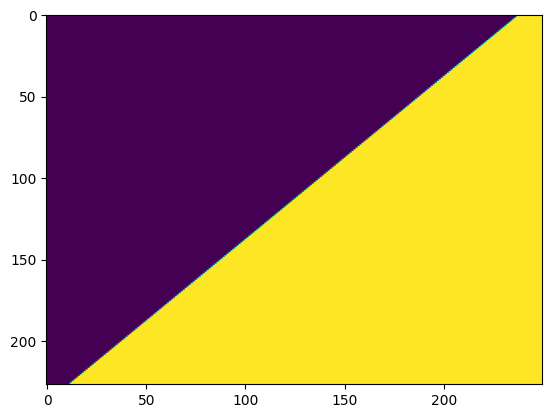

  0%|          | 0/10 [00:00<?, ?it/s]

 69%|██████▉   | 115/166 [6:15:14<2:48:07, 197.80s/it]

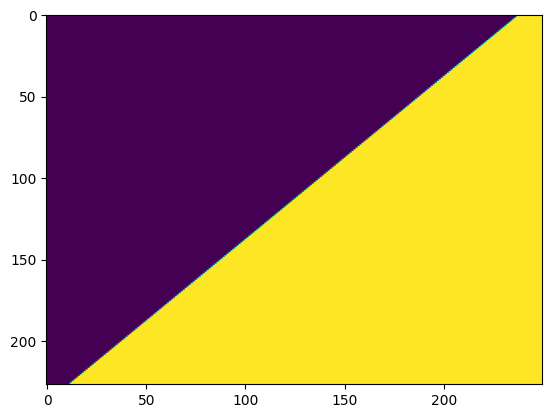

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|██████▉   | 116/166 [6:18:31<2:44:35, 197.51s/it]

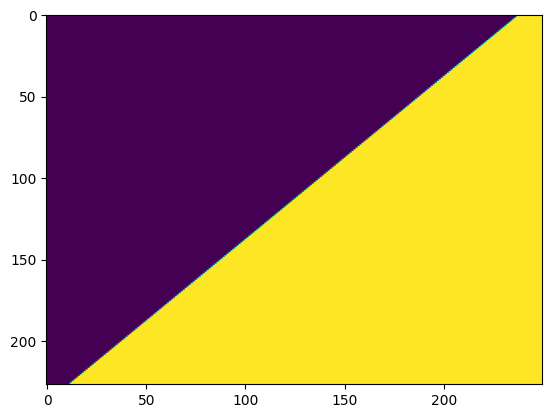

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 117/166 [6:21:48<2:41:17, 197.50s/it]

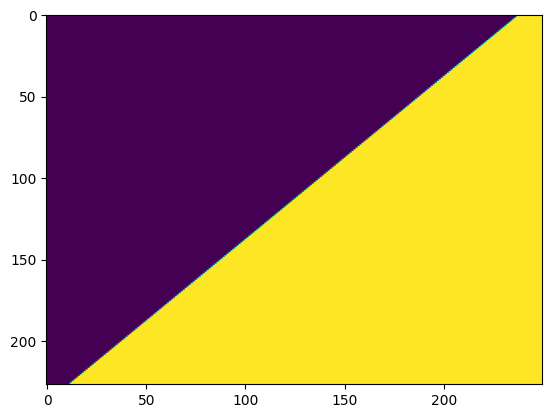

  0%|          | 0/10 [00:00<?, ?it/s]

 71%|███████   | 118/166 [6:25:06<2:38:03, 197.58s/it]

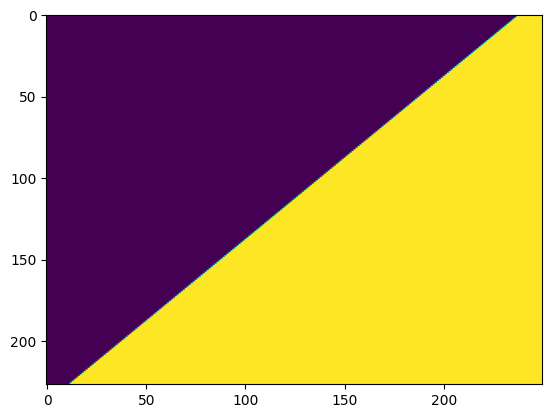

  0%|          | 0/10 [00:00<?, ?it/s]

 72%|███████▏  | 119/166 [6:28:24<2:34:54, 197.76s/it]

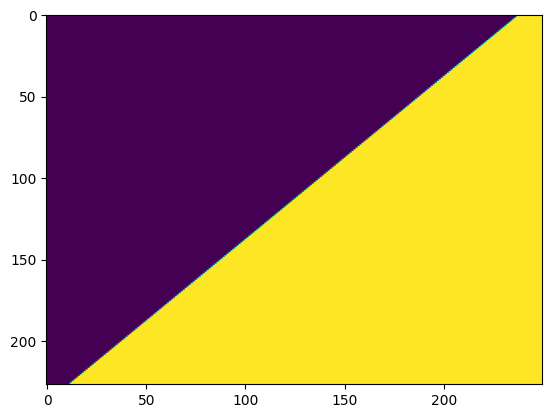

  0%|          | 0/10 [00:00<?, ?it/s]

 72%|███████▏  | 120/166 [6:31:40<2:31:11, 197.22s/it]

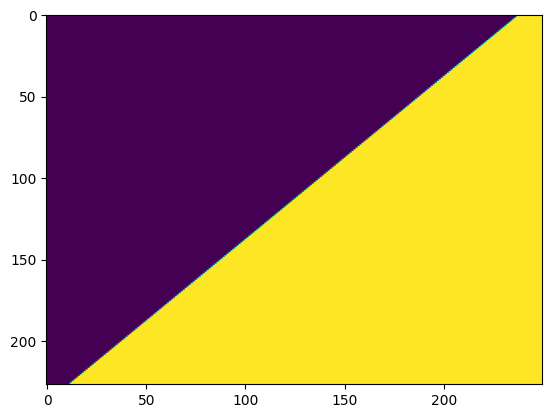

  0%|          | 0/10 [00:00<?, ?it/s]

 73%|███████▎  | 121/166 [6:34:58<2:28:04, 197.44s/it]

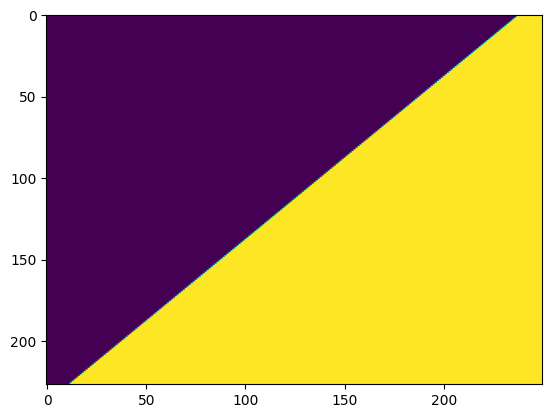

  0%|          | 0/10 [00:00<?, ?it/s]

 73%|███████▎  | 122/166 [6:38:13<2:24:11, 196.62s/it]

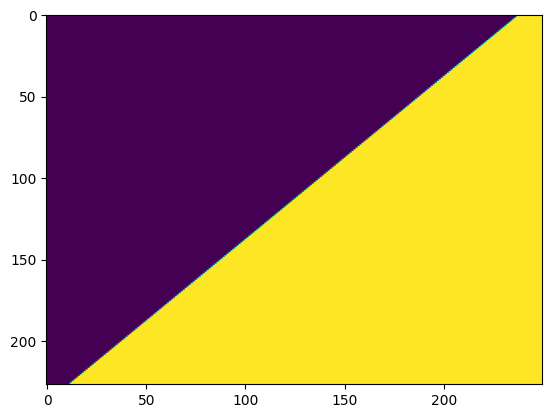

  0%|          | 0/10 [00:00<?, ?it/s]

 74%|███████▍  | 123/166 [6:41:27<2:20:24, 195.92s/it]

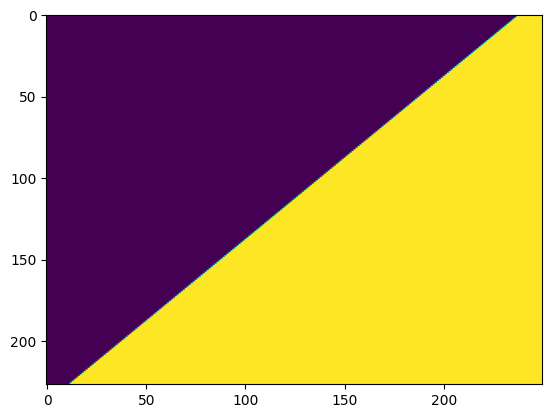

  0%|          | 0/10 [00:00<?, ?it/s]

 75%|███████▍  | 124/166 [6:44:42<2:16:58, 195.68s/it]

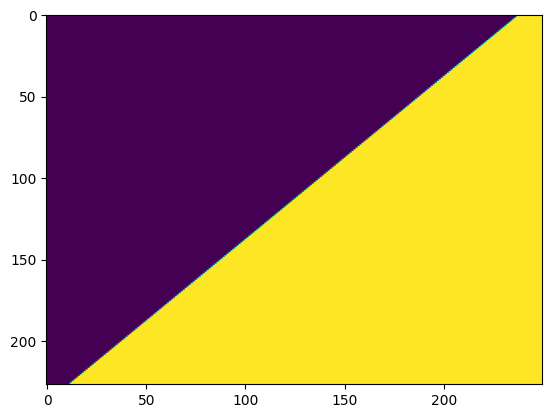

  0%|          | 0/10 [00:00<?, ?it/s]

 75%|███████▌  | 125/166 [6:47:59<2:13:55, 195.99s/it]

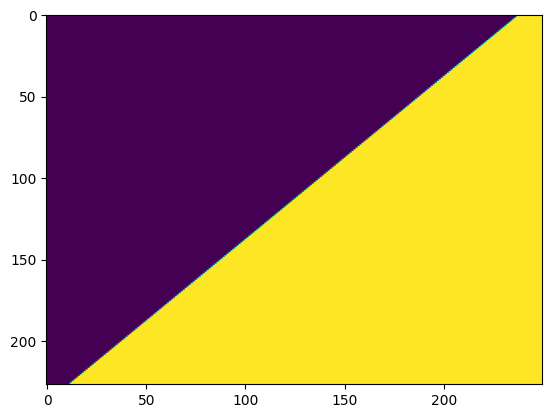

  0%|          | 0/10 [00:00<?, ?it/s]

 76%|███████▌  | 126/166 [6:51:15<2:10:34, 195.86s/it]

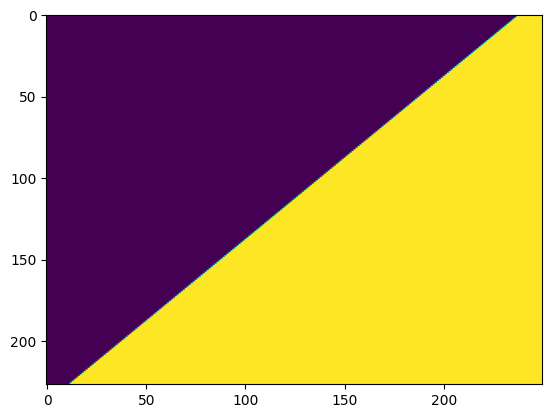

  0%|          | 0/10 [00:00<?, ?it/s]

 77%|███████▋  | 127/166 [6:54:30<2:07:12, 195.71s/it]

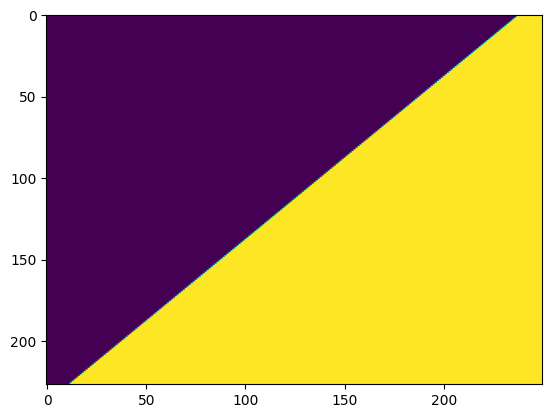

  0%|          | 0/10 [00:00<?, ?it/s]

 77%|███████▋  | 128/166 [6:57:46<2:04:01, 195.83s/it]

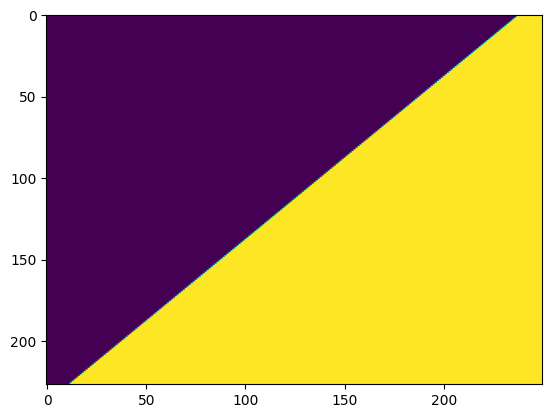

  0%|          | 0/10 [00:00<?, ?it/s]

 78%|███████▊  | 129/166 [7:01:02<2:00:43, 195.76s/it]

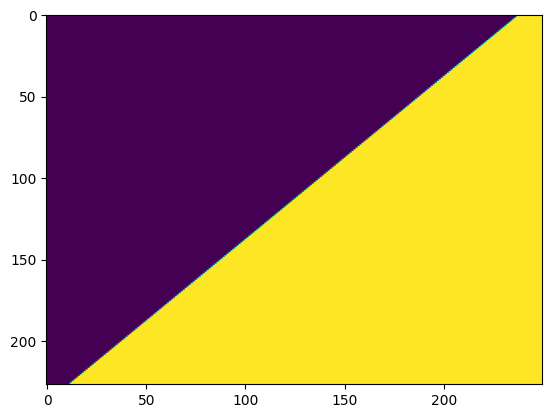

  0%|          | 0/10 [00:00<?, ?it/s]

 78%|███████▊  | 130/166 [7:04:18<1:57:37, 196.04s/it]

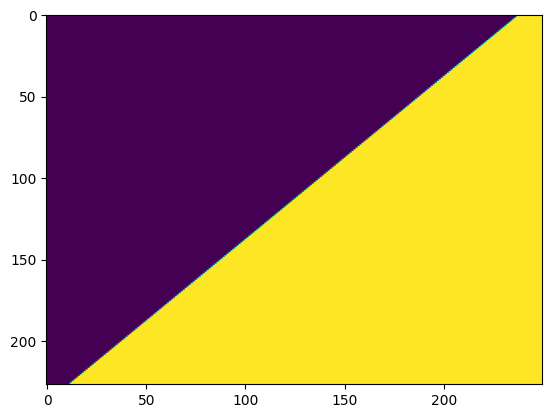

  0%|          | 0/10 [00:00<?, ?it/s]

 79%|███████▉  | 131/166 [7:07:35<1:54:22, 196.08s/it]

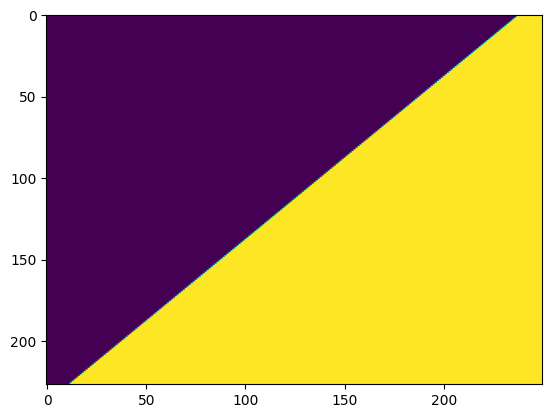

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|███████▉  | 132/166 [7:10:52<1:51:15, 196.34s/it]

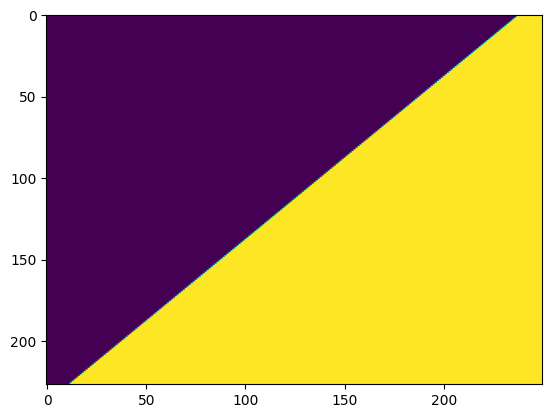

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 133/166 [7:14:08<1:47:58, 196.31s/it]

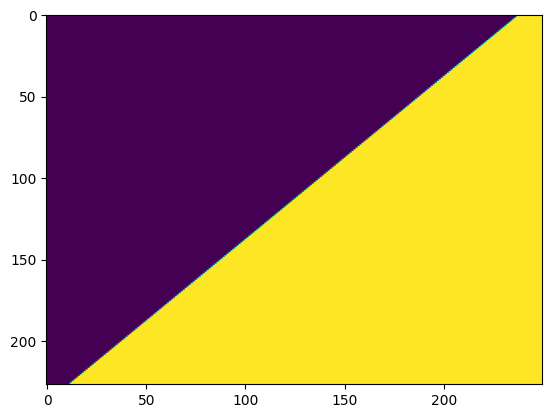

  0%|          | 0/10 [00:00<?, ?it/s]

 81%|████████  | 134/166 [7:17:24<1:44:41, 196.29s/it]

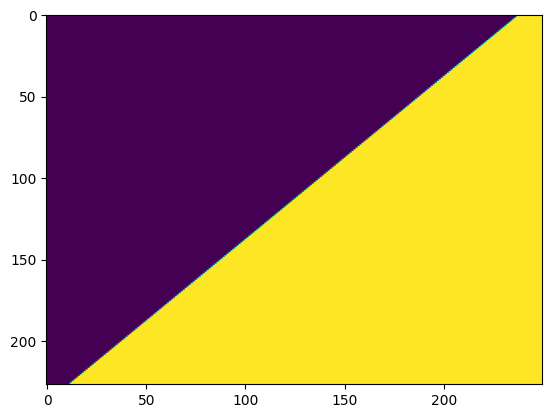

  0%|          | 0/10 [00:00<?, ?it/s]

 81%|████████▏ | 135/166 [7:20:42<1:41:38, 196.72s/it]

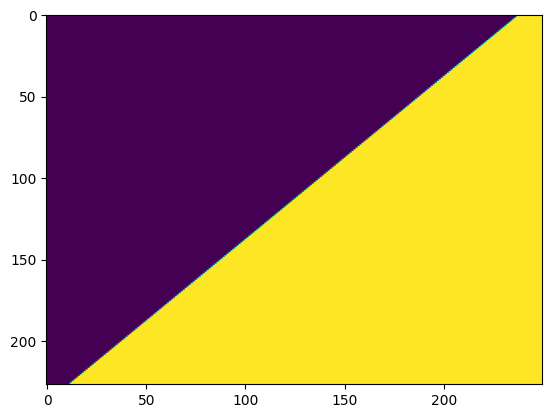

  0%|          | 0/10 [00:00<?, ?it/s]

 82%|████████▏ | 136/166 [7:23:58<1:38:15, 196.50s/it]

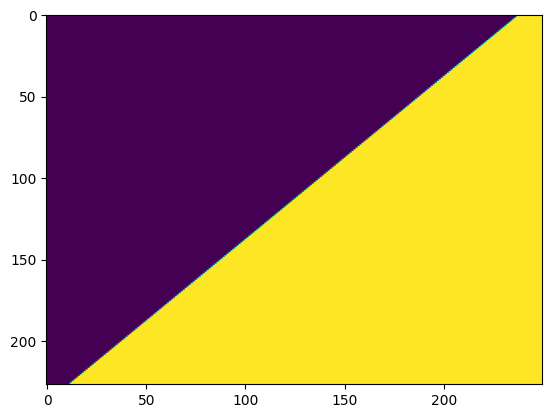

  0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 137/166 [7:27:14<1:34:57, 196.47s/it]

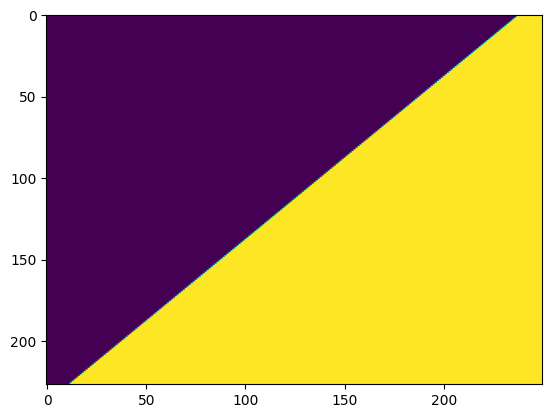

  0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 138/166 [7:30:32<1:31:50, 196.79s/it]

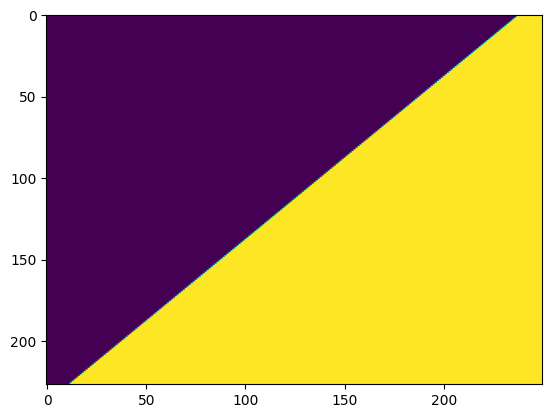

  0%|          | 0/10 [00:00<?, ?it/s]

 84%|████████▎ | 139/166 [7:33:49<1:28:38, 196.98s/it]

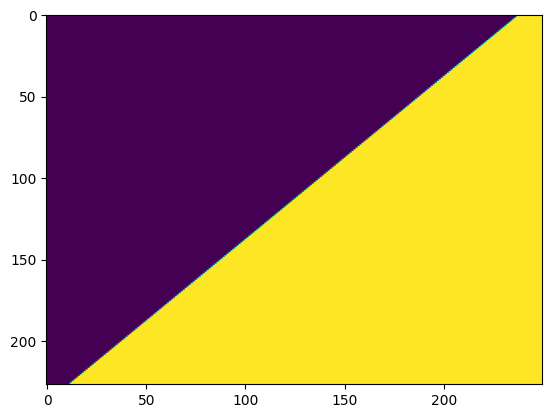

  0%|          | 0/10 [00:00<?, ?it/s]

 84%|████████▍ | 140/166 [7:37:07<1:25:25, 197.13s/it]

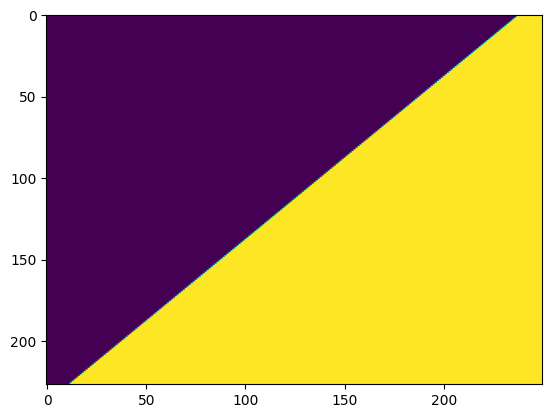

  0%|          | 0/10 [00:00<?, ?it/s]

 85%|████████▍ | 141/166 [7:40:24<1:22:10, 197.23s/it]

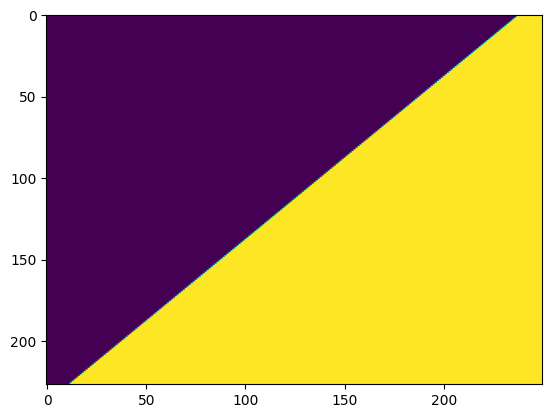

  0%|          | 0/10 [00:00<?, ?it/s]

 86%|████████▌ | 142/166 [7:43:41<1:18:53, 197.22s/it]

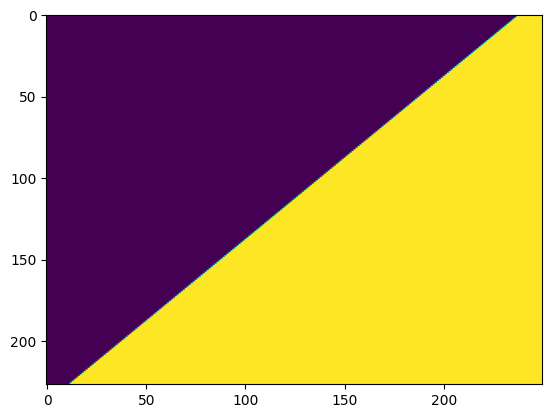

  0%|          | 0/10 [00:00<?, ?it/s]

 86%|████████▌ | 143/166 [7:46:57<1:15:26, 196.79s/it]

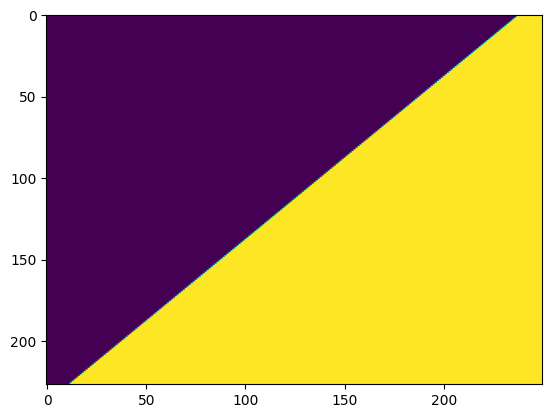

  0%|          | 0/10 [00:00<?, ?it/s]

 87%|████████▋ | 144/166 [7:50:14<1:12:06, 196.68s/it]

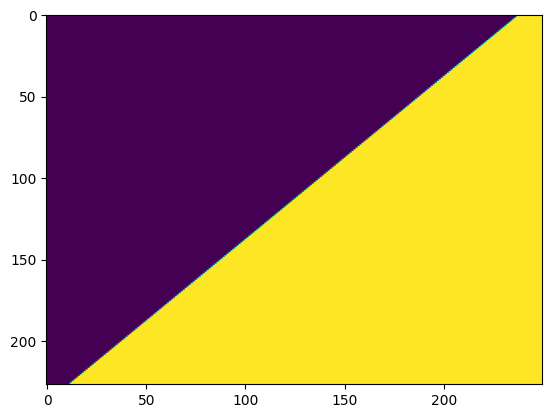

  0%|          | 0/10 [00:00<?, ?it/s]

 87%|████████▋ | 145/166 [7:53:29<1:08:41, 196.26s/it]

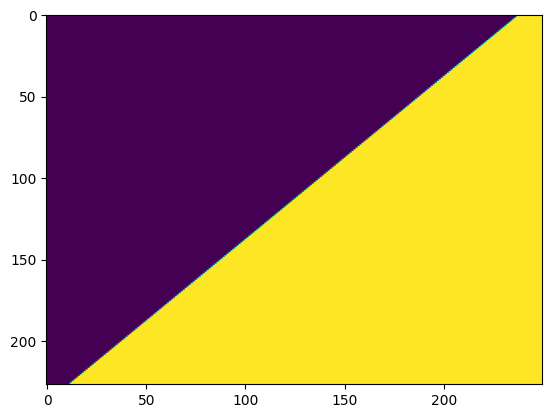

  0%|          | 0/10 [00:00<?, ?it/s]

 88%|████████▊ | 146/166 [7:56:45<1:05:27, 196.35s/it]

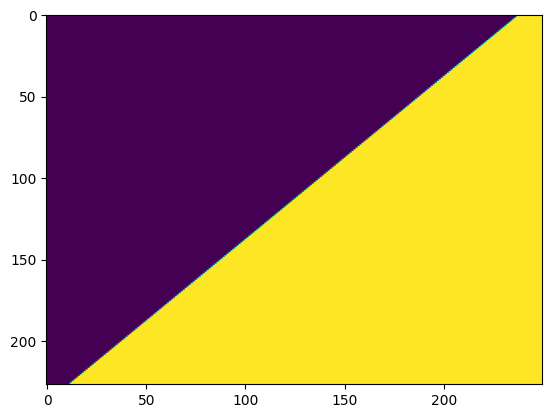

  0%|          | 0/10 [00:00<?, ?it/s]

 89%|████████▊ | 147/166 [8:00:02<1:02:10, 196.34s/it]

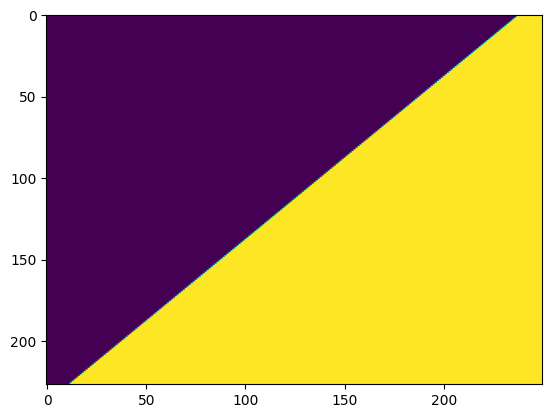

  0%|          | 0/10 [00:00<?, ?it/s]

 89%|████████▉ | 148/166 [8:03:18<58:51, 196.21s/it]  

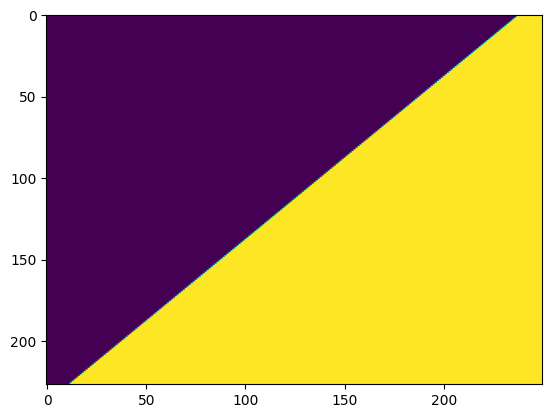

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|████████▉ | 149/166 [8:06:34<55:37, 196.34s/it]

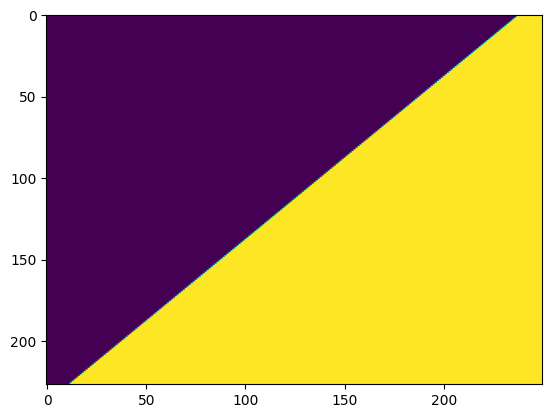

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 150/166 [8:09:49<52:15, 195.96s/it]

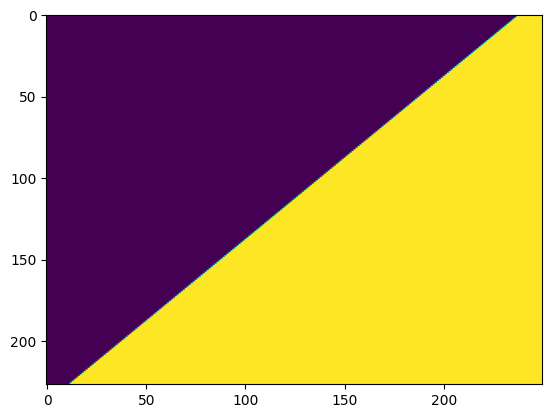

  0%|          | 0/10 [00:00<?, ?it/s]

 91%|█████████ | 151/166 [8:13:05<48:57, 195.86s/it]

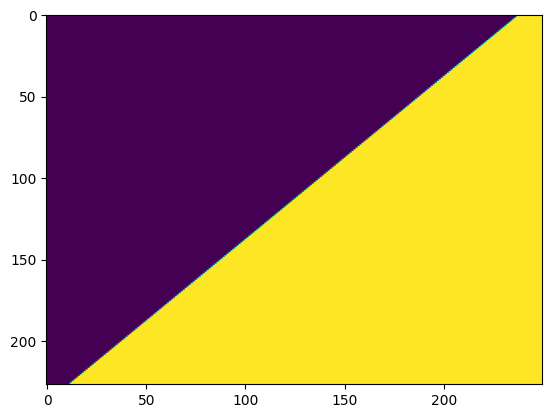

  0%|          | 0/10 [00:00<?, ?it/s]

 92%|█████████▏| 152/166 [8:16:22<45:47, 196.22s/it]

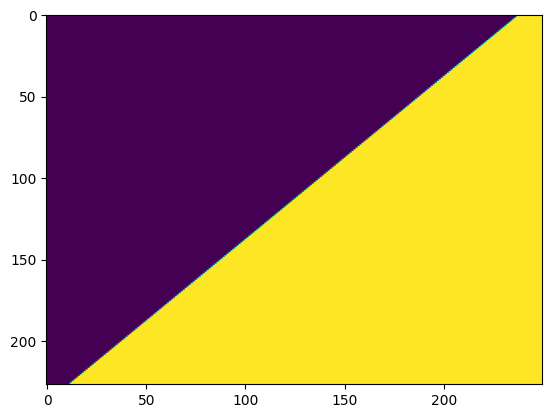

  0%|          | 0/10 [00:00<?, ?it/s]

 92%|█████████▏| 153/166 [8:19:39<42:32, 196.38s/it]

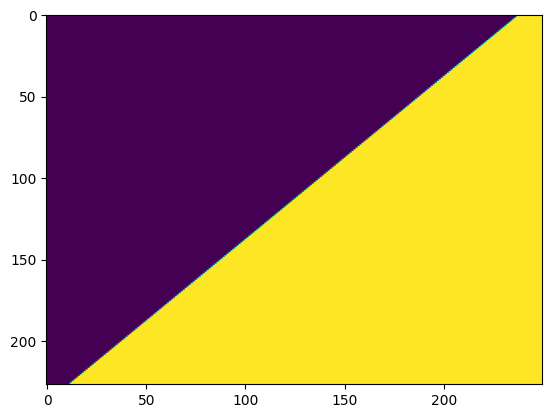

  0%|          | 0/10 [00:00<?, ?it/s]

 93%|█████████▎| 154/166 [8:22:56<39:21, 196.77s/it]

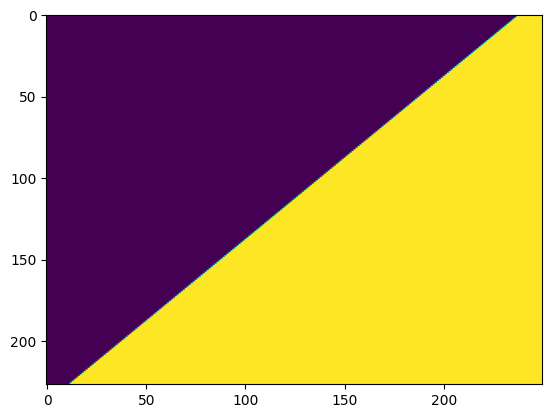

  0%|          | 0/10 [00:00<?, ?it/s]

 93%|█████████▎| 155/166 [8:26:15<36:08, 197.18s/it]

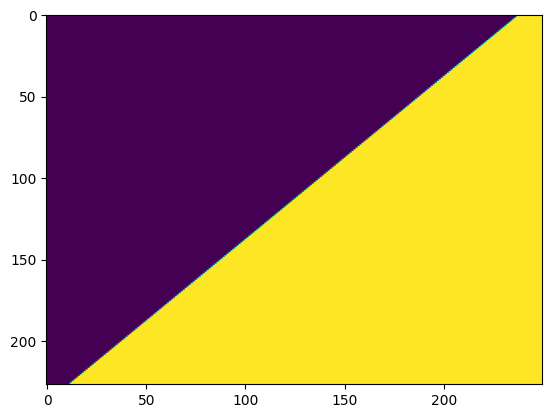

  0%|          | 0/10 [00:00<?, ?it/s]

 94%|█████████▍| 156/166 [8:29:34<32:58, 197.81s/it]

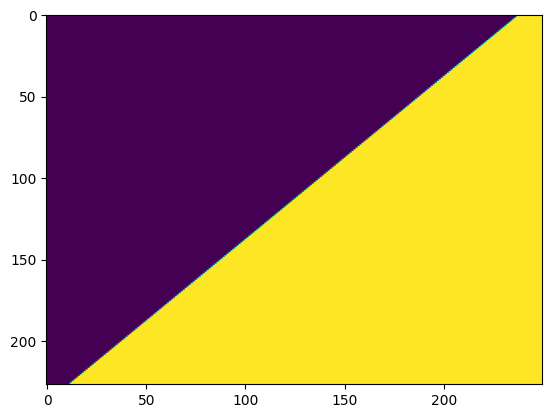

  0%|          | 0/10 [00:00<?, ?it/s]

 95%|█████████▍| 157/166 [8:32:51<29:39, 197.72s/it]

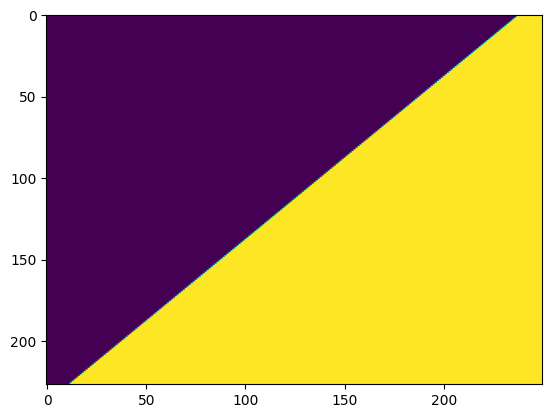

  0%|          | 0/10 [00:00<?, ?it/s]

 95%|█████████▌| 158/166 [8:36:10<26:24, 198.06s/it]

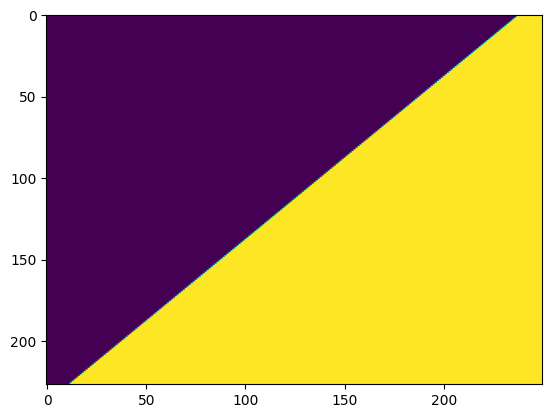

  0%|          | 0/10 [00:00<?, ?it/s]

 96%|█████████▌| 159/166 [8:39:29<23:07, 198.17s/it]

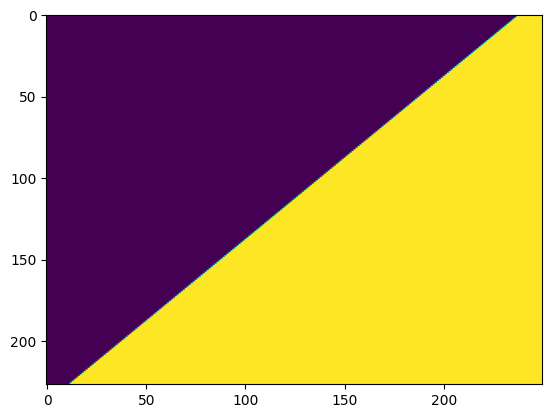

  0%|          | 0/10 [00:00<?, ?it/s]

 96%|█████████▋| 160/166 [8:42:48<19:51, 198.50s/it]

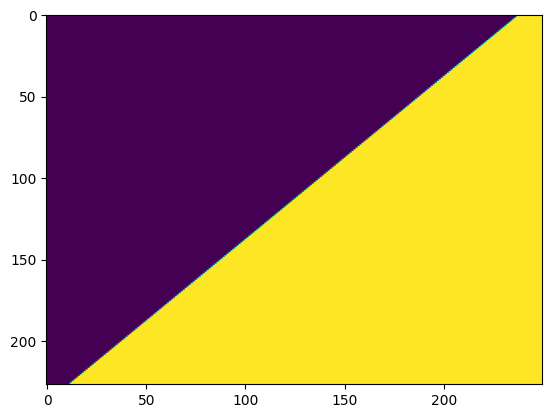

  0%|          | 0/10 [00:00<?, ?it/s]

 97%|█████████▋| 161/166 [8:46:06<16:32, 198.48s/it]

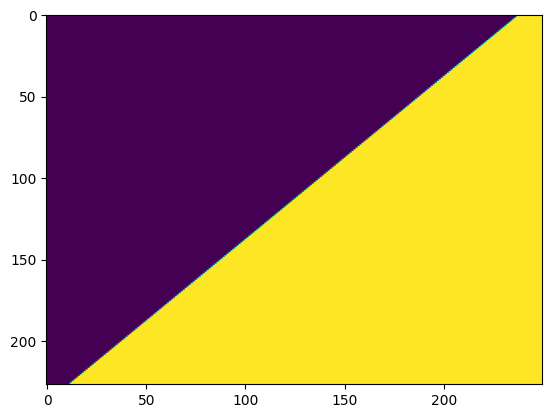

  0%|          | 0/10 [00:00<?, ?it/s]

 98%|█████████▊| 162/166 [8:49:25<13:14, 198.52s/it]

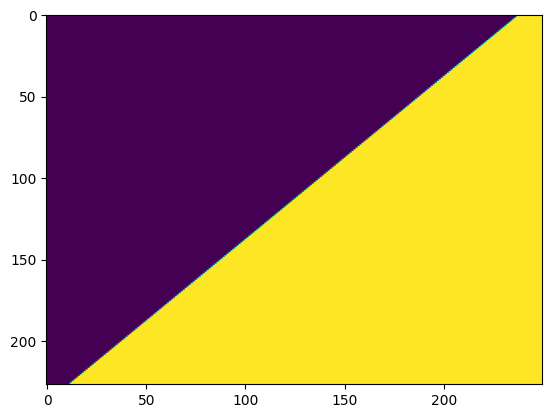

  0%|          | 0/10 [00:00<?, ?it/s]

 98%|█████████▊| 163/166 [8:52:45<09:56, 198.94s/it]

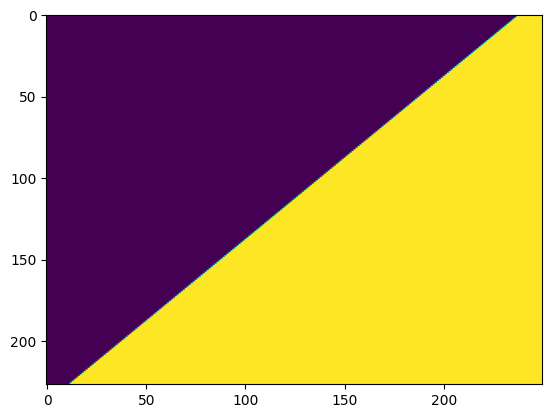

  0%|          | 0/10 [00:00<?, ?it/s]

 99%|█████████▉| 164/166 [8:56:04<06:38, 199.01s/it]

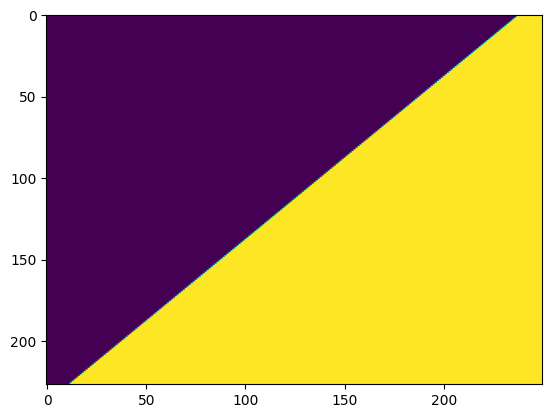

  0%|          | 0/10 [00:00<?, ?it/s]

 99%|█████████▉| 165/166 [8:59:25<03:19, 199.62s/it]

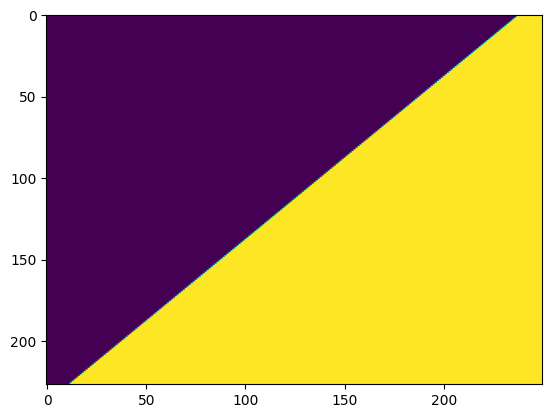

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 166/166 [9:02:45<00:00, 196.18s/it]


AttributeError: Line2D.set() got an unexpected keyword argument 'width'

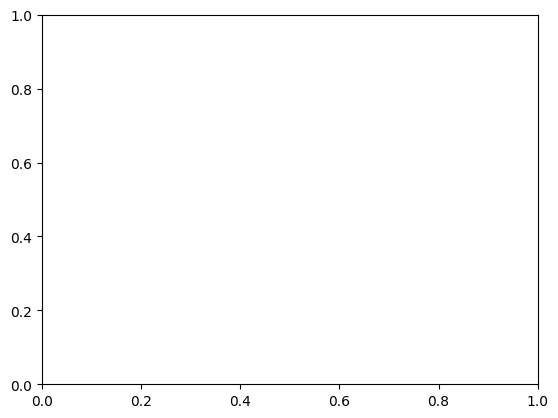

In [1]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 500
σ = 0.2 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0]

# seed = 29
# nprandom.seed(2*seed)

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

# chgpt_location_idx = [0.4, 0.5, 0.6]

δ = 0.5
n = int(δ * p)
chgpt_location_idx = np.linspace(0.1, 0.9, int(n/1.5))
B̃_cov = np.eye(L)

coverage_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_coverage_list = [[] for i in range(len(chgpt_location_idx))]

empirical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]
theoretical_credible_set_list = [[] for i in range(len(chgpt_location_idx))]

for i in tqdm(range(len(chgpt_location_idx))):

    # true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/20)
    C_s = amp.signal_configuration.generate_C_distanced(n, L, Δ = Δ(n))[1:-1] # Excludes the all zeros case
    # Choose C_true to be the middle point
    C_true = C_s[int(len(C_s)/2)]
    plt.imshow(C_s, aspect='auto')
    plt.show()

    true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])]
    ϕ = amp.signal_configuration.C_to_marginal(C_s) 

    # C_true = np.zeros((n, )).astype(int)
    # loc = 0
    # for m in range(len(true_chgpt_locations(n)) + 1):
    #     if len(true_chgpt_locations(n)) == 0:
    #         break
    #     if m >= len(true_chgpt_locations(n)):
    #         C_true[loc:] = m
    #         break
    #     C_true[loc:true_chgpt_locations(n)[m]] = m
    #     loc = true_chgpt_locations(n)[m]

    signal_prior = GaussianSignal(B̃_cov)

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    # --- Set up theoretical coverage ---
    # Compute the fixed-C SE for given chgpt location
    ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

    # Sample Z, V_\Theta
    num_outer_samples = 100
    # Sample Z
    # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_outer_samples)))).reshape(num_outer_samples, n, L)
    # # Sample V̄_Θ
    # V_Θ = (Z @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
    #     jnp.zeros(L), κ_T_fixed, size=n))).reshape(num_outer_samples, n, L)
    # ε = np.array(nprandom.normal(0, σ, size=(num_outer_samples, n)))

    norm_sq_corr_1_list = []
    norm_sq_corr_2_list = []
    norm_sq_corr_1_SE_list = []
    norm_sq_corr_2_SE_list = []
    for k in tqdm(range(num_outer_samples)):
        # --- Set up empirical coverage ---
        # Gaussian Prior
        B̃ = signal_prior.sample(p)
        B̂_0 = signal_prior.sample(p)

        # Generate the observation vector Y
        X = np.random.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        Y = q(Θ, C_true, σ) 

        # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
        # ν = ν_arr[-1]
        # κ_T = κ_T_arr[-1]
        # ν_fixed = ν_fixed_arr[-1]
        # κ_T_fixed = κ_T_fixed_arr[-1]

        B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν


        norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        norm_sq_corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
        norm_sq_corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))
        # print("norm_sq_corr_1_list: ", norm_sq_corr_1_list)
        # print("norm_sq_corr_2_list: ", norm_sq_corr_2_list)
        # print("norm_sq_corr_1_SE_list: ", norm_sq_corr_1_SE_list)
        # print("norm_sq_corr_2_SE_list: ", norm_sq_corr_2_SE_list)


        # # Sqcorr plots
        # plt.errorbar([δ], np.mean(norm_sq_corr_1_list), yerr = np.std(norm_sq_corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
        # plt.errorbar([δ], np.mean(norm_sq_corr_2_list), yerr = np.std(norm_sq_corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
        # plt.scatter([δ], norm_sq_corr_1_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[0])
        # plt.scatter([δ], norm_sq_corr_2_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[2])
        # plt.ylim((0, 1))
        # plt.xlabel("δ")
        # plt.ylabel("Norm Sq Corr")
        # plt.legend()
        # plt.show()

        # B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
 
        # --- Compute Credible Set from AMP ---
        # Compute the credible set S(Θ_t, Y)
        # post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
        post_Θ_Y = amp.posterior.compute_posterior(C_s, Θ_t, Y, n, ρ, σ, ν, κ_T)
        α_CI = 0.05
        # plt.plot(post_Θ_Y, color='purple', alpha=0.1)
        # plt.show()
        try:
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) 
            # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set(L, α_CI, C_s, post_Θ_Y)
            S_lower_AMP, S_upper_AMP = amp.posterior.left_sided_credible_set_C(L, α_CI, C_s, post_Θ_Y)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        # S_lower_upper_list[i].append((S_lower, S_upper))
        # print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower_AMP:S_upper_AMP].sum())
        # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])
        empirical_credible_set_list[i].append((S_lower_AMP, S_upper_AMP))

        # --- Compute Credible Set from theoretical ---
        # Compute the credible set S(Θ_t, Y)
        Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
        # Sample V̄_Θ
        V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
        # post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
        post_V_q = amp.posterior.compute_posterior(C_s, V_Θ_i, q(Z_i, C_true, σ), n, ρ, σ, ν, κ_T)
        α_CI = 0.05
        # plt.plot(post_V_q, color='orange', alpha=0.1)
        try:
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_V_q) 
            # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set(L, α_CI, C_s, post_V_q)
            S_lower_theory, S_upper_theory = amp.posterior.left_sided_credible_set_C(L, α_CI, C_s, post_V_q)
            # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
        except Exception as e:
            print("Credible Set Error: ", e)
            # S_lower, S_upper = None, None
            continue
        theoretical_credible_set_list[i].append((S_lower_theory, S_upper_theory))

        ### --- Estimate Expected coverage, with ensemble variables --- ###
        ## Sample Z, V̄_Θ, ε̄. 
        # num_samples = 100
        # # Sample Z
        # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # # Sample V̄_Θ
        # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
        #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

        ## Sample Z, V̄_Θ, ε̄. 
        num_samples = 100
        # Sample Z
        Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
        # Sample V̄_Θ
        V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
        # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
        ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
        # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
        Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n

        comp_post_mapped = jax.vmap(amp.posterior.compute_posterior, in_axes=(None, 0, 0, None, None, None, None, None), out_axes=0)
        post_res = comp_post_mapped(C_s, V̄_θ, Ȳ, n, ρ, σ, ν, κ_T)
        coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
        theoretical_coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_theory:S_upper_theory], axis = 1)

        # for j in range(num_samples):
        #     Ȳ = q(Z[j].reshape((n, L)), C_true, σ)
        #     # post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
        #     post_V_Z_eval = amp.posterior.compute_posterior(C_s, V̄_θ[j], Ȳ, n, ρ, σ, ν, κ_T)
        #     # plt.plot(post_V_Z_eval, color='orange', alpha=0.1)
        #     # plt.show()
        #     # if S_lower is not None:
        #     #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
        #     coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_AMP:S_upper_AMP]))
        #     theoretical_coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_theory:S_upper_theory]))
            # else:
            #     coverage_list[i].append(None)
        # print("Empirical coverage: ", np.mean(coverage_list[i]))
        # print("Theoretical coverage: ", np.mean(theoretical_coverage_list[i]))
        # Add x-ticks where S_lower and S_upper are
        # plt.axvline(x=S_lower_AMP, color='black', linestyle='--')
        # plt.axvline(x=S_upper_AMP, color='black', linestyle='--')
        # plt.axvline(x=S_lower_theory, color='blue', linestyle='-.')
        # plt.axvline(x=S_upper_theory, color='blue', linestyle='-.')
        # plt.title("Posterior over η")
        # plt.show()

### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.errorbar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
# plt.title(str("p = ", str(p), " σ = ", str(σ), " num_outer_samples = ", str(num_outer_samples), "δ = ", str(δ), "\Delta = ", str(Δ(n)/n)))
plt.title(str("p = " + str(p) + " σ = " + str(σ) + " num_outer_samples = " + str(num_outer_samples) +  "δ = " +  str(δ) + "\Delta = " + str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 1))
plt.show()

print("Total mean empirical coverage: ", np.mean(coverage_list))
print("Total mean theoretical coverage: ", np.mean(theoretical_coverage_list))



In [ ]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.errorbar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Coverage Match")
# plt.title(str("p = ", str(p), " σ = ", str(σ), " num_outer_samples = ", str(num_outer_samples), "δ = ", str(δ), "\Delta = ", str(Δ(n)/n)))
plt.title(str("p = " + str(p) + " σ = " + str(σ) + " num_outer_samples = " + str(num_outer_samples) +  "δ = " +  str(δ) + "\Delta = " + str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 1))
plt.show()

print("Total mean empirical coverage: ", np.mean(coverage_list))
print("Total mean theoretical coverage: ", np.mean(theoretical_coverage_list))

### Test the coverage plot, but now starting from the working estimation plots

  0%|          | 0/1 [00:00<?, ?it/s]

δ =  0.75
True chgpts = [202]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.951979482829711


  5%|▌         | 1/20 [01:37<31:00, 97.90s/it]

std inner empirical coverage:  0.04841218080738204
std inner theoretical coverage:  0.03311104725530173
Constructed credible set with aimed coverage:  0.9524426576511056


 10%|█         | 2/20 [03:11<28:40, 95.58s/it]

std inner empirical coverage:  0.02360461766183283
std inner theoretical coverage:  0.26365852878953544
Constructed credible set with aimed coverage:  0.9795846464021923


 15%|█▌        | 3/20 [04:45<26:53, 94.91s/it]

std inner empirical coverage:  0.224586259027773
std inner theoretical coverage:  0.07644179981705115
Constructed credible set with aimed coverage:  0.9632540066846321


 20%|██        | 4/20 [06:19<25:11, 94.47s/it]

std inner empirical coverage:  0.22238403290910538
std inner theoretical coverage:  0.1926763365187307
Constructed credible set with aimed coverage:  0.9546129127911055


 25%|██▌       | 5/20 [07:53<23:34, 94.27s/it]

std inner empirical coverage:  0.2801491170868221
std inner theoretical coverage:  0.0555737071269165
Constructed credible set with aimed coverage:  0.95538921759517


 30%|███       | 6/20 [09:27<21:58, 94.19s/it]

std inner empirical coverage:  0.009683364052887998
std inner theoretical coverage:  0.1554947864830554
Constructed credible set with aimed coverage:  0.9619243912654519


 35%|███▌      | 7/20 [11:01<20:23, 94.08s/it]

std inner empirical coverage:  0.1893073699330959
std inner theoretical coverage:  0.2533251528748239
Constructed credible set with aimed coverage:  0.9519483048284703


 40%|████      | 8/20 [12:35<18:47, 93.98s/it]

std inner empirical coverage:  0.22419030741571652
std inner theoretical coverage:  0.09842164124907635
Constructed credible set with aimed coverage:  0.9537432395600441


 45%|████▌     | 9/20 [14:09<17:13, 93.93s/it]

std inner empirical coverage:  0.1328614891881929
std inner theoretical coverage:  0.10373315221678542
Constructed credible set with aimed coverage:  0.9502196782163724


 50%|█████     | 10/20 [15:43<15:39, 93.93s/it]

std inner empirical coverage:  0.24832335146419593
std inner theoretical coverage:  0.24832335146419593
Constructed credible set with aimed coverage:  0.955125067603184


 55%|█████▌    | 11/20 [17:17<14:06, 94.00s/it]

std inner empirical coverage:  0.15336583394406506
std inner theoretical coverage:  0.2630046902035679
Constructed credible set with aimed coverage:  0.9714550424683417


 60%|██████    | 12/20 [18:51<12:31, 93.98s/it]

std inner empirical coverage:  0.20737058551284357
std inner theoretical coverage:  0.22761287482717468
Constructed credible set with aimed coverage:  0.9714876314530975


 65%|██████▌   | 13/20 [20:24<10:57, 93.92s/it]

std inner empirical coverage:  0.31492394188317485
std inner theoretical coverage:  0.32118731145613627
Constructed credible set with aimed coverage:  0.9511205714302906


 70%|███████   | 14/20 [21:58<09:23, 93.88s/it]

std inner empirical coverage:  0.21211106449003464
std inner theoretical coverage:  0.3085084732499254
Constructed credible set with aimed coverage:  0.966882335006487


 75%|███████▌  | 15/20 [23:32<07:49, 93.85s/it]

std inner empirical coverage:  0.20119885863386908
std inner theoretical coverage:  0.22962441539508485
Constructed credible set with aimed coverage:  0.9539415873945905


 80%|████████  | 16/20 [25:07<06:17, 94.29s/it]

std inner empirical coverage:  0.2224013351885266
std inner theoretical coverage:  0.2952100060654689
Constructed credible set with aimed coverage:  0.9593634425014829


 85%|████████▌ | 17/20 [26:45<04:46, 95.37s/it]

std inner empirical coverage:  0.1310864628960362
std inner theoretical coverage:  0.1310864628960362
Constructed credible set with aimed coverage:  0.9509272775416361


 90%|█████████ | 18/20 [28:23<03:12, 96.23s/it]

std inner empirical coverage:  0.11410042756154107
std inner theoretical coverage:  0.1021754589313111
Constructed credible set with aimed coverage:  0.9525606428441457


 95%|█████████▌| 19/20 [30:02<01:36, 96.91s/it]

std inner empirical coverage:  0.31826037459539963
std inner theoretical coverage:  0.3197116543776652
Constructed credible set with aimed coverage:  0.9831966395439289


100%|██████████| 1/1 [33:24<00:00, 2004.48s/it]

std inner empirical coverage:  0.18767920965420856
std inner theoretical coverage:  0.11416631238625972


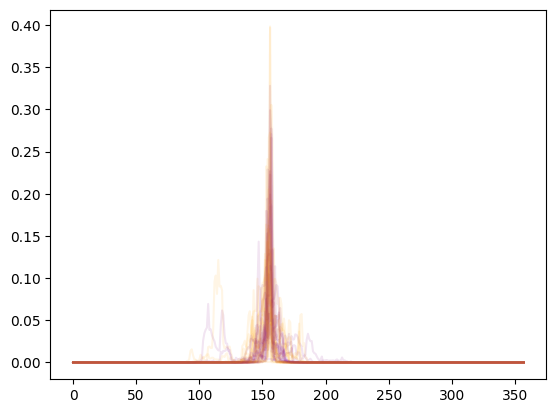

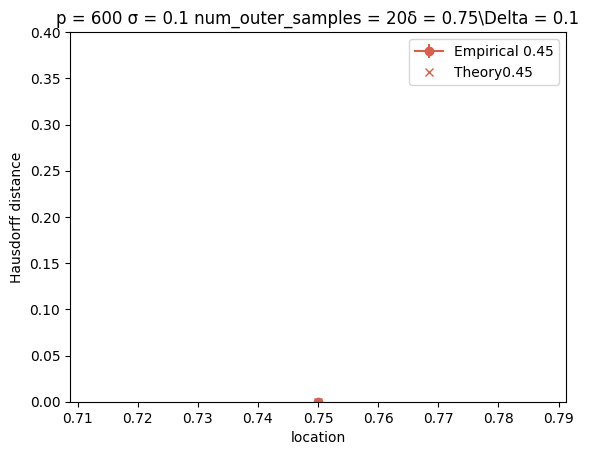

In [1]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 600
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.75]
# δ_list = [0.25, 0.5]

seed = 42
nprandom.seed(2*seed)

chgpt_location_idx = [0.45]

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

empirical_credible_set_list = [[] for h in range(len(chgpt_location_idx))]
theoretical_credible_set_list = [[] for h in range(len(chgpt_location_idx))]
coverage_list = [[] for h in range(len(chgpt_location_idx))]
theoretical_coverage_list = [[] for h in range(len(chgpt_location_idx))]
coverage_list_std = [[] for h in range(len(chgpt_location_idx))]
theoretical_coverage_list_std = [[] for h in range(len(chgpt_location_idx))]

# chgpt_location_idx = [0.2, 0.3]

empirical_hausdorff = np.zeros((len(chgpt_location_idx), len(δ_list)))
theory_hausdorff = np.zeros((len(chgpt_location_idx), len(δ_list)))
empirical_hausdorff_std = np.zeros((len(chgpt_location_idx), len(δ_list)))
theory_hausdorff_std = np.zeros((len(chgpt_location_idx), len(δ_list)))

for i in tqdm(range(len(chgpt_location_idx))):

    for h in range(len(δ_list)): 
        δ = δ_list[h]
        print("δ = ", δ)

        n = int(δ * p)
        B̃_cov = np.eye(L)
        true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 

        # --- Preliminaries ---
        # Changepoint locations
        Δ = lambda n: int(n/10)
        Lmin = 2
        Lmax = 2 # TODO: ground truth is L=4 cell stages (3 chgpts).
        num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
        assert η_arr.shape == (num_valid_configs, Lmax-1) and \
            len(p_η_arr) == num_valid_configs
        assert ϕ.shape == (Lmax, n)

        print(f"True chgpts = {true_chgpt_locations(n)}")
        C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

        signal_prior = GaussianSignal(B̃_cov)
        # Sample the noise vector
        η_true = true_chgpt_locations(n)

        signal_prior = GaussianSignal(B̃_cov)

        ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

        # --- Set up theoretical coverage ---
        # Compute the fixed-C SE for given chgpt location
        ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

        # Sample Z, V_\Theta
        num_outer_samples = 20
        # Sample Z

        norm_sq_corr_1_list = []
        norm_sq_corr_2_list = []
        norm_sq_corr_1_SE_list = []
        norm_sq_corr_2_SE_list = []
        empirical_hausdorff_inner_list = []
        theory_hausdorff_inner_list = []
        inner_coverage_list = []
        inner_theoretical_coverage_list = []
        for k in tqdm(range(num_outer_samples)):
            # --- Set up empirical coverage ---
            # Gaussian Prior
            B̃ = signal_prior.sample(p)
            B̂_0 = signal_prior.sample(p)

            # Generate the observation vector Y
            X = np.random.normal(0, np.sqrt(1/n), (n, p))
            Θ = X @ B̃
            Y = q(Θ, C_true, σ) 

            # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
            # ν = ν_arr[-1]
            # κ_T = κ_T_arr[-1]
            # ν_fixed = ν_fixed_arr[-1]
            # κ_T_fixed = κ_T_fixed_arr[-1]

            B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
            κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν


            norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
            norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
            norm_sq_corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
            norm_sq_corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))
            # print("norm_sq_corr_1_list: ", norm_sq_corr_1_list)
            # print("norm_sq_corr_2_list: ", norm_sq_corr_2_list)
            # print("norm_sq_corr_1_SE_list: ", norm_sq_corr_1_SE_list)
            # print("norm_sq_corr_2_SE_list: ", norm_sq_corr_2_SE_list)


            # # Sqcorr plots
            # plt.errorbar([δ], np.mean(norm_sq_corr_1_list), yerr = np.std(norm_sq_corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
            # plt.errorbar([δ], np.mean(norm_sq_corr_2_list), yerr = np.std(norm_sq_corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
            # plt.scatter([δ], norm_sq_corr_1_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[0])
            # plt.scatter([δ], norm_sq_corr_2_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[2])
            # plt.ylim((0, 1))
            # plt.xlabel("δ")
            # plt.ylabel("Norm Sq Corr")
            # plt.legend()
            # plt.show()

            # B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
            # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
    
            # --- MAP from AMP ---
            # Compute the credible set S(Θ_t, Y)
            post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
            AMP_η_MAP = amp.posterior.MAP_η(η_arr, post_Θ_Y)
            empirical_hausdorff_inner_list.append((1/n) * amp.performance_measures.hausdorff(AMP_η_MAP, η_true))
            α_CI = 0.05
            plt.plot(post_Θ_Y, color='purple', alpha=0.1)
            # plt.show()
            try:
                # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) 
                S_lower_AMP, S_upper_AMP = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_Θ_Y)
                # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
            except Exception as e:
                print("Credible Set Error: ", e)
                # S_lower, S_upper = None, None
                continue
            # S_lower_upper_list[i].append((S_lower, S_upper))
            print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower_AMP:S_upper_AMP].sum())
            # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])
            empirical_credible_set_list[i].append((S_lower_AMP, S_upper_AMP))

            # --- Compute MAP from theoretical ---
            # Compute the credible set S(Θ_t, Y)
            Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
            # Sample V̄_Θ
            V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
                jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
            # post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
            post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
            α_CI = 0.05
            plt.plot(post_V_q, color='orange', alpha=0.1)
            try:
                # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_V_q) 
                S_lower_theory, S_upper_theory = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_V_q)
                # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
            except Exception as e:
                print("Credible Set Error: ", e)
                # S_lower, S_upper = None, None
                continue
            theoretical_credible_set_list[i].append((S_lower_theory, S_upper_theory))
            # theory_η_MAP = amp.posterior.MAP_η(η_arr, post_V_q)
            # theory_hausdorff_inner_list.append((1/n) * amp.performance_measures.hausdorff(theory_η_MAP, η_true))

            ## Sample Z, V̄_Θ, ε̄. 
            num_samples = 1000
            # Sample Z
            Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
            # Sample V̄_Θ
            V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
                jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
            # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
            ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
            # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
            Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n

            # η_arr, p_η_arr, V, Y, ρ, σ, ν, κ_T
            emp_cov_lis = []
            theory_cov_lis = []
            for b in range(num_samples):
                theory_post = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[b], q(Z[b], C_true, σ), jnp.array(ρ), σ, ν, κ_T)
                emp_cov_lis.append(np.sum(theory_post[S_lower_AMP:S_upper_AMP]))
                theory_cov_lis.append(np.sum(theory_post[S_lower_theory:S_upper_theory]))
            inner_coverage_list.append(np.mean(emp_cov_lis))
            inner_theoretical_coverage_list.append(np.mean(theory_cov_lis))
            print("std inner empirical coverage: ", np.std(emp_cov_lis))
            print("std inner theoretical coverage: ", np.std(theory_cov_lis))
        coverage_list[i].append(np.mean(inner_coverage_list))
        theoretical_coverage_list[i].append(np.mean(inner_theoretical_coverage_list))
        coverage_list_std[i].append(np.std(inner_coverage_list))
        theoretical_coverage_list_std[i].append(np.std(inner_theoretical_coverage_list))




            # comp_post_mapped = jax.vmap(amp.posterior.posterior_over_η, in_axes=(None, None, 0, 0, None, None, None, None), out_axes=0)
            # post_res = comp_post_mapped(η_arr, p_η_arr, V̄_θ, Ȳ, ρ, σ, ν, κ_T)
            # coverage_list[h] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
            # theoretical_coverage_list[h] = np.sum(post_res[np.arange(num_samples), S_lower_theory:S_upper_theory], axis = 1)

        # empirical_hausdorff[i, h] = np.mean(empirical_hausdorff_inner_list)
        # theory_hausdorff[i, h] = np.mean(theory_hausdorff_inner_list)
        # empirical_hausdorff_std[i, h] = np.std(empirical_hausdorff_inner_list)
        # theory_hausdorff_std[i, h] = np.std(theory_hausdorff_inner_list)

            ### --- Estimate Expected coverage, with ensemble variables --- ###
            ## Sample Z, V̄_Θ, ε̄. 
            # num_samples = 100
            # # Sample Z
            # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
            # # Sample V̄_Θ
            # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
            # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
            # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
            # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

            # ## Sample Z, V̄_Θ, ε̄. 
            # num_samples = 300
            # # Sample Z
            # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
            # # Sample V̄_Θ
            # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
            # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
            # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
            # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
            # Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n

            # comp_post_mapped = jax.vmap(amp.posterior.compute_posterior, in_axes=(None, 0, 0, None, None, None, None, None), out_axes=0)
            # post_res = comp_post_mapped(C_s, V̄_θ, Ȳ, n, ρ, σ, ν, κ_T)
            # coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
            # theoretical_coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_theory:S_upper_theory], axis = 1)

            # for j in range(num_samples):
            #     Ȳ = q(Z[j].reshape((n, L)), C_true, σ)
            #     # post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
            #     post_V_Z_eval = amp.posterior.compute_posterior(C_s, V̄_θ[j], Ȳ, n, ρ, σ, ν, κ_T)
            #     # plt.plot(post_V_Z_eval, color='orange', alpha=0.1)
            #     # plt.show()
            #     # if S_lower is not None:
            #     #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
            #     coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_AMP:S_upper_AMP]))
            #     theoretical_coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_theory:S_upper_theory]))
                # else:
                #     coverage_list[i].append(None)
            # print("Empirical coverage: ", np.mean(coverage_list[i]))
            # print("Theoretical coverage: ", np.mean(theoretical_coverage_list[i]))
            # Add x-ticks where S_lower and S_upper are
            # plt.axvline(x=S_lower_AMP, color='black', linestyle='--')
            # plt.axvline(x=S_upper_AMP, color='black', linestyle='--')
            # plt.axvline(x=S_lower_theory, color='blue', linestyle='-.')
            # plt.axvline(x=S_upper_theory, color='blue', linestyle='-.')
            # plt.title("Posterior over η")
            # plt.show()
        

# Save the variables to a file
np.savez("coverage_replot.npz", empirical_hausdorff = empirical_hausdorff, theory_hausdorff=theory_hausdorff, δ_list=np.array(δ_list), chgpt_location_idx=np.array(chgpt_location_idx), empirical_hausdorff_std=empirical_hausdorff_std, theory_hausdorff_std=theory_hausdorff_std)


### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
fig = plt.figure()
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0.2, 0.8, (len(chgpt_location_idx)))]
for i in range(len(chgpt_location_idx)):
    plt.errorbar(δ_list, empirical_hausdorff[i], yerr = empirical_hausdorff_std[i], label="Empirical " + str(chgpt_location_idx[i]) , marker="o", ls="-", c=colors[i], alpha = 1)
    plt.errorbar(δ_list, theory_hausdorff[i], label="Theory" + str(chgpt_location_idx[i]), marker="x", ls="", c=colors[i], alpha = 1)
# plt.plot(np.array(δ_list), empirical_hausdorff.T, label="Empirical", marker="o", ls="--", alpha = 1)
# plt.plot(np.array(δ_list), theory_hausdorff.T, label="Theory", marker="x", ls="", alpha = 1)
# plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
# plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("location")
plt.ylabel("Hausdorff distance")
# plt.title(str("p = ", str(p), " σ = ", str(σ), " num_outer_samples = ", str(num_outer_samples), "δ = ", str(δ), "\Delta = ", str(Δ(n)/n)))
plt.title(str("p = " + str(p) + " σ = " + str(σ) + " num_outer_samples = " + str(num_outer_samples) +  "δ = " +  str(δ) + "\Delta = " + str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 0.4))

plt.savefig("coverage_replot.pdf")

plt.show()


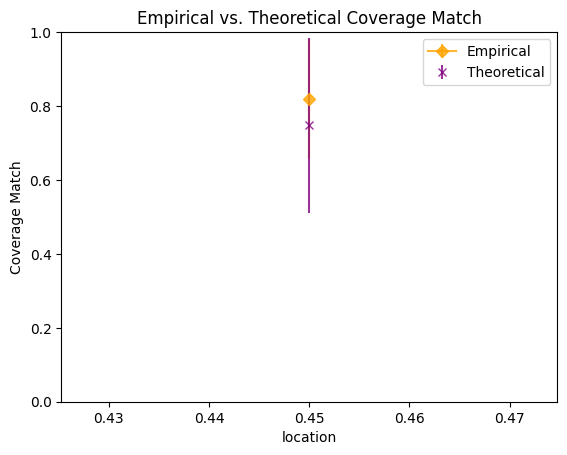

In [2]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
# Save the variables to a file
np.savez("coverage_replot.npz", coverage_list = coverage_list, theoretical_coverage_list = theoretical_coverage_list, coverage_list_std = coverage_list_std, theoretical_coverage_list_std = theoretical_coverage_list_std, empirical_hausdorff = empirical_hausdorff, theory_hausdorff=theory_hausdorff, δ_list=np.array(δ_list), chgpt_location_idx=np.array(chgpt_location_idx), empirical_hausdorff_std=empirical_hausdorff_std, theory_hausdorff_std=theory_hausdorff_std)

plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.errorbar(chgpt_location_idx, coverage_list, yerr= np.array(coverage_list_std), marker="D", color='orange', label='Empirical', alpha = 0.8)
plt.errorbar(chgpt_location_idx, theoretical_coverage_list, yerr = theoretical_coverage_list_std, color='purple', label='Theoretical', ls = "", marker='x', alpha = 0.8)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))

plt.savefig("coverage_replot.pdf")
plt.show()

In [10]:
theoretical_coverage_list

[[0.741805818785218], [0.754674983839463]]

### Coverage experiment, switching order of integration

  0%|          | 0/4 [00:00<?, ?it/s]

δ =  1.0
True chgpts = [180]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9591008168499211


  3%|▎         | 1/30 [01:06<32:04, 66.37s/it]

Constructed credible set with aimed coverage:  0.9589464268453637


  7%|▋         | 2/30 [02:10<30:15, 64.83s/it]

Constructed credible set with aimed coverage:  0.9577629401652719


 10%|█         | 3/30 [03:13<28:53, 64.21s/it]

Constructed credible set with aimed coverage:  0.9642472629740507


 13%|█▎        | 4/30 [04:17<27:44, 64.03s/it]

Constructed credible set with aimed coverage:  0.9821516604031576


 17%|█▋        | 5/30 [05:21<26:40, 64.00s/it]

Constructed credible set with aimed coverage:  0.9621039553517805


 20%|██        | 6/30 [06:24<25:32, 63.85s/it]

Constructed credible set with aimed coverage:  0.9521501664759442


 23%|██▎       | 7/30 [07:28<24:27, 63.80s/it]

Constructed credible set with aimed coverage:  0.9564366647708042


 27%|██▋       | 8/30 [08:31<23:20, 63.65s/it]

Constructed credible set with aimed coverage:  0.9821219544719837


 30%|███       | 9/30 [09:35<22:17, 63.69s/it]

Constructed credible set with aimed coverage:  0.9714279954344823


 33%|███▎      | 10/30 [10:39<21:14, 63.72s/it]

Constructed credible set with aimed coverage:  0.9506287564867775


 37%|███▋      | 11/30 [11:43<20:09, 63.67s/it]

Constructed credible set with aimed coverage:  0.9538648219471043


 40%|████      | 12/30 [12:46<19:05, 63.63s/it]

Constructed credible set with aimed coverage:  0.9995624832824278


 43%|████▎     | 13/30 [13:50<18:02, 63.68s/it]

Constructed credible set with aimed coverage:  0.9632039705377683


 47%|████▋     | 14/30 [14:53<16:58, 63.66s/it]

Constructed credible set with aimed coverage:  0.9619443167146388


 50%|█████     | 15/30 [15:57<15:55, 63.67s/it]

Constructed credible set with aimed coverage:  0.9894692052845739


 53%|█████▎    | 16/30 [17:01<14:52, 63.73s/it]

Constructed credible set with aimed coverage:  0.9581006186159953


 57%|█████▋    | 17/30 [18:05<13:48, 63.73s/it]

Constructed credible set with aimed coverage:  0.9642074608416016


 60%|██████    | 18/30 [19:08<12:44, 63.72s/it]

Constructed credible set with aimed coverage:  0.988504280342662


 63%|██████▎   | 19/30 [20:12<11:41, 63.79s/it]

Constructed credible set with aimed coverage:  0.9582883484092217


 67%|██████▋   | 20/30 [21:16<10:38, 63.85s/it]

Constructed credible set with aimed coverage:  0.9537446852896062


 70%|███████   | 21/30 [22:20<09:34, 63.79s/it]

Constructed credible set with aimed coverage:  0.9510946289160785


 73%|███████▎  | 22/30 [23:24<08:29, 63.72s/it]

Constructed credible set with aimed coverage:  0.9541467556713521


 77%|███████▋  | 23/30 [24:27<07:25, 63.67s/it]

Constructed credible set with aimed coverage:  0.9534454949472383


 80%|████████  | 24/30 [25:31<06:22, 63.72s/it]

Constructed credible set with aimed coverage:  0.9538123384608449


 83%|████████▎ | 25/30 [26:35<05:18, 63.67s/it]

Constructed credible set with aimed coverage:  0.9988686993878816


 87%|████████▋ | 26/30 [27:39<04:15, 63.79s/it]

Constructed credible set with aimed coverage:  0.9932794336700368


 90%|█████████ | 27/30 [28:43<03:11, 63.87s/it]

Constructed credible set with aimed coverage:  0.9573469355980292


 93%|█████████▎| 28/30 [29:47<02:07, 63.94s/it]

Constructed credible set with aimed coverage:  0.9740520144193677


 97%|█████████▋| 29/30 [30:51<01:04, 64.03s/it]

Constructed credible set with aimed coverage:  0.9642892523962316


 25%|██▌       | 1/4 [32:15<1:36:45, 1935.16s/it]

δ =  1.0
True chgpts = [240]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9751085090905472


  3%|▎         | 1/30 [01:04<31:06, 64.37s/it]

Constructed credible set with aimed coverage:  0.96851364974107


  7%|▋         | 2/30 [02:08<29:53, 64.04s/it]

Constructed credible set with aimed coverage:  0.9982656730363495


 10%|█         | 3/30 [03:12<28:51, 64.12s/it]

Constructed credible set with aimed coverage:  0.9627188497550045


 13%|█▎        | 4/30 [04:15<27:40, 63.86s/it]

Constructed credible set with aimed coverage:  0.9995215263950987


 17%|█▋        | 5/30 [05:19<26:33, 63.75s/it]

Constructed credible set with aimed coverage:  0.9783440154409533


 20%|██        | 6/30 [06:23<25:34, 63.95s/it]

Constructed credible set with aimed coverage:  0.9572905722602236


 23%|██▎       | 7/30 [07:30<24:49, 64.75s/it]

Constructed credible set with aimed coverage:  0.9568261813436707


 27%|██▋       | 8/30 [08:35<23:46, 64.84s/it]

Constructed credible set with aimed coverage:  0.999760575279281


 30%|███       | 9/30 [09:40<22:41, 64.84s/it]

Constructed credible set with aimed coverage:  0.9816567135132906


 33%|███▎      | 10/30 [10:45<21:40, 65.02s/it]

Constructed credible set with aimed coverage:  0.968247557606663


 37%|███▋      | 11/30 [11:50<20:35, 65.04s/it]

Constructed credible set with aimed coverage:  0.9700114642804536


 40%|████      | 12/30 [12:56<19:34, 65.22s/it]

Constructed credible set with aimed coverage:  0.9505911128455335


 43%|████▎     | 13/30 [14:01<18:31, 65.36s/it]

Constructed credible set with aimed coverage:  0.983588153601194


 47%|████▋     | 14/30 [15:07<17:25, 65.35s/it]

Constructed credible set with aimed coverage:  0.9554923421133849


 50%|█████     | 15/30 [16:12<16:21, 65.43s/it]

Constructed credible set with aimed coverage:  0.9524786292945463


 53%|█████▎    | 16/30 [17:18<15:16, 65.49s/it]

Constructed credible set with aimed coverage:  0.9649740787744496


 57%|█████▋    | 17/30 [18:23<14:08, 65.24s/it]

Constructed credible set with aimed coverage:  0.963823001945585


 60%|██████    | 18/30 [19:28<13:03, 65.29s/it]

Constructed credible set with aimed coverage:  0.9533274038829039


 63%|██████▎   | 19/30 [20:32<11:55, 65.01s/it]

Constructed credible set with aimed coverage:  0.9736336297473528


 67%|██████▋   | 20/30 [21:37<10:48, 64.81s/it]

Constructed credible set with aimed coverage:  0.9743025561695667


 70%|███████   | 21/30 [22:41<09:43, 64.78s/it]

Constructed credible set with aimed coverage:  0.9575771435150803


 73%|███████▎  | 22/30 [23:46<08:38, 64.83s/it]

Constructed credible set with aimed coverage:  0.9917744617919222


 77%|███████▋  | 23/30 [24:51<07:32, 64.70s/it]

Constructed credible set with aimed coverage:  0.9734415866244741


 80%|████████  | 24/30 [25:55<06:27, 64.51s/it]

Constructed credible set with aimed coverage:  0.9586669934129686


 83%|████████▎ | 25/30 [26:59<05:21, 64.37s/it]

Constructed credible set with aimed coverage:  0.9995571470069575


 87%|████████▋ | 26/30 [28:03<04:17, 64.29s/it]

Constructed credible set with aimed coverage:  0.9704665982745486


 90%|█████████ | 27/30 [29:07<03:12, 64.22s/it]

Constructed credible set with aimed coverage:  0.986730292024019


 93%|█████████▎| 28/30 [30:11<02:08, 64.12s/it]

Constructed credible set with aimed coverage:  0.9634681778489489


 97%|█████████▋| 29/30 [31:15<01:04, 64.00s/it]

Constructed credible set with aimed coverage:  0.9998577085871829


 50%|█████     | 2/4 [1:04:50<1:04:53, 1946.86s/it]

δ =  1.0
True chgpts = [300]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.9614378850133318


  3%|▎         | 1/30 [01:03<30:48, 63.73s/it]

Constructed credible set with aimed coverage:  0.9542406253792206


  7%|▋         | 2/30 [02:07<29:43, 63.69s/it]

Constructed credible set with aimed coverage:  0.9534007168332604


 10%|█         | 3/30 [03:10<28:38, 63.64s/it]

Constructed credible set with aimed coverage:  0.9578141919170718


 13%|█▎        | 4/30 [04:14<27:34, 63.63s/it]

Constructed credible set with aimed coverage:  0.9629208057171298


 17%|█▋        | 5/30 [05:17<26:28, 63.54s/it]

Constructed credible set with aimed coverage:  0.971661924448144


 20%|██        | 6/30 [06:21<25:25, 63.56s/it]

Constructed credible set with aimed coverage:  0.9856008214564493


 23%|██▎       | 7/30 [07:25<24:23, 63.62s/it]

Constructed credible set with aimed coverage:  0.9506625889671614


 27%|██▋       | 8/30 [08:29<23:21, 63.69s/it]

Constructed credible set with aimed coverage:  0.964481633615719


 30%|███       | 9/30 [09:32<22:16, 63.65s/it]

Constructed credible set with aimed coverage:  0.9724636763912625


 33%|███▎      | 10/30 [10:36<21:11, 63.59s/it]

Constructed credible set with aimed coverage:  0.9559826692534323


 37%|███▋      | 11/30 [11:39<20:06, 63.52s/it]

Constructed credible set with aimed coverage:  0.9865173134577874


 40%|████      | 12/30 [12:43<19:04, 63.57s/it]

Constructed credible set with aimed coverage:  0.9522655822540992


 43%|████▎     | 13/30 [13:46<18:01, 63.61s/it]

Constructed credible set with aimed coverage:  0.9522888664421385


 47%|████▋     | 14/30 [14:50<16:58, 63.68s/it]

Constructed credible set with aimed coverage:  0.954758964338753


 50%|█████     | 15/30 [15:54<15:55, 63.72s/it]

Constructed credible set with aimed coverage:  0.951970477297976


 53%|█████▎    | 16/30 [16:59<14:55, 63.94s/it]

Constructed credible set with aimed coverage:  0.9677427022472849


 57%|█████▋    | 17/30 [18:02<13:49, 63.81s/it]

Constructed credible set with aimed coverage:  0.9522684001942604


 60%|██████    | 18/30 [19:06<12:45, 63.81s/it]

Constructed credible set with aimed coverage:  0.9727459844133889


 63%|██████▎   | 19/30 [20:10<11:41, 63.79s/it]

Constructed credible set with aimed coverage:  0.9570334471532204


 67%|██████▋   | 20/30 [21:13<10:37, 63.78s/it]

Constructed credible set with aimed coverage:  0.9551244271345813


 70%|███████   | 21/30 [22:17<09:34, 63.79s/it]

Constructed credible set with aimed coverage:  0.9947399627948049


 73%|███████▎  | 22/30 [23:21<08:29, 63.74s/it]

Constructed credible set with aimed coverage:  0.9516931089050212


 77%|███████▋  | 23/30 [24:25<07:26, 63.75s/it]

Constructed credible set with aimed coverage:  0.99983068259017


 80%|████████  | 24/30 [25:28<06:22, 63.78s/it]

Constructed credible set with aimed coverage:  0.96042439908081


 83%|████████▎ | 25/30 [26:32<05:18, 63.78s/it]

Constructed credible set with aimed coverage:  0.9795896429438887


 87%|████████▋ | 26/30 [27:36<04:14, 63.74s/it]

Constructed credible set with aimed coverage:  0.9958757360815984


 90%|█████████ | 27/30 [28:41<03:12, 64.02s/it]

Constructed credible set with aimed coverage:  0.9774402722391802


 93%|█████████▎| 28/30 [29:45<02:08, 64.08s/it]

Constructed credible set with aimed coverage:  0.9597806998615065


 97%|█████████▋| 29/30 [30:49<01:04, 64.02s/it]

Constructed credible set with aimed coverage:  0.9983466921929589


 75%|███████▌  | 3/4 [1:37:01<32:19, 1939.61s/it]  

δ =  1.0
True chgpts = [360]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Constructed credible set with aimed coverage:  0.959036723608635


  3%|▎         | 1/30 [01:05<31:29, 65.14s/it]

Constructed credible set with aimed coverage:  0.9743234138992567


  7%|▋         | 2/30 [02:10<30:28, 65.31s/it]

Constructed credible set with aimed coverage:  0.9681740321991864


 10%|█         | 3/30 [03:15<29:16, 65.07s/it]

Constructed credible set with aimed coverage:  0.9603031000303843


 13%|█▎        | 4/30 [04:20<28:11, 65.05s/it]

Constructed credible set with aimed coverage:  0.9501022217085722


 17%|█▋        | 5/30 [05:25<27:05, 65.03s/it]

Constructed credible set with aimed coverage:  0.993754427592857


 20%|██        | 6/30 [06:30<25:57, 64.91s/it]

Constructed credible set with aimed coverage:  0.9780120912934946


 23%|██▎       | 7/30 [07:34<24:50, 64.81s/it]

Constructed credible set with aimed coverage:  0.9536541525414983


 27%|██▋       | 8/30 [08:39<23:44, 64.77s/it]

Constructed credible set with aimed coverage:  0.9867371651161302


 30%|███       | 9/30 [09:43<22:38, 64.70s/it]

Constructed credible set with aimed coverage:  0.967649292910136


 33%|███▎      | 10/30 [10:48<21:35, 64.77s/it]

Constructed credible set with aimed coverage:  0.9671849767830376


 37%|███▋      | 11/30 [11:53<20:31, 64.80s/it]

Constructed credible set with aimed coverage:  0.979270835875379


 40%|████      | 12/30 [12:58<19:26, 64.83s/it]

Constructed credible set with aimed coverage:  0.9541394659184187


 43%|████▎     | 13/30 [14:03<18:21, 64.80s/it]

Constructed credible set with aimed coverage:  0.9774544989550463


 47%|████▋     | 14/30 [15:08<17:16, 64.77s/it]

Constructed credible set with aimed coverage:  0.9813858586352144


 50%|█████     | 15/30 [16:12<16:10, 64.72s/it]

Constructed credible set with aimed coverage:  0.9614267872609765


 53%|█████▎    | 16/30 [17:17<15:07, 64.80s/it]

Constructed credible set with aimed coverage:  0.9598404362685661


 57%|█████▋    | 17/30 [18:22<14:02, 64.83s/it]

Constructed credible set with aimed coverage:  0.9651454222073056


 60%|██████    | 18/30 [19:27<12:58, 64.89s/it]

Constructed credible set with aimed coverage:  0.9805482138890368


 63%|██████▎   | 19/30 [20:32<11:54, 64.92s/it]

Constructed credible set with aimed coverage:  0.9743077227446328


 67%|██████▋   | 20/30 [21:37<10:48, 64.88s/it]

Constructed credible set with aimed coverage:  0.9895826507620497


 70%|███████   | 21/30 [22:42<09:43, 64.86s/it]

Constructed credible set with aimed coverage:  0.9571308986987422


 73%|███████▎  | 22/30 [23:47<08:39, 64.89s/it]

Constructed credible set with aimed coverage:  0.9863544296840604


 77%|███████▋  | 23/30 [24:52<07:34, 64.95s/it]

Constructed credible set with aimed coverage:  0.9536389086511728


 80%|████████  | 24/30 [25:57<06:29, 64.96s/it]

Constructed credible set with aimed coverage:  0.9695153842977353


 83%|████████▎ | 25/30 [27:01<05:24, 64.92s/it]

Constructed credible set with aimed coverage:  0.9557068505441406


 87%|████████▋ | 26/30 [28:06<04:19, 64.88s/it]

Constructed credible set with aimed coverage:  0.9970809421873387


 90%|█████████ | 27/30 [29:11<03:14, 64.82s/it]

Constructed credible set with aimed coverage:  0.9626105412202327


 93%|█████████▎| 28/30 [30:16<02:09, 64.82s/it]

Constructed credible set with aimed coverage:  0.988303600203891


 97%|█████████▋| 29/30 [31:22<01:05, 65.21s/it]

Constructed credible set with aimed coverage:  0.9971272941236737


100%|██████████| 4/4 [2:09:45<00:00, 1946.44s/it]


ValueError: 'yerr' (shape: (4, 1)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (4, 1))

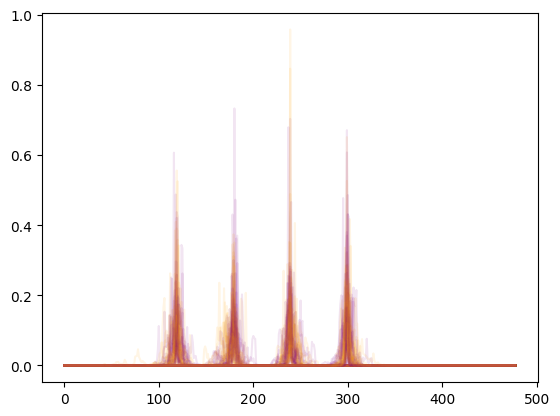

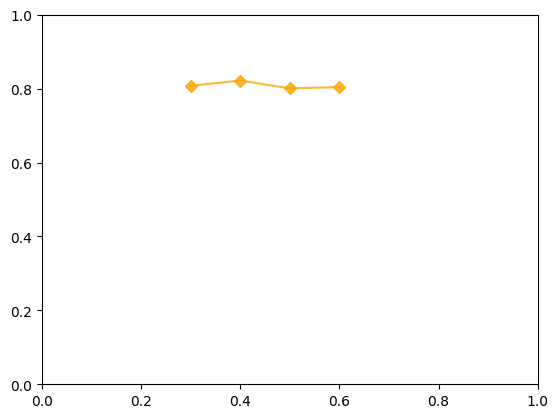

In [1]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 600
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [1.0]
# δ_list = [0.25, 0.5]

seed = 45
nprandom.seed(2*seed)

chgpt_location_idx = [0.3, 0.4, 0.5, 0.6]

post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []

empirical_credible_set_list = [[] for h in range(len(chgpt_location_idx))]
theoretical_credible_set_list = [[] for h in range(len(chgpt_location_idx))]
coverage_list = [[] for h in range(len(chgpt_location_idx))]
theoretical_coverage_list = [[] for h in range(len(chgpt_location_idx))]
coverage_list_std = [[] for h in range(len(chgpt_location_idx))]
theoretical_coverage_list_std = [[] for h in range(len(chgpt_location_idx))]

# chgpt_location_idx = [0.2, 0.3]

empirical_hausdorff = np.zeros((len(chgpt_location_idx), len(δ_list)))
theory_hausdorff = np.zeros((len(chgpt_location_idx), len(δ_list)))
empirical_hausdorff_std = np.zeros((len(chgpt_location_idx), len(δ_list)))
theory_hausdorff_std = np.zeros((len(chgpt_location_idx), len(δ_list)))

for i in tqdm(range(len(chgpt_location_idx))):

    for h in range(len(δ_list)): 
        δ = δ_list[h]
        print("δ = ", δ)

        n = int(δ * p)
        B̃_cov = np.eye(L)
        true_chgpt_locations = lambda n: [int(n * chgpt_location_idx[i])] 

        # --- Preliminaries ---
        # Changepoint locations
        Δ = lambda n: int(n/10)
        Lmin = 2
        Lmax = 2 # TODO: ground truth is L=4 cell stages (3 chgpts).
        num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
        assert η_arr.shape == (num_valid_configs, Lmax-1) and \
            len(p_η_arr) == num_valid_configs
        assert ϕ.shape == (Lmax, n)

        print(f"True chgpts = {true_chgpt_locations(n)}")
        C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

        signal_prior = GaussianSignal(B̃_cov)
        # Sample the noise vector
        η_true = true_chgpt_locations(n)

        signal_prior = GaussianSignal(B̃_cov)

        ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

        # --- Set up theoretical coverage ---
        # Compute the fixed-C SE for given chgpt location
        ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

        # Sample Z, V_\Theta
        num_outer_samples = 30
        # Sample Z

        norm_sq_corr_1_list = []
        norm_sq_corr_2_list = []
        norm_sq_corr_1_SE_list = []
        norm_sq_corr_2_SE_list = []
        empirical_hausdorff_inner_list = []
        theory_hausdorff_inner_list = []
        AMP_inner_coverage = []
        theory_inner_coverage = []
        for k in tqdm(range(num_outer_samples)):
            # --- Set up empirical coverage ---
            # Gaussian Prior
            B̃ = signal_prior.sample(p)
            B̂_0 = signal_prior.sample(p)

            # Generate the observation vector Y
            X = np.random.normal(0, np.sqrt(1/n), (n, p))
            Θ = X @ B̃
            Y = q(Θ, C_true, σ) 

            # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
            # ν = ν_arr[-1]
            # κ_T = κ_T_arr[-1]
            # ν_fixed = ν_fixed_arr[-1]
            # κ_T_fixed = κ_T_fixed_arr[-1]

            B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
            κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν


            norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
            norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
            norm_sq_corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
            norm_sq_corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))
            # print("norm_sq_corr_1_list: ", norm_sq_corr_1_list)
            # print("norm_sq_corr_2_list: ", norm_sq_corr_2_list)
            # print("norm_sq_corr_1_SE_list: ", norm_sq_corr_1_SE_list)
            # print("norm_sq_corr_2_SE_list: ", norm_sq_corr_2_SE_list)


            # # Sqcorr plots
            # plt.errorbar([δ], np.mean(norm_sq_corr_1_list), yerr = np.std(norm_sq_corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 0.5)
            # plt.errorbar([δ], np.mean(norm_sq_corr_2_list), yerr = np.std(norm_sq_corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 0.5)
            # plt.scatter([δ], norm_sq_corr_1_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[0])
            # plt.scatter([δ], norm_sq_corr_2_SE_list[k], label="Theory", marker="x", alpha = 0.5, c=PAL[2])
            # plt.ylim((0, 1))
            # plt.xlabel("δ")
            # plt.ylabel("Norm Sq Corr")
            # plt.legend()
            # plt.show()

            # B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
            # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
    
            # --- MAP from AMP ---
            # Compute the credible set S(Θ_t, Y)
            post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
            AMP_η_MAP = amp.posterior.MAP_η(η_arr, post_Θ_Y)
            empirical_hausdorff_inner_list.append((1/n) * amp.performance_measures.hausdorff(AMP_η_MAP, η_true))
            α_CI = 0.05
            plt.plot(post_Θ_Y, color='purple', alpha=0.1)
            # plt.show()
            try:
                # S_lower_AMP, S_upper_AMP = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_Θ_Y) 
                S_lower_AMP, S_upper_AMP = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_Θ_Y)
                # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
            except Exception as e:
                print("Credible Set Error: ", e)
                # S_lower, S_upper = None, None
                continue
            # S_lower_upper_list[i].append((S_lower, S_upper))
            print("Constructed credible set with aimed coverage: ", post_Θ_Y[S_lower_AMP:S_upper_AMP].sum())
            # estimated_coverage = np.sum(post_Θ_Y[S_lower:S_upper])
            empirical_credible_set_list[i].append((S_lower_AMP, S_upper_AMP))

            # --- Compute MAP from theoretical ---
            # Compute the credible set S(Θ_t, Y)
            Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
            # Sample V̄_Θ
            V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
                jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
            # post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
            post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
            α_CI = 0.05
            plt.plot(post_V_q, color='orange', alpha=0.1)
            try:
                # S_lower_theory, S_upper_theory = amp.posterior.bayes_credible_set_η(L, α_CI, η_arr, post_V_q) 
                S_lower_theory, S_upper_theory = amp.posterior.left_sided_credible_set_η(L, α_CI, η_arr, post_V_q)
                # S_lower_normalized, S_upper_normalized = S_lower/n, S_upper/n
            except Exception as e:
                print("Credible Set Error: ", e)
                # S_lower, S_upper = None, None
                continue
            theoretical_credible_set_list[i].append((S_lower_theory, S_upper_theory))
            # theory_η_MAP = amp.posterior.MAP_η(η_arr, post_V_q)
            # theory_hausdorff_inner_list.append((1/n) * amp.performance_measures.hausdorff(theory_η_MAP, η_true))

            ## Sample Z, V̄_Θ, ε̄. 
            num_samples = 500
            # Sample Z
            Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
            # Sample V̄_Θ
            V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
                jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
            # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
            ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
            # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
            Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n 

            # Compute the average posterior
            post_list = np.zeros((num_samples, len(η_arr)))
            for b in range(num_samples):
                theory_post = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[b], q(Z[b], C_true, σ), jnp.array(ρ), σ, ν, κ_T)
                post_list[b,:] = theory_post.reshape((1, len(η_arr)))
            avg_post = np.mean(post_list, axis=0)

            ## Compute the coverage on the average posterior
            AMP_inner_coverage.append(avg_post[S_lower_AMP: S_upper_AMP].sum())
            theory_inner_coverage.append(avg_post[S_lower_theory: S_upper_theory].sum())
        coverage_list[i].append(np.mean(AMP_inner_coverage))
        theoretical_coverage_list[i].append(np.mean(theory_inner_coverage)) 
        coverage_list_std[i].append(np.std(AMP_inner_coverage))
        theoretical_coverage_list_std[i].append(np.std(theory_inner_coverage))


            # η_arr, p_η_arr, V, Y, ρ, σ, ν, κ_T
        #     emp_cov_lis = []
        #     theory_cov_lis = []
        #     for b in range(num_samples):
        #         theory_post = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[b], q(Z[b], C_true, σ), jnp.array(ρ), σ, ν, κ_T)
        #         emp_cov_lis.append(np.sum(theory_post[S_lower_AMP:S_upper_AMP]))
        #         theory_cov_lis.append(np.sum(theory_post[S_lower_theory:S_upper_theory]))
        #     inner_coverage_list.append(np.mean(emp_cov_lis))
        #     inner_theoretical_coverage_list.append(np.mean(theory_cov_lis))
        #     print("std inner empirical coverage: ", np.std(emp_cov_lis))
        #     print("std inner theoretical coverage: ", np.std(theory_cov_lis))
        # coverage_list[i].append(np.mean(inner_coverage_list))
        # theoretical_coverage_list[i].append(np.mean(inner_theoretical_coverage_list))
        # coverage_list_std[i].append(np.std(inner_coverage_list))
        # theoretical_coverage_list_std[i].append(np.std(inner_theoretical_coverage_list))




            # comp_post_mapped = jax.vmap(amp.posterior.posterior_over_η, in_axes=(None, None, 0, 0, None, None, None, None), out_axes=0)
            # post_res = comp_post_mapped(η_arr, p_η_arr, V̄_θ, Ȳ, ρ, σ, ν, κ_T)
            # coverage_list[h] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
            # theoretical_coverage_list[h] = np.sum(post_res[np.arange(num_samples), S_lower_theory:S_upper_theory], axis = 1)

        # empirical_hausdorff[i, h] = np.mean(empirical_hausdorff_inner_list)
        # theory_hausdorff[i, h] = np.mean(theory_hausdorff_inner_list)
        # empirical_hausdorff_std[i, h] = np.std(empirical_hausdorff_inner_list)
        # theory_hausdorff_std[i, h] = np.std(theory_hausdorff_inner_list)

            ### --- Estimate Expected coverage, with ensemble variables --- ###
            ## Sample Z, V̄_Θ, ε̄. 
            # num_samples = 100
            # # Sample Z
            # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
            # # Sample V̄_Θ
            # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
            # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
            # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
            # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄

            # ## Sample Z, V̄_Θ, ε̄. 
            # num_samples = 300
            # # Sample Z
            # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_samples)))).reshape(num_samples, n, L)
            # # Sample V̄_Θ
            # V̄_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            #     jnp.zeros(L), κ_T, size=n))).reshape(num_samples, n, L)
            # # Sample ε̄, i.i.d gaussian distributed noise with variance σ^2
            # ε̄ = np.array(nprandom.normal(0, σ, size=(num_samples, n)))
            # # Ȳ_samp = Z[:, np.arange(n), C_true] + ε̄
            # Ȳ = Z[:, np.arange(n), C_true] + ε̄ # this is num_samples × n

            # comp_post_mapped = jax.vmap(amp.posterior.compute_posterior, in_axes=(None, 0, 0, None, None, None, None, None), out_axes=0)
            # post_res = comp_post_mapped(C_s, V̄_θ, Ȳ, n, ρ, σ, ν, κ_T)
            # coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_AMP:S_upper_AMP], axis = 1)
            # theoretical_coverage_list[i] = np.sum(post_res[np.arange(num_samples), S_lower_theory:S_upper_theory], axis = 1)

            # for j in range(num_samples):
            #     Ȳ = q(Z[j].reshape((n, L)), C_true, σ)
            #     # post_V_Z = amp.posterior.posterior_over_η(η_arr, p_η_arr, V̄_θ[j], Ȳ, jnp.array(ρ), σ, ν, κ_T)
            #     post_V_Z_eval = amp.posterior.compute_posterior(C_s, V̄_θ[j], Ȳ, n, ρ, σ, ν, κ_T)
            #     # plt.plot(post_V_Z_eval, color='orange', alpha=0.1)
            #     # plt.show()
            #     # if S_lower is not None:
            #     #     coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
            #     coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_AMP:S_upper_AMP]))
            #     theoretical_coverage_list[i].append(np.sum(post_V_Z_eval[S_lower_theory:S_upper_theory]))
                # else:
                #     coverage_list[i].append(None)
            # print("Empirical coverage: ", np.mean(coverage_list[i]))
            # print("Theoretical coverage: ", np.mean(theoretical_coverage_list[i]))
            # Add x-ticks where S_lower and S_upper are
            # plt.axvline(x=S_lower_AMP, color='black', linestyle='--')
            # plt.axvline(x=S_upper_AMP, color='black', linestyle='--')
            # plt.axvline(x=S_lower_theory, color='blue', linestyle='-.')
            # plt.axvline(x=S_upper_theory, color='blue', linestyle='-.')
            # plt.title("Posterior over η")
            # plt.show()
        
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
# Save the variables to a file
np.savez("coverage_replot_3.npz", coverage_list = coverage_list, theoretical_coverage_list = theoretical_coverage_list, coverage_list_std = coverage_list_std, theoretical_coverage_list_std = theoretical_coverage_list_std, empirical_hausdorff = empirical_hausdorff, theory_hausdorff=theory_hausdorff, δ_list=np.array(δ_list), chgpt_location_idx=np.array(chgpt_location_idx), empirical_hausdorff_std=empirical_hausdorff_std, theory_hausdorff_std=theory_hausdorff_std)

plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.errorbar(chgpt_location_idx, coverage_list, yerr= np.array(coverage_list_std), marker="D", color='orange', label='Empirical', alpha = 0.8)
plt.errorbar(chgpt_location_idx, theoretical_coverage_list, yerr = theoretical_coverage_list_std, color='purple', label='Theoretical', ls = "", marker='x', alpha = 0.8)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend()
plt.ylim((0, 1))

plt.savefig("coverage_replot_3.pdf")
plt.show()


In [4]:
post_list[499]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

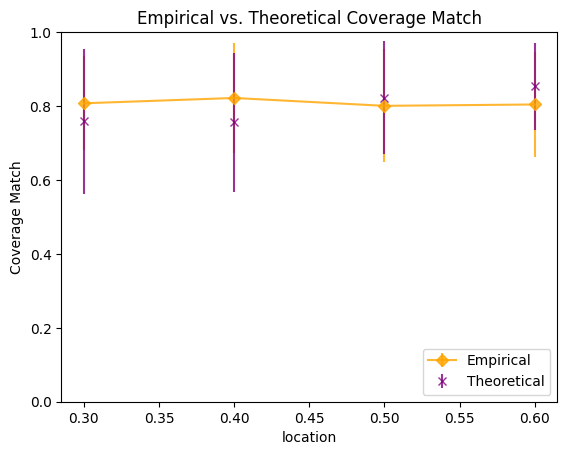

In [16]:
### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
# Save the variables to a file
np.savez("coverage_replot_2.npz", coverage_list = coverage_list, theoretical_coverage_list = theoretical_coverage_list, coverage_list_std = coverage_list_std, theoretical_coverage_list_std = theoretical_coverage_list_std, empirical_hausdorff = empirical_hausdorff, theory_hausdorff=theory_hausdorff, δ_list=np.array(δ_list), chgpt_location_idx=np.array(chgpt_location_idx), empirical_hausdorff_std=empirical_hausdorff_std, theory_hausdorff_std=theory_hausdorff_std)

plt.figure()
# plt.plot(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), color='purple', label='Theoretical')
# plt.plot(chgpt_location_idx, np.mean(coverage_list, axis=1), color='orange', label='Empirical')
plt.errorbar(chgpt_location_idx, np.array(coverage_list).flatten(), yerr= np.array(coverage_list_std).flatten(), marker="D", color='orange', label='Empirical', alpha = 0.8)
plt.errorbar(chgpt_location_idx, np.array(theoretical_coverage_list).flatten(), yerr = np.array(theoretical_coverage_list_std).flatten(), color='purple', label='Theoretical', ls = "", marker='x', alpha = 0.8)
plt.xlabel("location")
plt.ylabel("Coverage Match")
plt.title("Empirical vs. Theoretical Coverage Match")
plt.legend(loc="lower right")
plt.ylim((0, 1))

plt.savefig("coverage_replot_2_expectation_inside_integral_p600_delta1,0_sigma0,1_num_outer_samples30_inner_samples500.pdf")
plt.show()

In [4]:
(coverage_list_std)

[[0.12717829983825754],
 [0.14984991072548468],
 [0.15304387474043343],
 [0.14297436422333365]]

In [5]:
coverage_list

[[0.8074389057179768],
 [0.8218472023705201],
 [0.8005647453894453],
 [0.8042494162931685]]

In [9]:
np.array(theoretical_coverage_list_std).shape

(4, 1)

In [10]:
np.array(theoretical_coverage_list).shape

(4, 1)